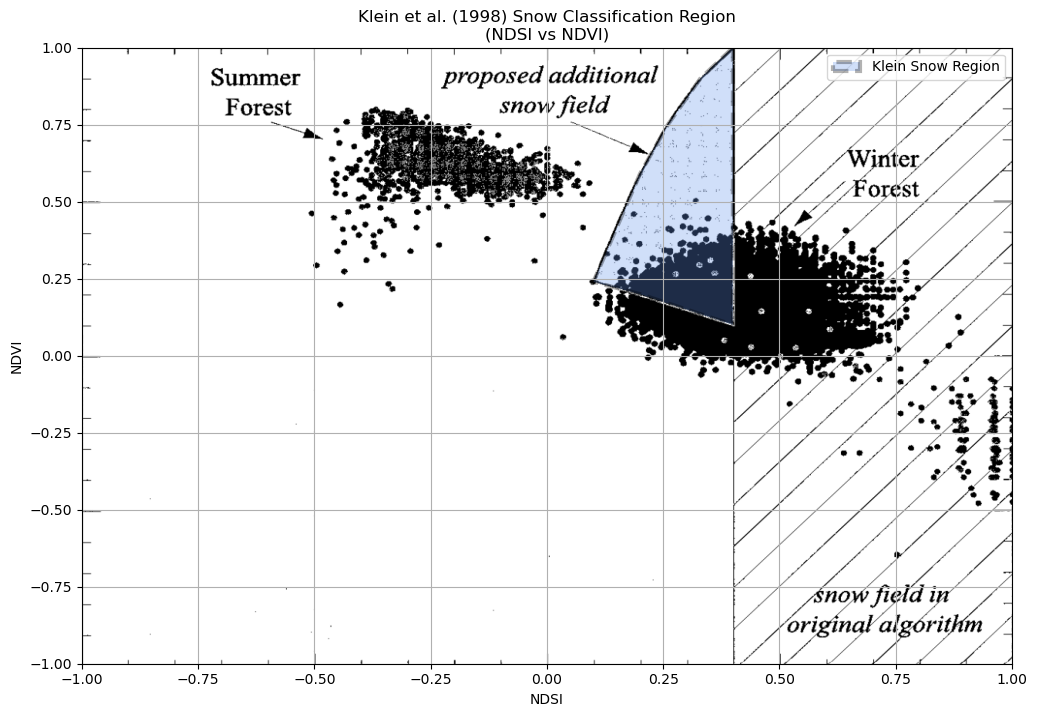

In [25]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import numpy as np
import matplotlib.image as mpimg

# Define approximate polygon (NDSI, NDVI)
region_coords = [
    (0.4, 1),
    (0.33, 0.9),
    (0.26, 0.75),
    (0.2, 0.59),
    (0.1, 0.24),  # bottom left
    (0.2,0.2),
    (0.4, 0.1),   # top right
]

# Extract polygon coordinates
polygon = Polygon(region_coords)
x_poly, y_poly = zip(*polygon.exterior.coords)

# Load the background image
img = mpimg.imread('./images/klein.png')

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Show background image to fill the entire axes
ax.imshow(
    img,
    extent=(-1, 1, -1, 1),   # match your axis limits
    aspect='auto',
    zorder=0
)

# Shaded polygon on top
ax.fill(
    x_poly, y_poly,
    facecolor='cornflowerblue',   # softer than pure blue
    edgecolor='black',
    linewidth=3.0,
    linestyle = 'dashed',
    alpha=0.3,                   # VERY subtle fill
    zorder=1,
    label='Klein Snow Region'
)

# Axes and labels
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel('NDSI')
ax.set_ylabel('NDVI')
ax.set_title('Klein et al. (1998) Snow Classification Region\n(NDSI vs NDVI)')
ax.grid(True, zorder=2)

ax.legend()
plt.show()


In [6]:
#!/usr/bin/env python3
import os

import rioxarray
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from rasterio.enums import Resampling
from pyproj import Transformer  # NEW

# ---------------- SETTINGS ----------------
TOA_FOLDER = "../scratch/data/landsat_klein_original_L1_GEE/TOA/"
MASK_FOLDER = "../scratch/data/landsat_masking_klein/"
CAM = "klein"   # used to find the corresponding LandCover file

# ROI options
USE_ROI = True  # set True to crop around a region of interest
ROI_LON = -105.90   # centre longitude (degrees)
ROI_LAT = 53.92     # centre latitude (degrees)
ROI_HALF_WIDTH_M = 26000   # half-width in metres (x direction)
ROI_HALF_HEIGHT_M = 26000  # half-height in metres (y direction)

# Plotting toggles
PLOT_NDSI_NDVI = False   # debug scatter
PLOT_RGB_MAPS  = False   # RGB + Dozier + Klein maps

# ---------------- HELPERS ----------------
def find_landcover_mask(folder, cam):
    for f in os.listdir(folder):
        if cam in f and "LandCover" in f:
            return os.path.join(folder, f)
    raise FileNotFoundError("No LandCover file found for camera:", cam)


def index(b1, b2):
    denom = b1 + b2
    return xr.where(denom != 0, (b1 - b2) / denom, np.nan)


def finite_mean(da):
    return float(da.where(np.isfinite(da)).mean().values)


def normalize_rgb(img):
    # img: (y, x, band)
    p2  = np.nanpercentile(img, 2,  axis=(0, 1))
    p98 = np.nanpercentile(img, 98, axis=(0, 1))
    return np.clip((img - p2) / (p98 - p2), 0, 1)


def subset_roi(da, centre_lon, centre_lat, half_width_m, half_height_m):
    """
    Subset a DataArray to a rectangular ROI around (lon, lat),
    using the dataset's CRS and units (usually metres).

    centre_lon / centre_lat in EPSG:4326
    half_width_m / half_height_m in metres.
    """
    if da.rio.crs is None:
        raise ValueError("Dataset has no CRS; cannot subset by lon/lat.")

    transformer = Transformer.from_crs("EPSG:4326", da.rio.crs, always_xy=True)
    cx, cy = transformer.transform(centre_lon, centre_lat)

    minx = cx - half_width_m
    maxx = cx + half_width_m
    miny = cy - half_height_m
    maxy = cy + half_height_m

    return da.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)


def mask_fill_pixels(landsat_da, n_sr_bands=6, tol=1e-6, max_fill_frac=0.3):
    """
    Mask off-scene/fill pixels in a reflectance/TOA stack.

    Strategy:
      - For each SR band, find the global minimum value.
      - Mark pixels 'near' that minimum (within `tol`) in that band.
      - A pixel is considered fill if it is near-min in *all* SR bands.

    Assumes SR_B1..SR_Bn are the first n_sr_bands in 'band'.
    """
    sr = landsat_da.isel(band=slice(0, n_sr_bands))  # (band, y, x)

    # per-band minima: dims ('band',)
    band_mins = sr.min(dim=("y", "x"), skipna=True)

    # broadcast automatically in xarray
    diff = sr - band_mins
    near_min = np.abs(diff) < tol                     # (band, y, x)

    # fill pixel = near-min in all SR bands
    fill_mask = near_min.all(dim="band")              # (y, x) boolean

    fill_frac = float(fill_mask.mean().values)
    print(f"  Estimated fill fraction: {fill_frac:.4f}")

    if fill_frac > max_fill_frac:
        print("  WARNING: fill fraction too large, skipping fill-mask.")
        return landsat_da

    return landsat_da.where(~fill_mask)


# Klein polygon
region_coords = [
    (0.4, 1),
    (0.33, 0.9),
    (0.26, 0.75),
    (0.2, 0.59),
    (0.1, 0.24),
    (0.2, 0.2),
    (0.4, 0.1),
]
polygon = Polygon(region_coords)

# ---------------- PER-SCENE PROCESSING ----------------
def process_scene(scene_path):
    """
    Run the full pipeline on a single TOA scene.
    Returns a dict with filename + forest-only snow estimates.
    """
    print(f"\nProcessing scene: {scene_path}")
    landsat = rioxarray.open_rasterio(scene_path, masked=True).squeeze()
    landsat.name = "landsat"

    # ROI
    if USE_ROI:
        print("  Subsetting Landsat to ROI...")
        landsat = subset_roi(
            landsat,
            centre_lon=ROI_LON,
            centre_lat=ROI_LAT,
            half_width_m=ROI_HALF_WIDTH_M,
            half_height_m=ROI_HALF_HEIGHT_M,
        )

    # dynamic fill masking
    landsat = mask_fill_pixels(landsat, n_sr_bands=6, tol=1e-6)

    # quick stats
    sr = landsat.isel(band=slice(0, 6))
    print(
        "  SR (B1–B6) mean/min/max:",
        float(sr.mean().values),
        float(sr.min().values),
        float(sr.max().values),
    )

    # Landcover
    lc_path = find_landcover_mask(MASK_FOLDER, CAM)
    landcover = rioxarray.open_rasterio(lc_path, masked=True).squeeze()
    landcover.name = "corine_landcover"
    landcover = landcover.rio.reproject_match(landsat, resampling=Resampling.nearest)

    if USE_ROI:
        print("  Subsetting LandCover to ROI...")
        landcover = subset_roi(
            landcover,
            centre_lon=ROI_LON,
            centre_lat=ROI_LAT,
            half_width_m=ROI_HALF_WIDTH_M,
            half_height_m=ROI_HALF_HEIGHT_M,
        )

    lc_mask = (landcover >= 111) & (landcover <= 126)

    # Extract L5-style bands
    blue  = landsat.isel(band=0)  # SR_B1
    green = landsat.isel(band=1)  # SR_B2
    red   = landsat.isel(band=2)  # SR_B3
    nir   = landsat.isel(band=3)  # SR_B4
    swir1 = landsat.isel(band=4)  # SR_B5

    ndsi = index(green, swir1)
    ndvi = index(nir, red)

    # Dozier
    cond1 = (ndsi > 0.1) & (ndsi < 0.4)
    cond2 = (ndsi >= 0.4) & (nir > 0.11)
    dozier = xr.where(cond1 | cond2, 1, 0).where(~np.isnan(ndsi))

    # Klein
    klein = xr.zeros_like(ndsi)
    klein = xr.where((ndsi >= 0.4) & (nir > 0.11), 1, klein)

    ndsi_vals, ndvi_vals = ndsi.values, ndvi.values
    green_vals = green.values
    nir_vals   = nir.values

    mask_poly = np.zeros(ndsi.shape, dtype=bool)

    xs_green, ys_green = [], []
    xs_yellow, ys_yellow = [], []
    xs_red, ys_red = [], []
    xs_nonfin, ys_nonfin = [], []

    for i in range(ndsi.shape[0]):
        for j in range(ndsi.shape[1]):
            x = ndsi_vals[i, j]
            y = ndvi_vals[i, j]

            if not (np.isfinite(x) and np.isfinite(y)):
                if PLOT_NDSI_NDVI:
                    xs_nonfin.append(x)
                    ys_nonfin.append(y)
                continue

            g = green_vals[i, j]
            n = nir_vals[i, j]

            hard_klein = (x >= 0.4) and (n > 0.11)
            in_poly = polygon.contains(Point(x, y))
            is_snow_pre_veto = in_poly or hard_klein

            if in_poly:
                mask_poly[i, j] = True

            if is_snow_pre_veto and (g <= 0.1):
                if PLOT_NDSI_NDVI:
                    xs_yellow.append(x)
                    ys_yellow.append(y)
                continue

            if is_snow_pre_veto:
                if PLOT_NDSI_NDVI:
                    xs_green.append(x)
                    ys_green.append(y)
                continue

            if PLOT_NDSI_NDVI:
                xs_red.append(x)
                ys_red.append(y)

    # optional NDSI–NDVI plot
    if PLOT_NDSI_NDVI:
        fig, ax = plt.subplots(figsize=(6, 6))
        poly_x, poly_y = polygon.exterior.xy
        ax.plot(poly_x, poly_y, "k-", linewidth=2)
        ax.scatter(xs_red, ys_red, s=1, color="red", alpha=0.5, label="Outside polygon / hard rule")
        ax.scatter(xs_green, ys_green, s=1, color="green", alpha=0.5, label="Inside polygon OR hard rule")
        ax.scatter(xs_yellow, ys_yellow, s=4, color="yellow", alpha=0.8, label="Vetoed by green<=0.1")
        ax.scatter(xs_nonfin, ys_nonfin, s=4, color="black", alpha=0.7, label="Non-finite")
        ax.set_xlabel("NDSI")
        ax.set_ylabel("NDVI")
        ax.set_title("Debug plot reflecting EXACT Klein logic")
        ax.legend(markerscale=4)
        ax.grid(True)
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        plt.tight_layout()
        plt.show()

    klein = xr.where(
        xr.DataArray(mask_poly, dims=ndsi.dims, coords=ndsi.coords),
        1,
        klein,
    )
    klein = klein.where(~np.isnan(ndsi) & ~np.isnan(ndvi))

    # Salomonson & Appel
    fsc = 0.06 + 1.21 * ndsi
    fsc = fsc.clip(0, 1).where(~np.isnan(ndsi))

    # Forest-only masks
    dozier_masked = dozier.where(lc_mask)
    klein_masked  = klein.where(lc_mask)
    fsc_masked    = fsc.where(lc_mask)

    dozier_mean = finite_mean(dozier_masked)
    klein_mean  = finite_mean(klein_masked)
    salo_mean   = finite_mean(fsc_masked)

    print("  Dozier mean (forest only):", dozier_mean)
    print("  Klein mean (forest only): ", klein_mean)
    print("  Salomonson mean FSC (forest only):", salo_mean)

    # optional RGB + maps
    if PLOT_RGB_MAPS:
        rgb = xr.concat([red, green, blue], dim="band").transpose("y", "x", "band")
        rgb_np = normalize_rgb(rgb.values)

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(rgb_np)
        axes[0].set_title("RGB Composite")
        axes[0].axis("off")

        dozier_masked.plot(ax=axes[1])
        axes[1].set_title("Dozier (LandCover-masked)")
        axes[1].axis("off")

        klein_masked.plot(ax=axes[2])
        axes[2].set_title("Klein (LandCover-masked)")
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()

    return {
        "filename": os.path.basename(scene_path),
        "dozier_mean_forest": dozier_mean,
        "klein_mean_forest": klein_mean,
        "salomonson_mean_forest": salo_mean,
    }


# ---------------- MAIN LOOP ----------------
def main():
    tif_paths = sorted(
        os.path.join(TOA_FOLDER, f)
        for f in os.listdir(TOA_FOLDER)
        if f.endswith(".tif")
    )
    print(f"Found {len(tif_paths)} scenes")

    rows = []
    for path in tif_paths:
        rows.append(process_scene(path))

    df = pd.DataFrame(rows)
    print("\nSummary DataFrame:")
    print(df)

    # Optionally save
    # df.to_csv("klein_L1_TOA_snow_estimates.csv", index=False)

    return df


if __name__ == "__main__":
    main()


Found 6 scenes

Processing scene: ../scratch/data/landsat_klein_original_L1_GEE/TOA/Landsat5_klein100_LT05_L1TP_037023_19930118_20200914_02_T1.tif
  Subsetting Landsat to ROI...
  Estimated fill fraction: 0.0000
  SR (B1–B6) mean/min/max: 42.35685348510742 -0.008647100999951363 263.3757019042969
  Subsetting LandCover to ROI...
  Dozier mean (forest only): 0.9999836815096935
  Klein mean (forest only):  0.9972421526908875
  Salomonson mean FSC (forest only): 0.7947289943695068

Processing scene: ../scratch/data/landsat_klein_original_L1_GEE/TOA/Landsat5_klein100_LT05_L1TP_037023_19940206_20200913_02_T1.tif
  Subsetting Landsat to ROI...
  Estimated fill fraction: 0.0000
  SR (B1–B6) mean/min/max: 39.65437698364258 0.005586312152445316 241.2418670654297
  Subsetting LandCover to ROI...
  Dozier mean (forest only): 0.9977246498029729
  Klein mean (forest only):  0.7505760192871094
  Salomonson mean FSC (forest only): 0.5609174966812134

Processing scene: ../scratch/data/landsat_klein_ori

In [8]:
#!/usr/bin/env python3
import os

import rioxarray
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from rasterio.enums import Resampling
from pyproj import Transformer  # NEW

# ---------------- SETTINGS ----------------
TOA_FOLDER = "../scratch/data/landsat_klein_original_L2_GEE/SR/"
MASK_FOLDER = "../scratch/data/landsat_masking_klein/"
CAM = "klein"   # used to find the corresponding LandCover file

# ROI options
USE_ROI = True  # set True to crop around a region of interest
ROI_LON = -105.90   # centre longitude (degrees)
ROI_LAT = 53.92     # centre latitude (degrees)
ROI_HALF_WIDTH_M = 26000   # half-width in metres (x direction)
ROI_HALF_HEIGHT_M = 26000  # half-height in metres (y direction)

# Plotting toggles
PLOT_NDSI_NDVI = False   # debug scatter
PLOT_RGB_MAPS  = False   # RGB + Dozier + Klein maps

# ---------------- HELPERS ----------------
def find_landcover_mask(folder, cam):
    for f in os.listdir(folder):
        if cam in f and "LandCover" in f:
            return os.path.join(folder, f)
    raise FileNotFoundError("No LandCover file found for camera:", cam)


def index(b1, b2):
    denom = b1 + b2
    return xr.where(denom != 0, (b1 - b2) / denom, np.nan)


def finite_mean(da):
    return float(da.where(np.isfinite(da)).mean().values)


def normalize_rgb(img):
    # img: (y, x, band)
    p2  = np.nanpercentile(img, 2,  axis=(0, 1))
    p98 = np.nanpercentile(img, 98, axis=(0, 1))
    return np.clip((img - p2) / (p98 - p2), 0, 1)


def subset_roi(da, centre_lon, centre_lat, half_width_m, half_height_m):
    """
    Subset a DataArray to a rectangular ROI around (lon, lat),
    using the dataset's CRS and units (usually metres).

    centre_lon / centre_lat in EPSG:4326
    half_width_m / half_height_m in metres.
    """
    if da.rio.crs is None:
        raise ValueError("Dataset has no CRS; cannot subset by lon/lat.")

    transformer = Transformer.from_crs("EPSG:4326", da.rio.crs, always_xy=True)
    cx, cy = transformer.transform(centre_lon, centre_lat)

    minx = cx - half_width_m
    maxx = cx + half_width_m
    miny = cy - half_height_m
    maxy = cy + half_height_m

    return da.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)


def mask_fill_pixels(landsat_da, n_sr_bands=6, tol=1e-6, max_fill_frac=0.3):
    """
    Mask off-scene/fill pixels in a reflectance/TOA stack.

    Strategy:
      - For each SR band, find the global minimum value.
      - Mark pixels 'near' that minimum (within `tol`) in that band.
      - A pixel is considered fill if it is near-min in *all* SR bands.

    Assumes SR_B1..SR_Bn are the first n_sr_bands in 'band'.
    """
    sr = landsat_da.isel(band=slice(0, n_sr_bands))  # (band, y, x)

    # per-band minima: dims ('band',)
    band_mins = sr.min(dim=("y", "x"), skipna=True)

    # broadcast automatically in xarray
    diff = sr - band_mins
    near_min = np.abs(diff) < tol                     # (band, y, x)

    # fill pixel = near-min in all SR bands
    fill_mask = near_min.all(dim="band")              # (y, x) boolean

    fill_frac = float(fill_mask.mean().values)
    print(f"  Estimated fill fraction: {fill_frac:.4f}")

    if fill_frac > max_fill_frac:
        print("  WARNING: fill fraction too large, skipping fill-mask.")
        return landsat_da

    return landsat_da.where(~fill_mask)


# Klein polygon
region_coords = [
    (0.4, 1),
    (0.33, 0.9),
    (0.26, 0.75),
    (0.2, 0.59),
    (0.1, 0.24),
    (0.2, 0.2),
    (0.4, 0.1),
]
polygon = Polygon(region_coords)

# ---------------- PER-SCENE PROCESSING ----------------
def process_scene(scene_path):
    """
    Run the full pipeline on a single TOA scene.
    Returns a dict with filename + forest-only snow estimates.
    """
    print(f"\nProcessing scene: {scene_path}")
    landsat = rioxarray.open_rasterio(scene_path, masked=True).squeeze()
    landsat.name = "landsat"

    # ROI
    if USE_ROI:
        print("  Subsetting Landsat to ROI...")
        landsat = subset_roi(
            landsat,
            centre_lon=ROI_LON,
            centre_lat=ROI_LAT,
            half_width_m=ROI_HALF_WIDTH_M,
            half_height_m=ROI_HALF_HEIGHT_M,
        )

    # dynamic fill masking
    landsat = mask_fill_pixels(landsat, n_sr_bands=6, tol=1e-6)

    # quick stats
    sr = landsat.isel(band=slice(0, 6))
    print(
        "  SR (B1–B6) mean/min/max:",
        float(sr.mean().values),
        float(sr.min().values),
        float(sr.max().values),
    )

    # Landcover
    lc_path = find_landcover_mask(MASK_FOLDER, CAM)
    landcover = rioxarray.open_rasterio(lc_path, masked=True).squeeze()
    landcover.name = "corine_landcover"
    landcover = landcover.rio.reproject_match(landsat, resampling=Resampling.nearest)

    if USE_ROI:
        print("  Subsetting LandCover to ROI...")
        landcover = subset_roi(
            landcover,
            centre_lon=ROI_LON,
            centre_lat=ROI_LAT,
            half_width_m=ROI_HALF_WIDTH_M,
            half_height_m=ROI_HALF_HEIGHT_M,
        )

    lc_mask = (landcover >= 111) & (landcover <= 126)

    # Extract L5-style bands
    blue  = landsat.isel(band=0)  # SR_B1
    green = landsat.isel(band=1)  # SR_B2
    red   = landsat.isel(band=2)  # SR_B3
    nir   = landsat.isel(band=3)  # SR_B4
    swir1 = landsat.isel(band=4)  # SR_B5

    ndsi = index(green, swir1)
    ndvi = index(nir, red)

    # Dozier
    cond1 = (ndsi > 0.1) & (ndsi < 0.4)
    cond2 = (ndsi >= 0.4) & (nir > 0.11)
    dozier = xr.where(cond1 | cond2, 1, 0).where(~np.isnan(ndsi))

    # Klein
    klein = xr.zeros_like(ndsi)
    klein = xr.where((ndsi >= 0.4) & (nir > 0.11), 1, klein)

    ndsi_vals, ndvi_vals = ndsi.values, ndvi.values
    green_vals = green.values
    nir_vals   = nir.values

    mask_poly = np.zeros(ndsi.shape, dtype=bool)

    xs_green, ys_green = [], []
    xs_yellow, ys_yellow = [], []
    xs_red, ys_red = [], []
    xs_nonfin, ys_nonfin = [], []

    for i in range(ndsi.shape[0]):
        for j in range(ndsi.shape[1]):
            x = ndsi_vals[i, j]
            y = ndvi_vals[i, j]

            if not (np.isfinite(x) and np.isfinite(y)):
                if PLOT_NDSI_NDVI:
                    xs_nonfin.append(x)
                    ys_nonfin.append(y)
                continue

            g = green_vals[i, j]
            n = nir_vals[i, j]

            hard_klein = (x >= 0.4) and (n > 0.11)
            in_poly = polygon.contains(Point(x, y))
            is_snow_pre_veto = in_poly or hard_klein

            if in_poly:
                mask_poly[i, j] = True

            if is_snow_pre_veto and (g <= 0.1):
                if PLOT_NDSI_NDVI:
                    xs_yellow.append(x)
                    ys_yellow.append(y)
                continue

            if is_snow_pre_veto:
                if PLOT_NDSI_NDVI:
                    xs_green.append(x)
                    ys_green.append(y)
                continue

            if PLOT_NDSI_NDVI:
                xs_red.append(x)
                ys_red.append(y)

    # optional NDSI–NDVI plot
    if PLOT_NDSI_NDVI:
        fig, ax = plt.subplots(figsize=(6, 6))
        poly_x, poly_y = polygon.exterior.xy
        ax.plot(poly_x, poly_y, "k-", linewidth=2)
        ax.scatter(xs_red, ys_red, s=1, color="red", alpha=0.5, label="Outside polygon / hard rule")
        ax.scatter(xs_green, ys_green, s=1, color="green", alpha=0.5, label="Inside polygon OR hard rule")
        ax.scatter(xs_yellow, ys_yellow, s=4, color="yellow", alpha=0.8, label="Vetoed by green<=0.1")
        ax.scatter(xs_nonfin, ys_nonfin, s=4, color="black", alpha=0.7, label="Non-finite")
        ax.set_xlabel("NDSI")
        ax.set_ylabel("NDVI")
        ax.set_title("Debug plot reflecting EXACT Klein logic")
        ax.legend(markerscale=4)
        ax.grid(True)
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        plt.tight_layout()
        plt.show()

    klein = xr.where(
        xr.DataArray(mask_poly, dims=ndsi.dims, coords=ndsi.coords),
        1,
        klein,
    )
    klein = klein.where(~np.isnan(ndsi) & ~np.isnan(ndvi))

    # Salomonson & Appel
    fsc = 0.06 + 1.21 * ndsi
    fsc = fsc.clip(0, 1).where(~np.isnan(ndsi))

    # Forest-only masks
    dozier_masked = dozier.where(lc_mask)
    klein_masked  = klein.where(lc_mask)
    fsc_masked    = fsc.where(lc_mask)

    dozier_mean = finite_mean(dozier_masked)
    klein_mean  = finite_mean(klein_masked)
    salo_mean   = finite_mean(fsc_masked)

    print("  Dozier mean (forest only):", dozier_mean)
    print("  Klein mean (forest only): ", klein_mean)
    print("  Salomonson mean FSC (forest only):", salo_mean)

    # optional RGB + maps
    if PLOT_RGB_MAPS:
        rgb = xr.concat([red, green, blue], dim="band").transpose("y", "x", "band")
        rgb_np = normalize_rgb(rgb.values)

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(rgb_np)
        axes[0].set_title("RGB Composite")
        axes[0].axis("off")

        dozier_masked.plot(ax=axes[1])
        axes[1].set_title("Dozier (LandCover-masked)")
        axes[1].axis("off")

        klein_masked.plot(ax=axes[2])
        axes[2].set_title("Klein (LandCover-masked)")
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()

    return {
        "filename": os.path.basename(scene_path),
        "dozier_mean_forest": dozier_mean,
        "klein_mean_forest": klein_mean,
        "salomonson_mean_forest": salo_mean,
    }


# ---------------- MAIN LOOP ----------------
def main():
    tif_paths = sorted(
        os.path.join(TOA_FOLDER, f)
        for f in os.listdir(TOA_FOLDER)
        if f.endswith(".tif")
    )
    print(f"Found {len(tif_paths)} scenes")

    rows = []
    for path in tif_paths:
        rows.append(process_scene(path))

    df = pd.DataFrame(rows)
    print("\nSummary DataFrame:")
    print(df)

    # Optionally save
    # df.to_csv("klein_L1_TOA_snow_estimates.csv", index=False)

    return df


if __name__ == "__main__":
    main()


Found 5 scenes

Processing scene: ../scratch/data/landsat_klein_original_L2_GEE/SR/Landsat5_klein100_LT05_L2SP_037023_19940206_20200913_02_T1.tif
  Subsetting Landsat to ROI...
  Estimated fill fraction: 0.0000
  SR (B1–B6) mean/min/max: 0.2139955312013626 -0.01179000735282898 1.5999850034713745
  Subsetting LandCover to ROI...
  Dozier mean (forest only): 0.997439042368134
  Klein mean (forest only):  0.7500816583633423
  Salomonson mean FSC (forest only): 0.5610085725784302

Processing scene: ../scratch/data/landsat_klein_original_L2_GEE/SR/Landsat5_klein100_LT05_L2SP_037023_19950329_20200912_02_T1.tif
  Subsetting Landsat to ROI...
  Estimated fill fraction: 0.0000
  SR (B1–B6) mean/min/max: 0.18505918979644775 -0.0016974955797195435 0.887652575969696
  Subsetting LandCover to ROI...
  Dozier mean (forest only): 0.9986052258822821
  Klein mean (forest only):  0.97752445936203
  Salomonson mean FSC (forest only): 0.6340686678886414

Processing scene: ../scratch/data/landsat_klein_ori

In [2]:
#!/usr/bin/env python3
import os

import rioxarray
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from rasterio.enums import Resampling
from pyproj import Transformer  # NEW

# ---------------- SETTINGS ----------------
TOA_FOLDER = "../scratch/data/landsat_klein_now_L2_GEE/SR/"
MASK_FOLDER = "../scratch/data/landsat_masking_klein/"
CAM = "klein"   # used to find the corresponding LandCover file

# ROI options
USE_ROI = True  # set True to crop around a region of interest
ROI_LON = -105.90   # centre longitude (degrees)
ROI_LAT = 53.92     # centre latitude (degrees)
ROI_HALF_WIDTH_M = 26000   # half-width in metres (x direction)
ROI_HALF_HEIGHT_M = 26000  # half-height in metres (y direction)

# Plotting toggles
PLOT_NDSI_NDVI = False   # debug scatter
PLOT_RGB_MAPS  = False   # RGB + Dozier + Klein maps

# ---------------- HELPERS ----------------
def find_landcover_mask(folder, cam):
    for f in os.listdir(folder):
        if cam in f and "LandCover" in f:
            return os.path.join(folder, f)
    raise FileNotFoundError("No LandCover file found for camera:", cam)


def index(b1, b2):
    denom = b1 + b2
    return xr.where(denom != 0, (b1 - b2) / denom, np.nan)


def finite_mean(da):
    return float(da.where(np.isfinite(da)).mean().values)


def normalize_rgb(img):
    # img: (y, x, band)
    p2  = np.nanpercentile(img, 2,  axis=(0, 1))
    p98 = np.nanpercentile(img, 98, axis=(0, 1))
    return np.clip((img - p2) / (p98 - p2), 0, 1)


def subset_roi(da, centre_lon, centre_lat, half_width_m, half_height_m):
    """
    Subset a DataArray to a rectangular ROI around (lon, lat),
    using the dataset's CRS and units (usually metres).

    centre_lon / centre_lat in EPSG:4326
    half_width_m / half_height_m in metres.
    """
    if da.rio.crs is None:
        raise ValueError("Dataset has no CRS; cannot subset by lon/lat.")

    transformer = Transformer.from_crs("EPSG:4326", da.rio.crs, always_xy=True)
    cx, cy = transformer.transform(centre_lon, centre_lat)

    minx = cx - half_width_m
    maxx = cx + half_width_m
    miny = cy - half_height_m
    maxy = cy + half_height_m

    return da.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)


def mask_fill_pixels(landsat_da, n_sr_bands=6, tol=1e-6, max_fill_frac=0.3):
    """
    Mask off-scene/fill pixels in a reflectance/TOA stack.

    Strategy:
      - For each SR band, find the global minimum value.
      - Mark pixels 'near' that minimum (within `tol`) in that band.
      - A pixel is considered fill if it is near-min in *all* SR bands.

    Assumes SR_B1..SR_Bn are the first n_sr_bands in 'band'.
    """
    sr = landsat_da.isel(band=slice(0, n_sr_bands))  # (band, y, x)

    # per-band minima: dims ('band',)
    band_mins = sr.min(dim=("y", "x"), skipna=True)

    # broadcast automatically in xarray
    diff = sr - band_mins
    near_min = np.abs(diff) < tol                     # (band, y, x)

    # fill pixel = near-min in all SR bands
    fill_mask = near_min.all(dim="band")              # (y, x) boolean

    fill_frac = float(fill_mask.mean().values)
    print(f"  Estimated fill fraction: {fill_frac:.4f}")

    if fill_frac > max_fill_frac:
        print("  WARNING: fill fraction too large, skipping fill-mask.")
        return landsat_da

    return landsat_da.where(~fill_mask)


# Klein polygon
region_coords = [
    (0.4, 1),
    (0.33, 0.9),
    (0.26, 0.75),
    (0.2, 0.59),
    (0.1, 0.24),
    (0.2, 0.2),
    (0.4, 0.1),
]
polygon = Polygon(region_coords)

# ---------------- PER-SCENE PROCESSING ----------------
def process_scene(scene_path):
    """
    Run the full pipeline on a single TOA scene.
    Returns a dict with filename + forest-only snow estimates.
    """
    print(f"\nProcessing scene: {scene_path}")
    landsat = rioxarray.open_rasterio(scene_path, masked=True).squeeze()
    landsat.name = "landsat"

    # ROI
    if USE_ROI:
        print("  Subsetting Landsat to ROI...")
        landsat = subset_roi(
            landsat,
            centre_lon=ROI_LON,
            centre_lat=ROI_LAT,
            half_width_m=ROI_HALF_WIDTH_M,
            half_height_m=ROI_HALF_HEIGHT_M,
        )

    # dynamic fill masking
    landsat = mask_fill_pixels(landsat, n_sr_bands=6, tol=1e-6)

    # quick stats
    sr = landsat.isel(band=slice(0, 6))
    print(
        "  SR (B1–B6) mean/min/max:",
        float(sr.mean().values),
        float(sr.min().values),
        float(sr.max().values),
    )

    # Landcover
    lc_path = find_landcover_mask(MASK_FOLDER, CAM)
    landcover = rioxarray.open_rasterio(lc_path, masked=True).squeeze()
    landcover.name = "corine_landcover"
    landcover = landcover.rio.reproject_match(landsat, resampling=Resampling.nearest)

    if USE_ROI:
        print("  Subsetting LandCover to ROI...")
        landcover = subset_roi(
            landcover,
            centre_lon=ROI_LON,
            centre_lat=ROI_LAT,
            half_width_m=ROI_HALF_WIDTH_M,
            half_height_m=ROI_HALF_HEIGHT_M,
        )

    lc_mask = (landcover >= 111) & (landcover <= 126)

    # Extract L5-style bands
    blue  = landsat.isel(band=1)  # SR_B1
    green = landsat.isel(band=2)  # SR_B2
    red   = landsat.isel(band=3)  # SR_B3
    nir   = landsat.isel(band=4)  # SR_B4
    swir1 = landsat.isel(band=5)  # SR_B5

    ndsi = index(green, swir1)
    ndvi = index(nir, red)

    # Dozier
    cond1 = (ndsi > 0.1) & (ndsi < 0.4)
    cond2 = (ndsi >= 0.4) & (nir > 0.11)
    dozier = xr.where(cond1 | cond2, 1, 0).where(~np.isnan(ndsi))

    # Klein
    klein = xr.zeros_like(ndsi)
    klein = xr.where((ndsi >= 0.4) & (nir > 0.11), 1, klein)

    ndsi_vals, ndvi_vals = ndsi.values, ndvi.values
    green_vals = green.values
    nir_vals   = nir.values

    mask_poly = np.zeros(ndsi.shape, dtype=bool)

    xs_green, ys_green = [], []
    xs_yellow, ys_yellow = [], []
    xs_red, ys_red = [], []
    xs_nonfin, ys_nonfin = [], []

    for i in range(ndsi.shape[0]):
        for j in range(ndsi.shape[1]):
            x = ndsi_vals[i, j]
            y = ndvi_vals[i, j]

            if not (np.isfinite(x) and np.isfinite(y)):
                if PLOT_NDSI_NDVI:
                    xs_nonfin.append(x)
                    ys_nonfin.append(y)
                continue

            g = green_vals[i, j]
            n = nir_vals[i, j]

            hard_klein = (x >= 0.4) and (n > 0.11)
            in_poly = polygon.contains(Point(x, y))
            is_snow_pre_veto = in_poly or hard_klein

            if in_poly:
                mask_poly[i, j] = True

            if is_snow_pre_veto and (g <= 0.1):
                if PLOT_NDSI_NDVI:
                    xs_yellow.append(x)
                    ys_yellow.append(y)
                continue

            if is_snow_pre_veto:
                if PLOT_NDSI_NDVI:
                    xs_green.append(x)
                    ys_green.append(y)
                continue

            if PLOT_NDSI_NDVI:
                xs_red.append(x)
                ys_red.append(y)

    # optional NDSI–NDVI plot
    if PLOT_NDSI_NDVI:
        fig, ax = plt.subplots(figsize=(6, 6))
        poly_x, poly_y = polygon.exterior.xy
        ax.plot(poly_x, poly_y, "k-", linewidth=2)
        ax.scatter(xs_red, ys_red, s=1, color="red", alpha=0.5, label="Outside polygon / hard rule")
        ax.scatter(xs_green, ys_green, s=1, color="green", alpha=0.5, label="Inside polygon OR hard rule")
        ax.scatter(xs_yellow, ys_yellow, s=4, color="yellow", alpha=0.8, label="Vetoed by green<=0.1")
        ax.scatter(xs_nonfin, ys_nonfin, s=4, color="black", alpha=0.7, label="Non-finite")
        ax.set_xlabel("NDSI")
        ax.set_ylabel("NDVI")
        ax.set_title("Debug plot reflecting EXACT Klein logic")
        ax.legend(markerscale=4)
        ax.grid(True)
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        plt.tight_layout()
        plt.show()

    klein = xr.where(
        xr.DataArray(mask_poly, dims=ndsi.dims, coords=ndsi.coords),
        1,
        klein,
    )
    klein = klein.where(~np.isnan(ndsi) & ~np.isnan(ndvi))

    # Salomonson & Appel
    fsc = 0.06 + 1.21 * ndsi
    fsc = fsc.clip(0, 1).where(~np.isnan(ndsi))

    # Forest-only masks
    dozier_masked = dozier.where(lc_mask)
    klein_masked  = klein.where(lc_mask)
    fsc_masked    = fsc.where(lc_mask)

    dozier_mean = finite_mean(dozier_masked)
    klein_mean  = finite_mean(klein_masked)
    salo_mean   = finite_mean(fsc_masked)

    print("  Dozier mean (forest only):", dozier_mean)
    print("  Klein mean (forest only): ", klein_mean)
    print("  Salomonson mean FSC (forest only):", salo_mean)

    # optional RGB + maps
    if PLOT_RGB_MAPS:
        rgb = xr.concat([red, green, blue], dim="band").transpose("y", "x", "band")
        rgb_np = normalize_rgb(rgb.values)

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(rgb_np)
        axes[0].set_title("RGB Composite")
        axes[0].axis("off")

        dozier_masked.plot(ax=axes[1])
        axes[1].set_title("Dozier (LandCover-masked)")
        axes[1].axis("off")

        klein_masked.plot(ax=axes[2])
        axes[2].set_title("Klein (LandCover-masked)")
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()

    return {
        "filename": os.path.basename(scene_path),
        "dozier_mean_forest": dozier_mean,
        "klein_mean_forest": klein_mean,
        "salomonson_mean_forest": salo_mean,
    }


# ---------------- MAIN LOOP ----------------
def main():
    tif_paths = sorted(
        os.path.join(TOA_FOLDER, f)
        for f in os.listdir(TOA_FOLDER)
        if f.endswith(".tif")
    )
    print(f"Found {len(tif_paths)} scenes")

    rows = []
    for path in tif_paths:
        rows.append(process_scene(path))

    df = pd.DataFrame(rows)
    print("\nSummary DataFrame:")
    print(df)

    # Optionally save
    # df.to_csv("klein_L1_TOA_snow_estimates.csv", index=False)

    return df


if __name__ == "__main__":
    main()


Found 17 scenes

Processing scene: ../scratch/data/landsat_klein_now_L2_GEE/SR/Landsat8_klein0_LC08_L2SP_037022_20190518_20200828_02_T1.tif
  Subsetting Landsat to ROI...
  Estimated fill fraction: 0.0000
  SR (B1–B6) mean/min/max: 0.06875722855329514 -0.019792497158050537 0.5563875436782837
  Subsetting LandCover to ROI...
  Dozier mean (forest only): 0.0014719023252232272
  Klein mean (forest only):  5.116514512337744e-05
  Salomonson mean FSC (forest only): 0.002766611520200968

Processing scene: ../scratch/data/landsat_klein_now_L2_GEE/SR/Landsat8_klein0_LC08_L2SP_037022_20210928_20211012_02_T1.tif
  Subsetting Landsat to ROI...
  Estimated fill fraction: 0.0000
  SR (B1–B6) mean/min/max: 0.06106540188193321 -0.013164997100830078 0.5467349886894226
  Subsetting LandCover to ROI...
  Dozier mean (forest only): 0.0016925978360732142
  Klein mean (forest only):  0.00030263629741966724
  Salomonson mean FSC (forest only): 0.0029750484973192215

Processing scene: ../scratch/data/landsat

In [1]:
#!/usr/bin/env python3
import os

import rioxarray
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from rasterio.enums import Resampling
from pyproj import Transformer  # NEW

# ---------------- SETTINGS ----------------
TOA_FOLDER = "../scratch/data/landsat_klein_now_L1_GEE/TOA/"
MASK_FOLDER = "../scratch/data/landsat_masking_klein/"
CAM = "klein"   # used to find the corresponding LandCover file

# ROI options
USE_ROI = True  # set True to crop around a region of interest
ROI_LON = -105.90   # centre longitude (degrees)
ROI_LAT = 53.92     # centre latitude (degrees)
ROI_HALF_WIDTH_M = 26000   # half-width in metres (x direction)
ROI_HALF_HEIGHT_M = 26000  # half-height in metres (y direction)

# Plotting toggles
PLOT_NDSI_NDVI = False   # debug scatter
PLOT_RGB_MAPS  = False   # RGB + Dozier + Klein maps

# ---------------- HELPERS ----------------
def find_landcover_mask(folder, cam):
    for f in os.listdir(folder):
        if cam in f and "LandCover" in f:
            return os.path.join(folder, f)
    raise FileNotFoundError("No LandCover file found for camera:", cam)


def index(b1, b2):
    denom = b1 + b2
    return xr.where(denom != 0, (b1 - b2) / denom, np.nan)


def finite_mean(da):
    return float(da.where(np.isfinite(da)).mean().values)


def normalize_rgb(img):
    # img: (y, x, band)
    p2  = np.nanpercentile(img, 2,  axis=(0, 1))
    p98 = np.nanpercentile(img, 98, axis=(0, 1))
    return np.clip((img - p2) / (p98 - p2), 0, 1)


def subset_roi(da, centre_lon, centre_lat, half_width_m, half_height_m):
    """
    Subset a DataArray to a rectangular ROI around (lon, lat),
    using the dataset's CRS and units (usually metres).

    centre_lon / centre_lat in EPSG:4326
    half_width_m / half_height_m in metres.
    """
    if da.rio.crs is None:
        raise ValueError("Dataset has no CRS; cannot subset by lon/lat.")

    transformer = Transformer.from_crs("EPSG:4326", da.rio.crs, always_xy=True)
    cx, cy = transformer.transform(centre_lon, centre_lat)

    minx = cx - half_width_m
    maxx = cx + half_width_m
    miny = cy - half_height_m
    maxy = cy + half_height_m

    return da.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)


def mask_fill_pixels(landsat_da, n_sr_bands=6, tol=1e-6, max_fill_frac=0.3):
    """
    Mask off-scene/fill pixels in a reflectance/TOA stack.

    Strategy:
      - For each SR band, find the global minimum value.
      - Mark pixels 'near' that minimum (within `tol`) in that band.
      - A pixel is considered fill if it is near-min in *all* SR bands.

    Assumes SR_B1..SR_Bn are the first n_sr_bands in 'band'.
    """
    sr = landsat_da.isel(band=slice(0, n_sr_bands))  # (band, y, x)

    # per-band minima: dims ('band',)
    band_mins = sr.min(dim=("y", "x"), skipna=True)

    # broadcast automatically in xarray
    diff = sr - band_mins
    near_min = np.abs(diff) < tol                     # (band, y, x)

    # fill pixel = near-min in all SR bands
    fill_mask = near_min.all(dim="band")              # (y, x) boolean

    fill_frac = float(fill_mask.mean().values)
    print(f"  Estimated fill fraction: {fill_frac:.4f}")

    if fill_frac > max_fill_frac:
        print("  WARNING: fill fraction too large, skipping fill-mask.")
        return landsat_da

    return landsat_da.where(~fill_mask)


# Klein polygon
region_coords = [
    (0.4, 1),
    (0.33, 0.9),
    (0.26, 0.75),
    (0.2, 0.59),
    (0.1, 0.24),
    (0.2, 0.2),
    (0.4, 0.1),
]
polygon = Polygon(region_coords)

# ---------------- PER-SCENE PROCESSING ----------------
def process_scene(scene_path):
    """
    Run the full pipeline on a single TOA scene.
    Returns a dict with filename + forest-only snow estimates.
    """
    print(f"\nProcessing scene: {scene_path}")
    landsat = rioxarray.open_rasterio(scene_path, masked=True).squeeze()
    landsat.name = "landsat"

    # ROI
    if USE_ROI:
        print("  Subsetting Landsat to ROI...")
        landsat = subset_roi(
            landsat,
            centre_lon=ROI_LON,
            centre_lat=ROI_LAT,
            half_width_m=ROI_HALF_WIDTH_M,
            half_height_m=ROI_HALF_HEIGHT_M,
        )

    # dynamic fill masking
    landsat = mask_fill_pixels(landsat, n_sr_bands=6, tol=1e-6)

    # quick stats
    sr = landsat.isel(band=slice(0, 6))
    print(
        "  SR (B1–B6) mean/min/max:",
        float(sr.mean().values),
        float(sr.min().values),
        float(sr.max().values),
    )

    # Landcover
    lc_path = find_landcover_mask(MASK_FOLDER, CAM)
    landcover = rioxarray.open_rasterio(lc_path, masked=True).squeeze()
    landcover.name = "corine_landcover"
    landcover = landcover.rio.reproject_match(landsat, resampling=Resampling.nearest)

    if USE_ROI:
        print("  Subsetting LandCover to ROI...")
        landcover = subset_roi(
            landcover,
            centre_lon=ROI_LON,
            centre_lat=ROI_LAT,
            half_width_m=ROI_HALF_WIDTH_M,
            half_height_m=ROI_HALF_HEIGHT_M,
        )

    lc_mask = (landcover >= 111) & (landcover <= 126)

    # Extract L5-style bands
    blue  = landsat.isel(band=1)  # SR_B1
    green = landsat.isel(band=2)  # SR_B2
    red   = landsat.isel(band=3)  # SR_B3
    nir   = landsat.isel(band=4)  # SR_B4
    swir1 = landsat.isel(band=5)  # SR_B5

    ndsi = index(green, swir1)
    ndvi = index(nir, red)

    # Dozier
    cond1 = (ndsi > 0.1) & (ndsi < 0.4)
    cond2 = (ndsi >= 0.4) & (nir > 0.11)
    dozier = xr.where(cond1 | cond2, 1, 0).where(~np.isnan(ndsi))

    # Klein
    klein = xr.zeros_like(ndsi)
    klein = xr.where((ndsi >= 0.4) & (nir > 0.11), 1, klein)

    ndsi_vals, ndvi_vals = ndsi.values, ndvi.values
    green_vals = green.values
    nir_vals   = nir.values

    mask_poly = np.zeros(ndsi.shape, dtype=bool)

    xs_green, ys_green = [], []
    xs_yellow, ys_yellow = [], []
    xs_red, ys_red = [], []
    xs_nonfin, ys_nonfin = [], []

    for i in range(ndsi.shape[0]):
        for j in range(ndsi.shape[1]):
            x = ndsi_vals[i, j]
            y = ndvi_vals[i, j]

            if not (np.isfinite(x) and np.isfinite(y)):
                if PLOT_NDSI_NDVI:
                    xs_nonfin.append(x)
                    ys_nonfin.append(y)
                continue

            g = green_vals[i, j]
            n = nir_vals[i, j]

            hard_klein = (x >= 0.4) and (n > 0.11)
            in_poly = polygon.contains(Point(x, y))
            is_snow_pre_veto = in_poly or hard_klein

            if in_poly:
                mask_poly[i, j] = True

            if is_snow_pre_veto and (g <= 0.1):
                if PLOT_NDSI_NDVI:
                    xs_yellow.append(x)
                    ys_yellow.append(y)
                continue

            if is_snow_pre_veto:
                if PLOT_NDSI_NDVI:
                    xs_green.append(x)
                    ys_green.append(y)
                continue

            if PLOT_NDSI_NDVI:
                xs_red.append(x)
                ys_red.append(y)

    # optional NDSI–NDVI plot
    if PLOT_NDSI_NDVI:
        fig, ax = plt.subplots(figsize=(6, 6))
        poly_x, poly_y = polygon.exterior.xy
        ax.plot(poly_x, poly_y, "k-", linewidth=2)
        ax.scatter(xs_red, ys_red, s=1, color="red", alpha=0.5, label="Outside polygon / hard rule")
        ax.scatter(xs_green, ys_green, s=1, color="green", alpha=0.5, label="Inside polygon OR hard rule")
        ax.scatter(xs_yellow, ys_yellow, s=4, color="yellow", alpha=0.8, label="Vetoed by green<=0.1")
        ax.scatter(xs_nonfin, ys_nonfin, s=4, color="black", alpha=0.7, label="Non-finite")
        ax.set_xlabel("NDSI")
        ax.set_ylabel("NDVI")
        ax.set_title("Debug plot reflecting EXACT Klein logic")
        ax.legend(markerscale=4)
        ax.grid(True)
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        plt.tight_layout()
        plt.show()

    klein = xr.where(
        xr.DataArray(mask_poly, dims=ndsi.dims, coords=ndsi.coords),
        1,
        klein,
    )
    klein = klein.where(~np.isnan(ndsi) & ~np.isnan(ndvi))

    # Salomonson & Appel
    fsc = 0.06 + 1.21 * ndsi
    fsc = fsc.clip(0, 1).where(~np.isnan(ndsi))

    # Forest-only masks
    dozier_masked = dozier.where(lc_mask)
    klein_masked  = klein.where(lc_mask)
    fsc_masked    = fsc.where(lc_mask)

    dozier_mean = finite_mean(dozier_masked)
    klein_mean  = finite_mean(klein_masked)
    salo_mean   = finite_mean(fsc_masked)

    print("  Dozier mean (forest only):", dozier_mean)
    print("  Klein mean (forest only): ", klein_mean)
    print("  Salomonson mean FSC (forest only):", salo_mean)

    # optional RGB + maps
    if PLOT_RGB_MAPS:
        rgb = xr.concat([red, green, blue], dim="band").transpose("y", "x", "band")
        rgb_np = normalize_rgb(rgb.values)

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(rgb_np)
        axes[0].set_title("RGB Composite")
        axes[0].axis("off")

        dozier_masked.plot(ax=axes[1])
        axes[1].set_title("Dozier (LandCover-masked)")
        axes[1].axis("off")

        klein_masked.plot(ax=axes[2])
        axes[2].set_title("Klein (LandCover-masked)")
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()

    return {
        "filename": os.path.basename(scene_path),
        "dozier_mean_forest": dozier_mean,
        "klein_mean_forest": klein_mean,
        "salomonson_mean_forest": salo_mean,
    }


# ---------------- MAIN LOOP ----------------
def main():
    tif_paths = sorted(
        os.path.join(TOA_FOLDER, f)
        for f in os.listdir(TOA_FOLDER)
        if f.endswith(".tif")
    )
    print(f"Found {len(tif_paths)} scenes")

    rows = []
    for path in tif_paths:
        rows.append(process_scene(path))

    df = pd.DataFrame(rows)
    print("\nSummary DataFrame:")
    print(df)

    # Optionally save
    # df.to_csv("klein_L1_TOA_snow_estimates.csv", index=False)

    return df


if __name__ == "__main__":
    main()


Found 9 scenes

Processing scene: ../scratch/data/landsat_klein_now_L1_GEE/TOA/Landsat8_klein100_LC08_L1TP_037023_20210216_20210301_02_T1.tif
  Subsetting Landsat to ROI...
  Estimated fill fraction: 0.0000
  SR (B1–B6) mean/min/max: 0.2774028480052948 0.018779953941702843 1.103878378868103
  Subsetting LandCover to ROI...
  Dozier mean (forest only): 0.999596250819227
  Klein mean (forest only):  0.9962174296379089
  Salomonson mean FSC (forest only): 0.6525044441223145

Processing scene: ../scratch/data/landsat_klein_now_L1_GEE/TOA/Landsat8_klein100_LC08_L1TP_037023_20210304_20210312_02_T1.tif
  Subsetting Landsat to ROI...
  Estimated fill fraction: 0.0000
  SR (B1–B6) mean/min/max: 0.27631211280822754 0.0110561428591609 0.9529978036880493
  Subsetting LandCover to ROI...
  Dozier mean (forest only): 0.9968552668469034
  Klein mean (forest only):  0.9903300404548645
  Salomonson mean FSC (forest only): 0.6662752628326416

Processing scene: ../scratch/data/landsat_klein_now_L1_GEE/TO

Landsat 5 raw shape: (13, 1758, 1750)
Landsat 5 corr shape: (19, 1758, 1750)
Landsat 8 raw shape: (17, 1758, 1750)
Landsat 8 corr shape: (19, 1758, 1750)

=== Blue band (L5 band index 0, L8 band index 1) ===
  L5 raw  range: 0.14080 .. 0.74927
  L5 corr range: 0.07074 .. 0.87839
  L8 raw  range: 0.08326 .. 0.98788
  L8 corr range: -0.19997 .. 1.31902


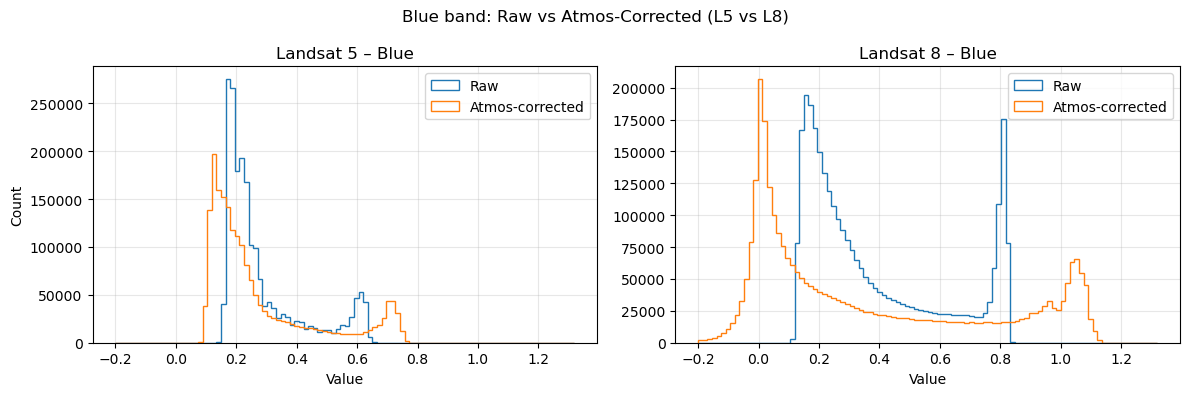

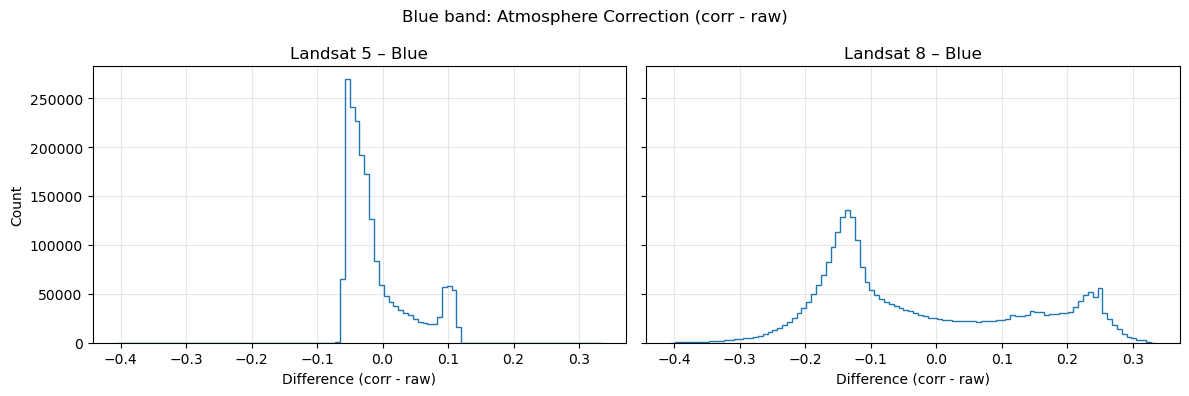


=== Green band (L5 band index 1, L8 band index 2) ===
  L5 raw  range: 0.08684 .. 0.81349
  L5 corr range: 0.06367 .. 1.07460
  L8 raw  range: 0.02562 .. 1.01129
  L8 corr range: -0.19997 .. 1.36538


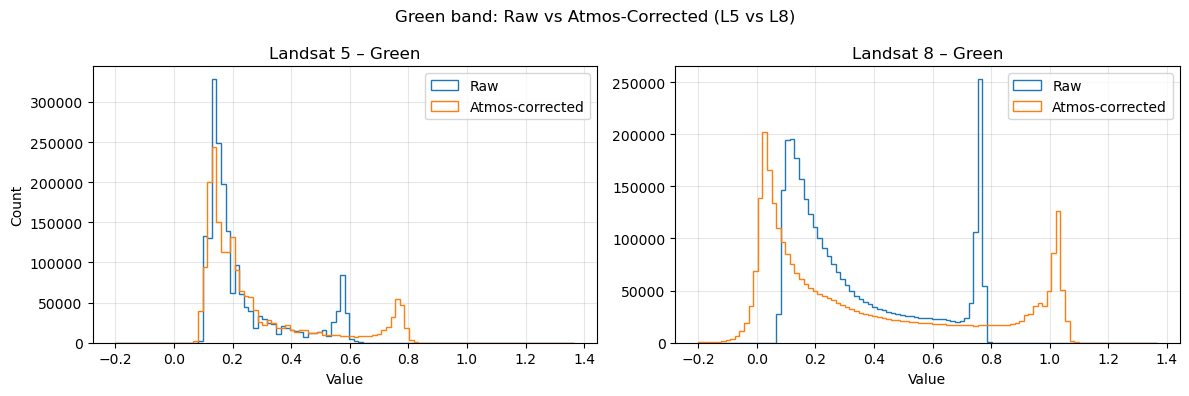

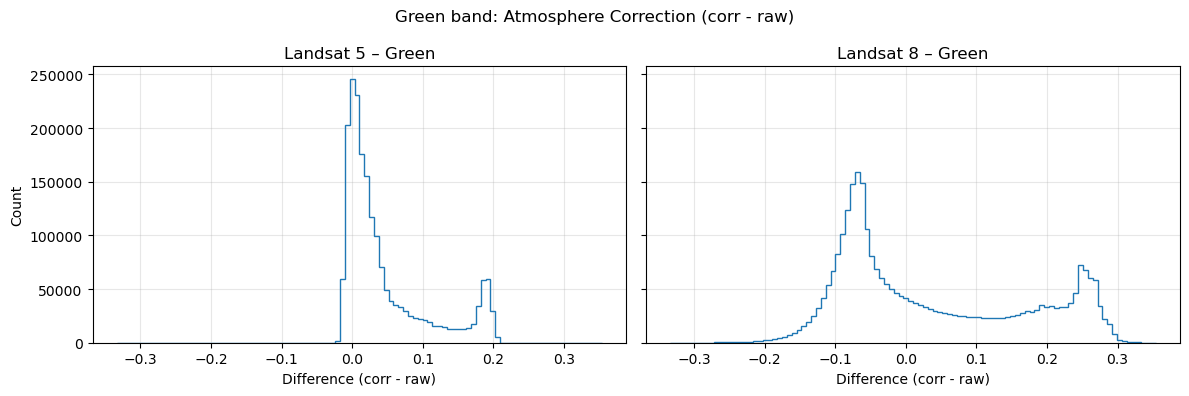


=== Red band (L5 band index 2, L8 band index 3) ===
  L5 raw  range: 0.05801 .. 0.99295
  L5 corr range: 0.04134 .. 1.20937
  L8 raw  range: 0.01703 .. 1.11124
  L8 corr range: -0.19997 .. 1.39143


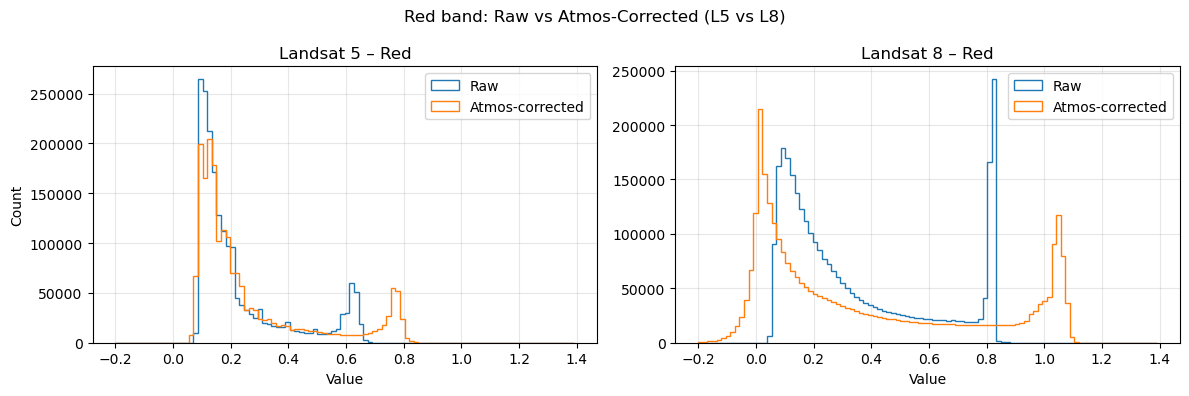

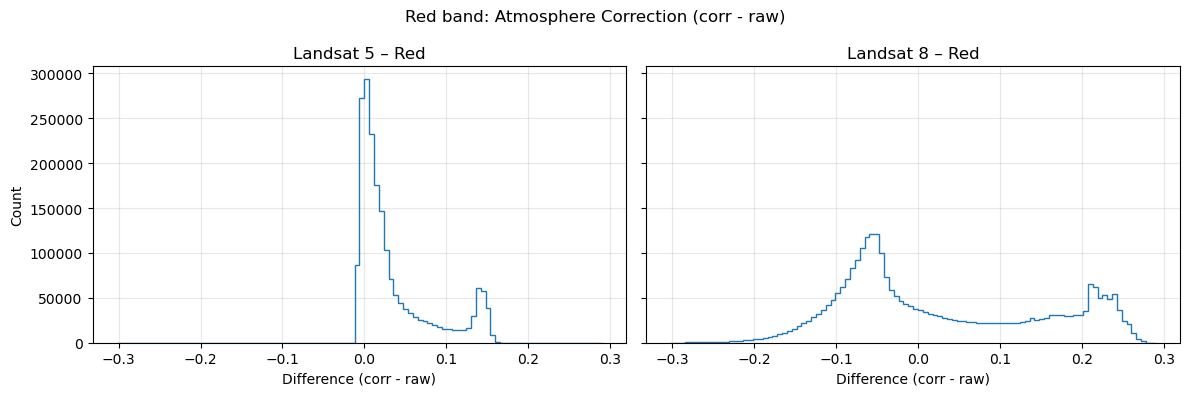


=== NIR band (L5 band index 3, L8 band index 4) ===
  L5 raw  range: 0.07375 .. 2.13201
  L5 corr range: 0.06804 .. 1.59999
  L8 raw  range: 0.04853 .. 1.16551
  L8 corr range: -0.13689 .. 1.30994


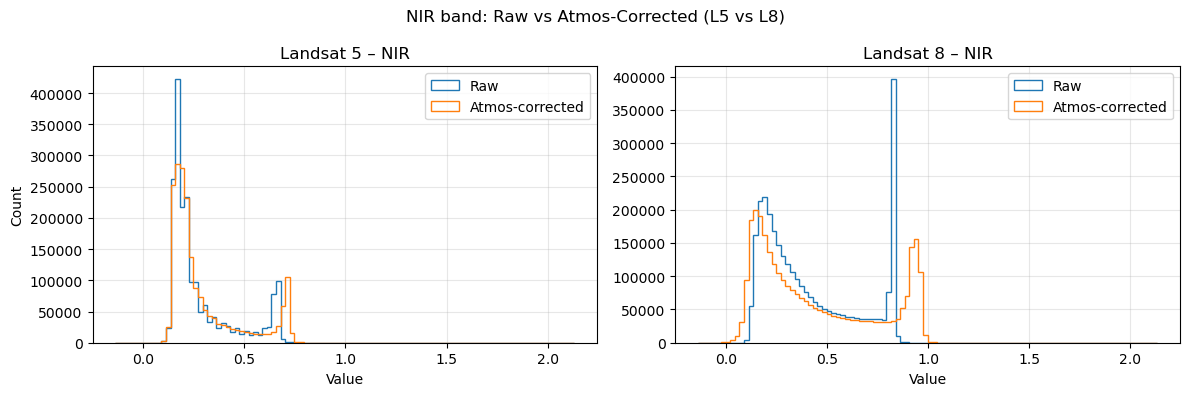

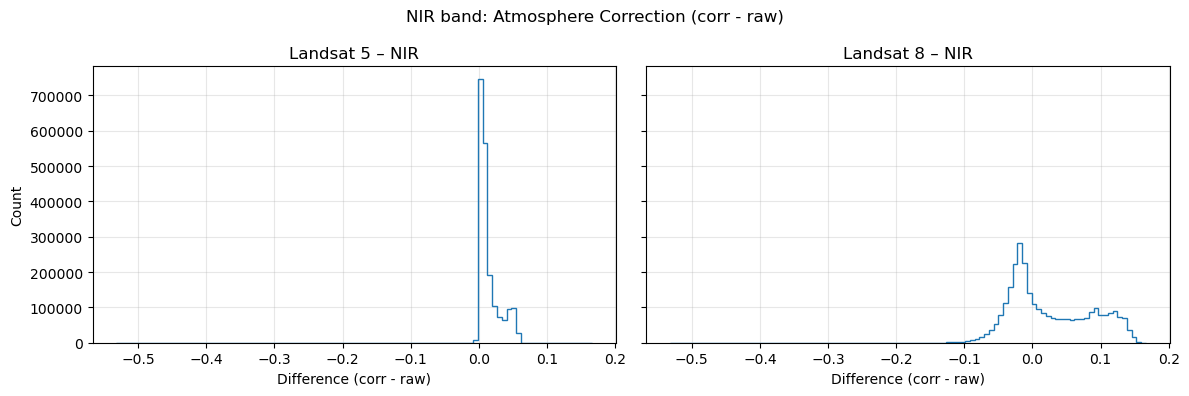


=== SWIR band (L5 band index 4, L8 band index 5) ===
  L5 raw  range: 0.00559 .. 0.39172
  L5 corr range: 0.00510 .. 0.43038
  L8 raw  range: 0.00698 .. 0.22343
  L8 corr range: -0.04221 .. 0.22889


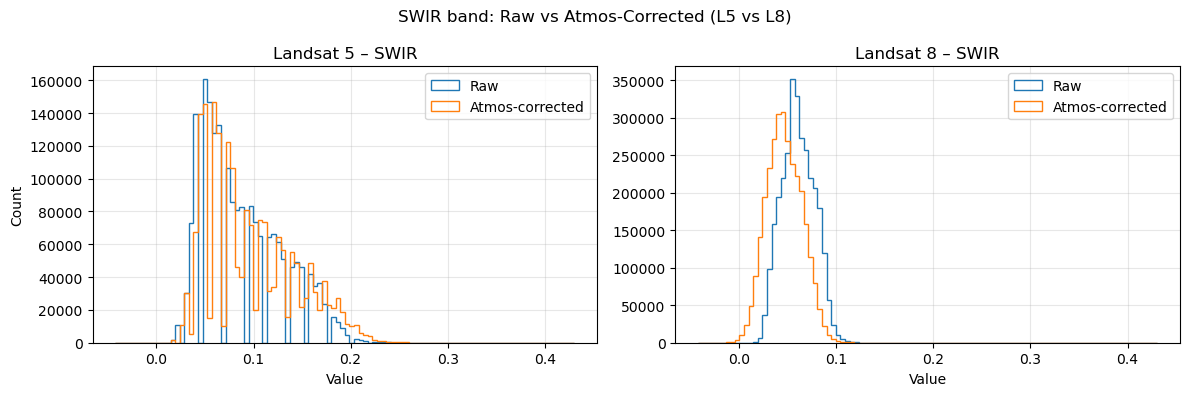

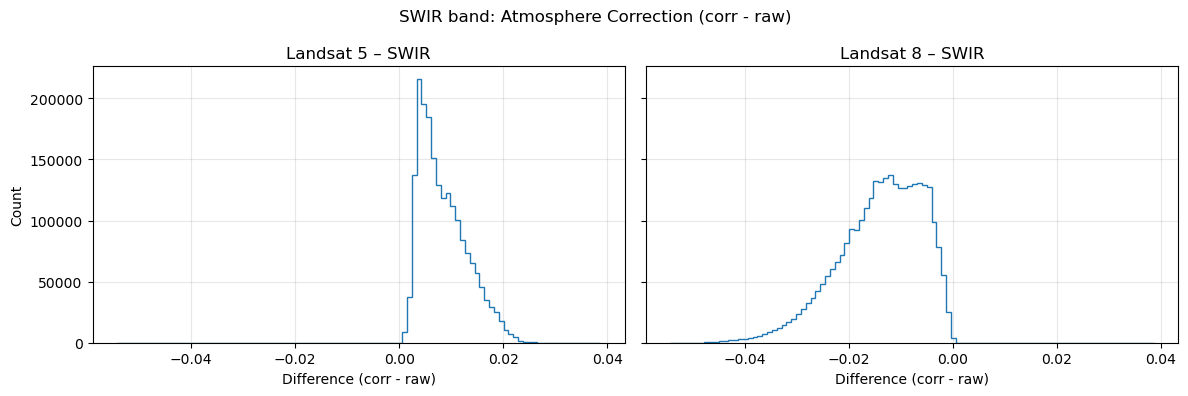

In [4]:
import numpy as np
import rioxarray
import matplotlib.pyplot as plt

# ----------- USER SETTINGS -----------
# Landsat 5 (older)
L5_RAW_TIF  = "../scratch/data/landsat_klein_original_L1_GEE/TOA/Landsat5_klein100_LT05_L1TP_037023_19940206_20200913_02_T1.tif"
L5_CORR_TIF = "../scratch/data/landsat_klein_original_L2_GEE/SR/Landsat5_klein100_LT05_L2SP_037023_19940206_20200913_02_T1.tif"

# Landsat 8 (newer)
L8_RAW_TIF  = "../scratch/data/landsat_klein_now_L1_GEE/TOA/Landsat8_klein100_LC08_L1TP_038022_20190306_20200829_02_T1.tif"
L8_CORR_TIF = "../scratch/data/landsat_klein_now_L2_GEE/SR/Landsat8_klein100_LC08_L2SP_038022_20190306_20200829_02_T1.tif"

# Index positions in the stacks (0-based) for each spectral band:
# Landsat 5: use bands 0,1,2,3,4  -> (Blue, Green, Red, NIR, SWIR)
L5_BAND_IDXS = [0, 1, 2, 3, 4]

# Landsat 8: use bands 1,2,3,4,5 -> (Blue, Green, Red, NIR, SWIR)
# (i.e. skip band 0 if it's coastal; adjust if your stack is different)
L8_BAND_IDXS = [1, 2, 3, 4, 5]

BAND_LABELS = ["Blue", "Green", "Red", "NIR", "SWIR"]
N_BINS = 100
# -------------------------------------


def load_stack(path):
    da = rioxarray.open_rasterio(path, masked=True).squeeze()
    if "band" not in da.dims:
        raise ValueError(f"{path} has no 'band' dimension.")
    return da


def main():
    # ---- Load stacks ----
    l5_raw  = load_stack(L5_RAW_TIF)
    l5_corr = load_stack(L5_CORR_TIF)
    l8_raw  = load_stack(L8_RAW_TIF)
    l8_corr = load_stack(L8_CORR_TIF)

    print("Landsat 5 raw shape:",  l5_raw.shape)
    print("Landsat 5 corr shape:", l5_corr.shape)
    print("Landsat 8 raw shape:",  l8_raw.shape)
    print("Landsat 8 corr shape:", l8_corr.shape)

    # ---- Basic sanity checks on band counts ----
    max_l5_idx = max(L5_BAND_IDXS)
    max_l8_idx = max(L8_BAND_IDXS)
    if max_l5_idx >= l5_raw.sizes["band"] or max_l5_idx >= l5_corr.sizes["band"]:
        raise IndexError(f"Landsat 5 band index out of range: {max_l5_idx}")
    if max_l8_idx >= l8_raw.sizes["band"] or max_l8_idx >= l8_corr.sizes["band"]:
        raise IndexError(f"Landsat 8 band index out of range: {max_l8_idx}")

    # ---- Ensure spatial shapes match within each sensor ----
    if l5_raw.shape[1:] != l5_corr.shape[1:]:
        raise ValueError(
            f"Landsat 5 spatial mismatch: raw {l5_raw.shape[1:]}, corr {l5_corr.shape[1:]}."
        )
    if l8_raw.shape[1:] != l8_corr.shape[1:]:
        raise ValueError(
            f"Landsat 8 spatial mismatch: raw {l8_raw.shape[1:]}, corr {l8_corr.shape[1:]}."
        )

    l5_raw_nodata  = l5_raw.rio.nodata
    l5_corr_nodata = l5_corr.rio.nodata
    l8_raw_nodata  = l8_raw.rio.nodata
    l8_corr_nodata = l8_corr.rio.nodata

    # ---- Loop over logical bands (Blue, Green, Red, NIR, SWIR) ----
    for band_label, l5_idx, l8_idx in zip(BAND_LABELS, L5_BAND_IDXS, L8_BAND_IDXS):
        print(f"\n=== {band_label} band (L5 band index {l5_idx}, L8 band index {l8_idx}) ===")

        # ----- Extract bands as float32 -----
        l5_raw_band  = l5_raw.isel(band=l5_idx).values.astype("float32")
        l5_corr_band = l5_corr.isel(band=l5_idx).values.astype("float32")
        l8_raw_band  = l8_raw.isel(band=l8_idx).values.astype("float32")
        l8_corr_band = l8_corr.isel(band=l8_idx).values.astype("float32")

        # ----- Masks -----
        l5_mask = np.isfinite(l5_raw_band) & np.isfinite(l5_corr_band)
        if l5_raw_nodata is not None:
            l5_mask &= l5_raw_band != l5_raw_nodata
        if l5_corr_nodata is not None:
            l5_mask &= l5_corr_band != l5_corr_nodata

        l8_mask = np.isfinite(l8_raw_band) & np.isfinite(l8_corr_band)
        if l8_raw_nodata is not None:
            l8_mask &= l8_raw_band != l8_raw_nodata
        if l8_corr_nodata is not None:
            l8_mask &= l8_corr_band != l8_corr_nodata

        l5_raw_valid  = l5_raw_band[l5_mask]
        l5_corr_valid = l5_corr_band[l5_mask]
        l8_raw_valid  = l8_raw_band[l8_mask]
        l8_corr_valid = l8_corr_band[l8_mask]

        if l5_raw_valid.size == 0 or l8_raw_valid.size == 0:
            print("One of the sensors is empty after masking — skipping this band.")
            continue

        # ----- Shared value range across both sensors -----
        vmin = float(
            min(l5_raw_valid.min(), l5_corr_valid.min(),
                l8_raw_valid.min(), l8_corr_valid.min())
        )
        vmax = float(
            max(l5_raw_valid.max(), l5_corr_valid.max(),
                l8_raw_valid.max(), l8_corr_valid.max())
        )

        print(f"  L5 raw  range: {l5_raw_valid.min():.5f} .. {l5_raw_valid.max():.5f}")
        print(f"  L5 corr range: {l5_corr_valid.min():.5f} .. {l5_corr_valid.max():.5f}")
        print(f"  L8 raw  range: {l8_raw_valid.min():.5f} .. {l8_raw_valid.max():.5f}")
        print(f"  L8 corr range: {l8_corr_valid.min():.5f} .. {l8_corr_valid.max():.5f}")

        # ---------- overlay hist: L5 vs L8 side by side ----------
        fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=False)
        ax_l5, ax_l8 = axes

        ax_l5.hist(l5_raw_valid,  bins=N_BINS, range=(vmin, vmax),
                   histtype="step", label="Raw")
        ax_l5.hist(l5_corr_valid, bins=N_BINS, range=(vmin, vmax),
                   histtype="step", label="Atmos-corrected")
        ax_l5.set_title(f"Landsat 5 – {band_label}")
        ax_l5.set_xlabel("Value")
        ax_l5.set_ylabel("Count")
        ax_l5.grid(alpha=0.3)
        ax_l5.legend()

        ax_l8.hist(l8_raw_valid,  bins=N_BINS, range=(vmin, vmax),
                   histtype="step", label="Raw")
        ax_l8.hist(l8_corr_valid, bins=N_BINS, range=(vmin, vmax),
                   histtype="step", label="Atmos-corrected")
        ax_l8.set_title(f"Landsat 8 – {band_label}")
        ax_l8.set_xlabel("Value")
        ax_l8.grid(alpha=0.3)
        ax_l8.legend()

        fig.suptitle(f"{band_label} band: Raw vs Atmos-Corrected (L5 vs L8)")
        plt.tight_layout()
        plt.show()

        # ---------- difference hist (corr - raw): L5 vs L8 side by side ----------
        l5_diff = l5_corr_valid - l5_raw_valid
        l8_diff = l8_corr_valid - l8_raw_valid

        diff_min = float(min(l5_diff.min(), l8_diff.min()))
        diff_max = float(max(l5_diff.max(), l8_diff.max()))

        fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
        ax_l5_diff, ax_l8_diff = axes

        ax_l5_diff.hist(l5_diff, bins=N_BINS, range=(diff_min, diff_max), histtype="step")
        ax_l5_diff.set_title(f"Landsat 5 – {band_label}")
        ax_l5_diff.set_xlabel("Difference (corr - raw)")
        ax_l5_diff.set_ylabel("Count")
        ax_l5_diff.grid(alpha=0.3)

        ax_l8_diff.hist(l8_diff, bins=N_BINS, range=(diff_min, diff_max), histtype="step")
        ax_l8_diff.set_title(f"Landsat 8 – {band_label}")
        ax_l8_diff.set_xlabel("Difference (corr - raw)")
        ax_l8_diff.grid(alpha=0.3)

        fig.suptitle(f"{band_label} band: Atmosphere Correction (corr - raw)")
        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    main()


Found 5 pairs in TOA vs SR
  037023_19940206_20200913_02:
    TOA: Landsat5_klein100_LT05_L1TP_037023_19940206_20200913_02_T1.tif
    SR : Landsat5_klein100_LT05_L2SP_037023_19940206_20200913_02_T1.tif
  037023_19950329_20200912_02:
    TOA: Landsat5_klein100_LT05_L1TP_037023_19950329_20200912_02_T1.tif
    SR : Landsat5_klein100_LT05_L2SP_037023_19950329_20200912_02_T1.tif
  038022_19930210_20200914_02:
    TOA: Landsat5_klein100_LT05_L1TP_038022_19930210_20200914_02_T1.tif
    SR : Landsat5_klein100_LT05_L2SP_038022_19930210_20200914_02_T1.tif
  038022_19930226_20200914_02:
    TOA: Landsat5_klein100_LT05_L1TP_038022_19930226_20200914_02_T1.tif
    SR : Landsat5_klein100_LT05_L2SP_038022_19930226_20200914_02_T1.tif
  038022_19940301_20200913_02:
    TOA: Landsat5_klein100_LT05_L1TP_038022_19940301_20200913_02_T1.tif
    SR : Landsat5_klein100_LT05_L2SP_038022_19940301_20200913_02_T1.tif
Found 9 pairs in TOA vs SR
  037023_20210216_20210301_02:
    TOA: Landsat8_klein100_LC08_L1TP_037

/tmp/ipykernel_1658577/1173376941.py:239: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("tab20")


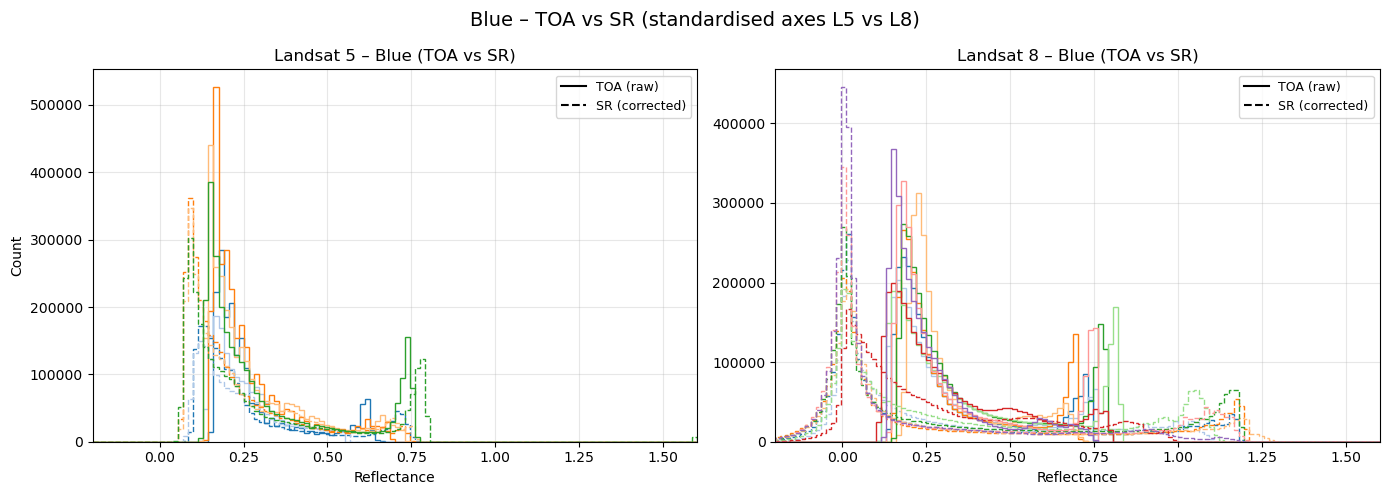

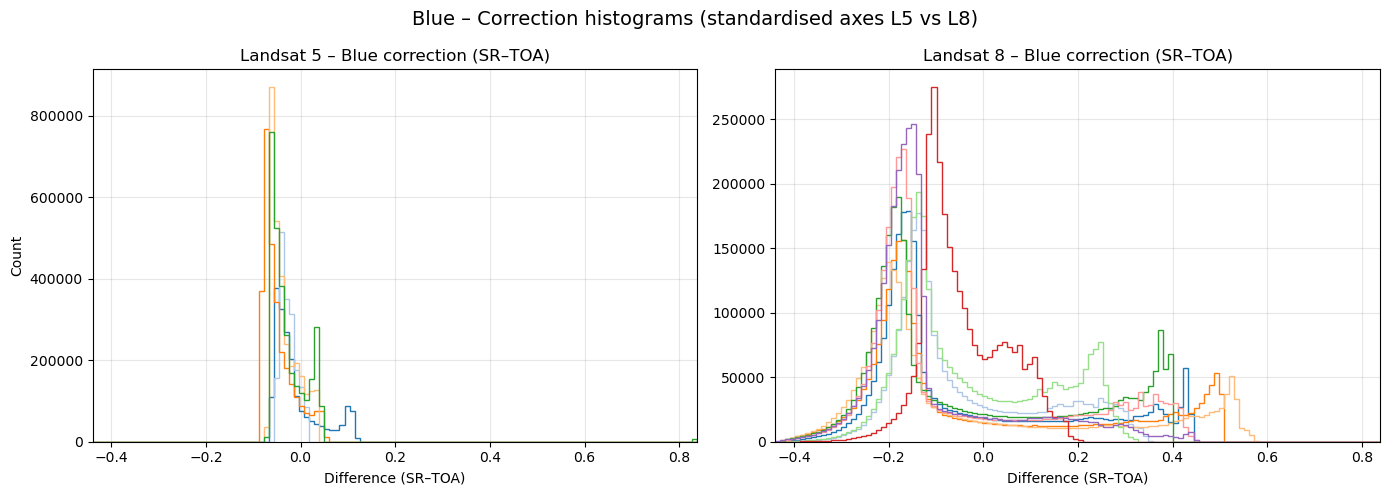

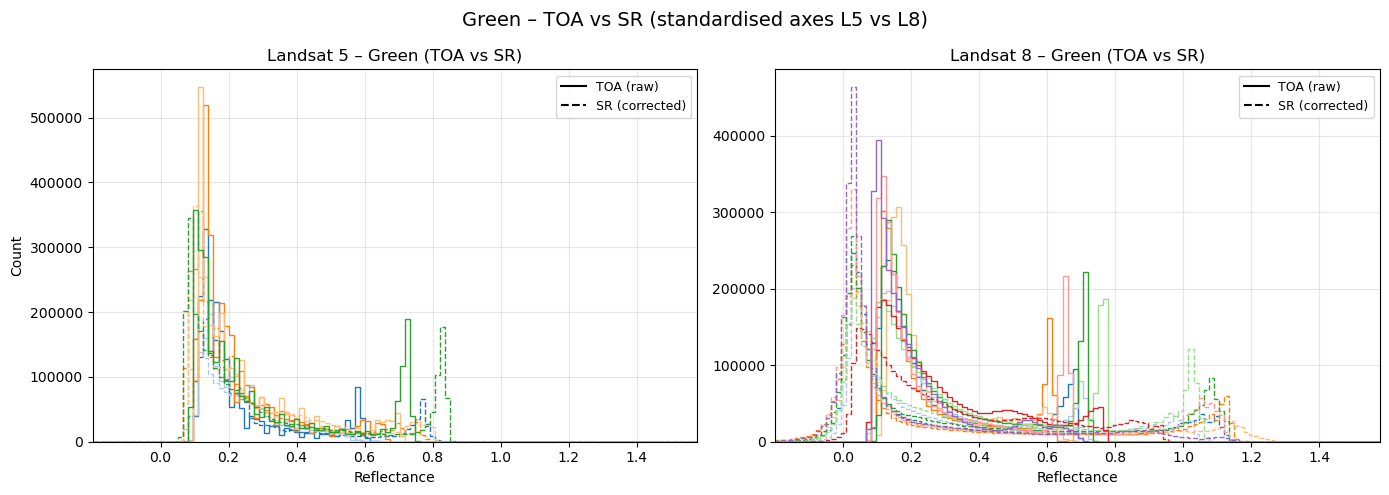

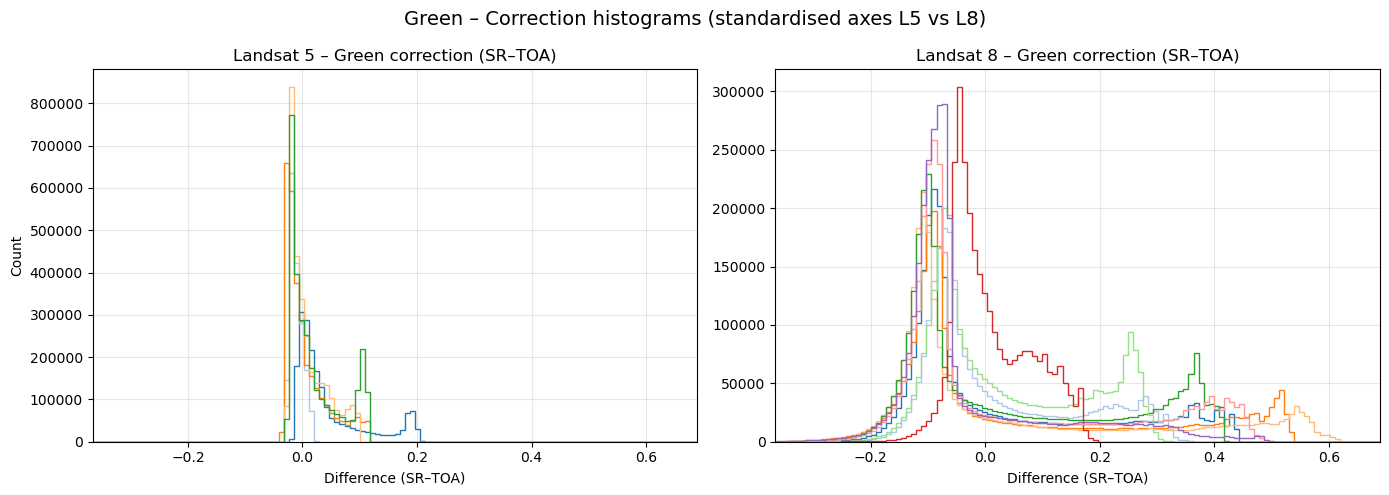

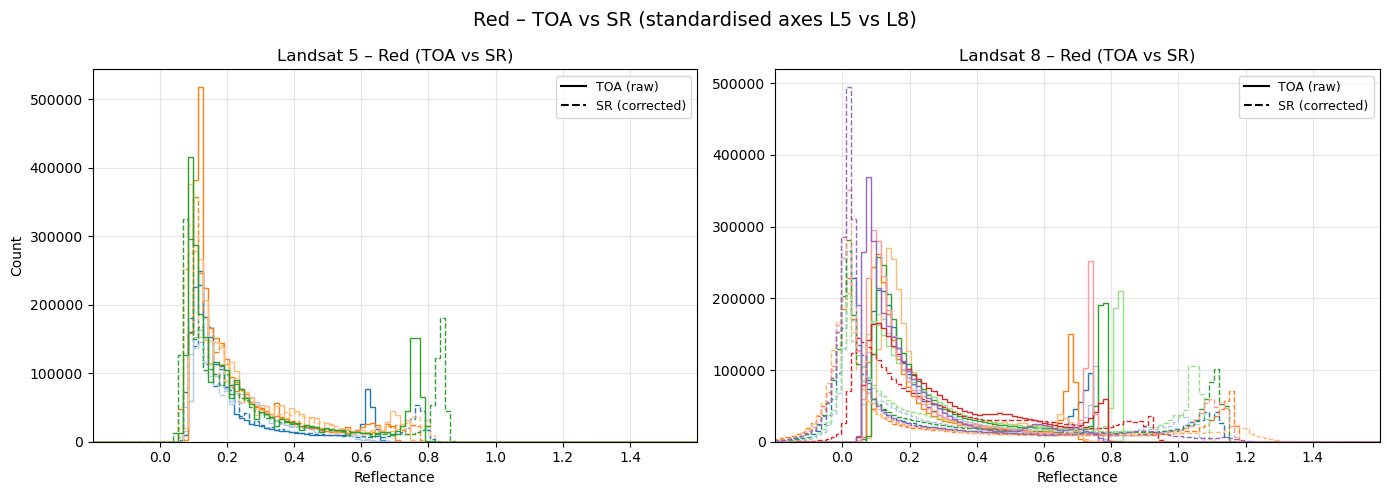

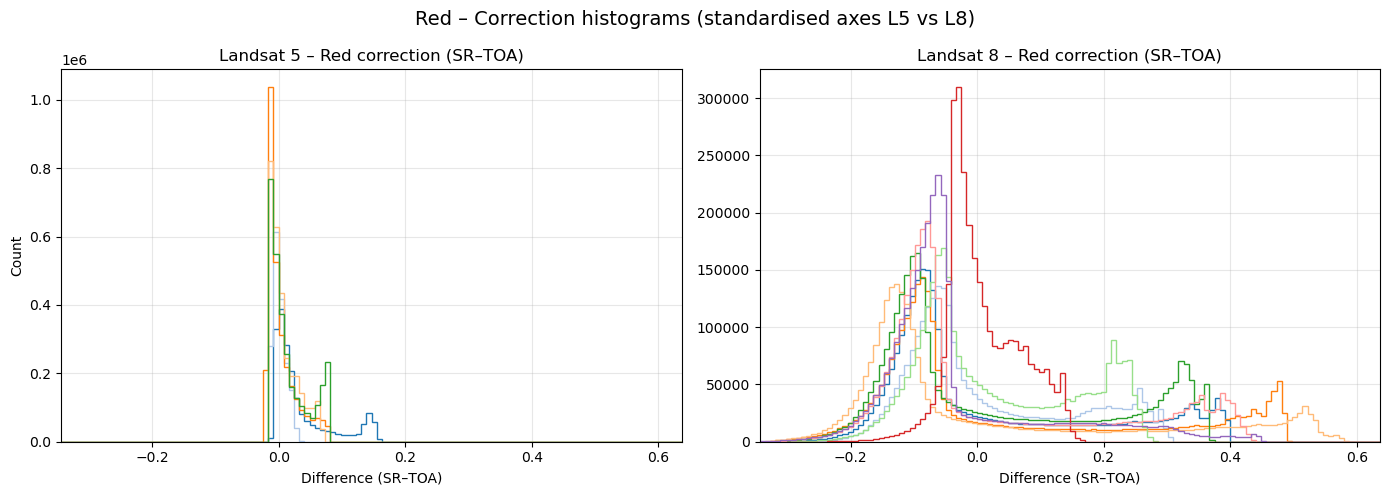

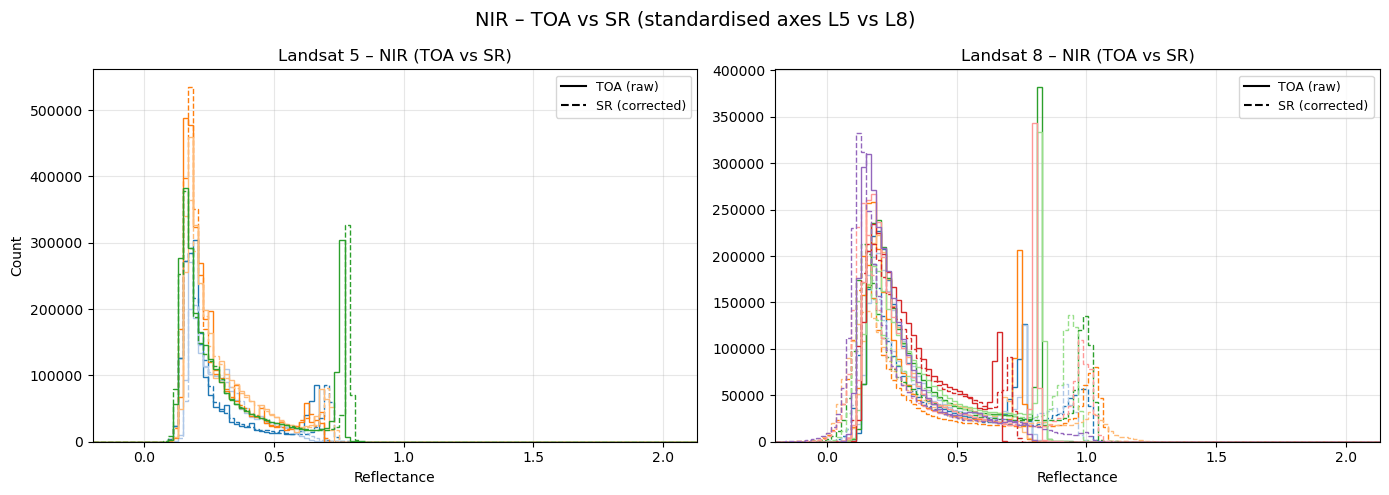

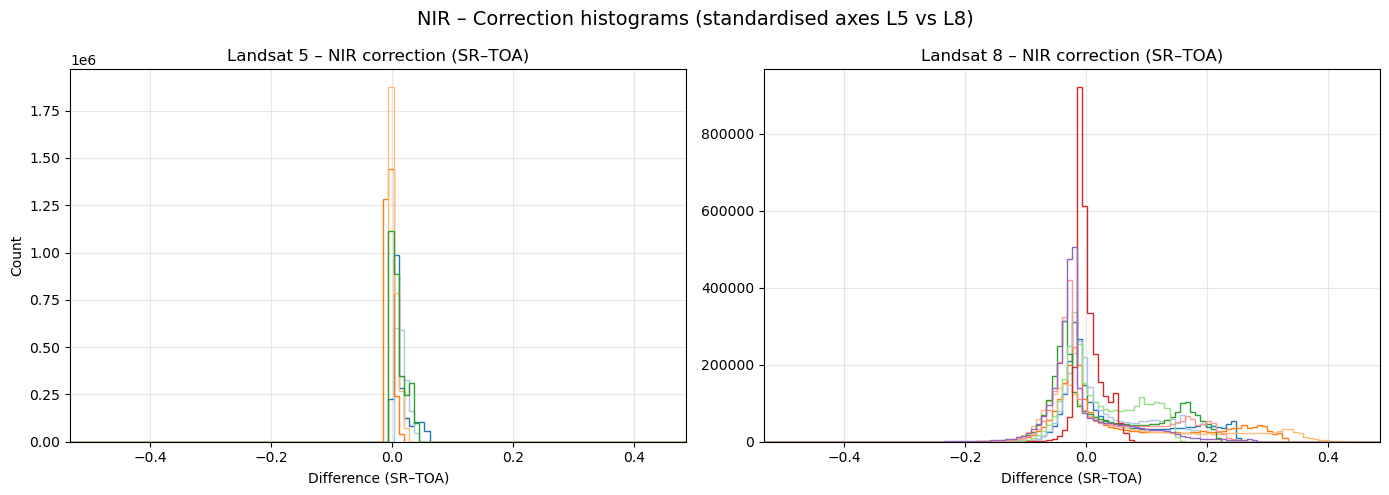

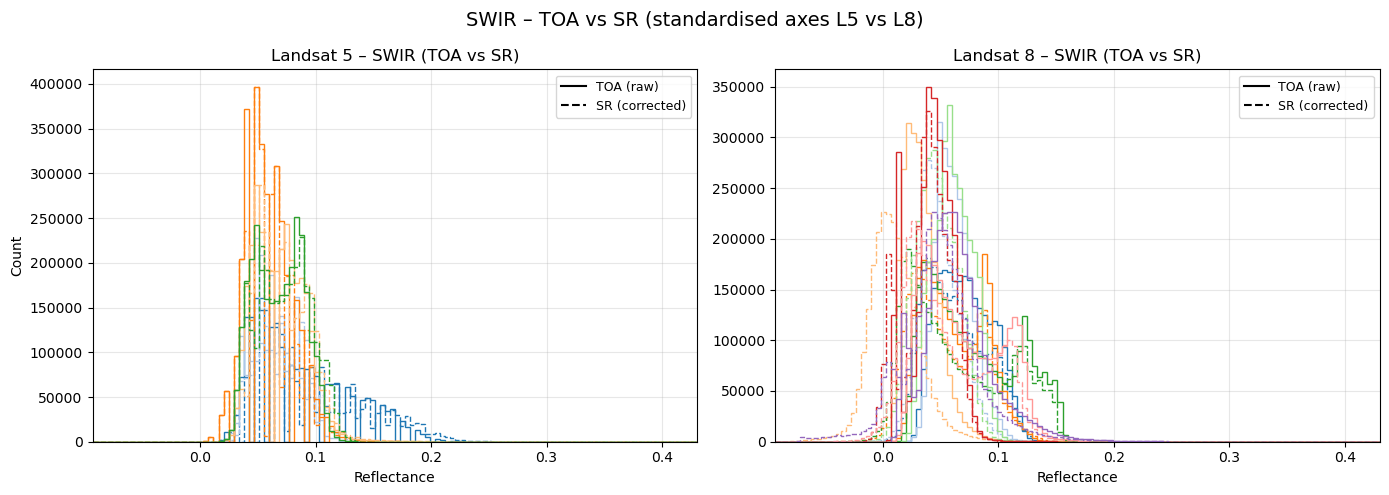

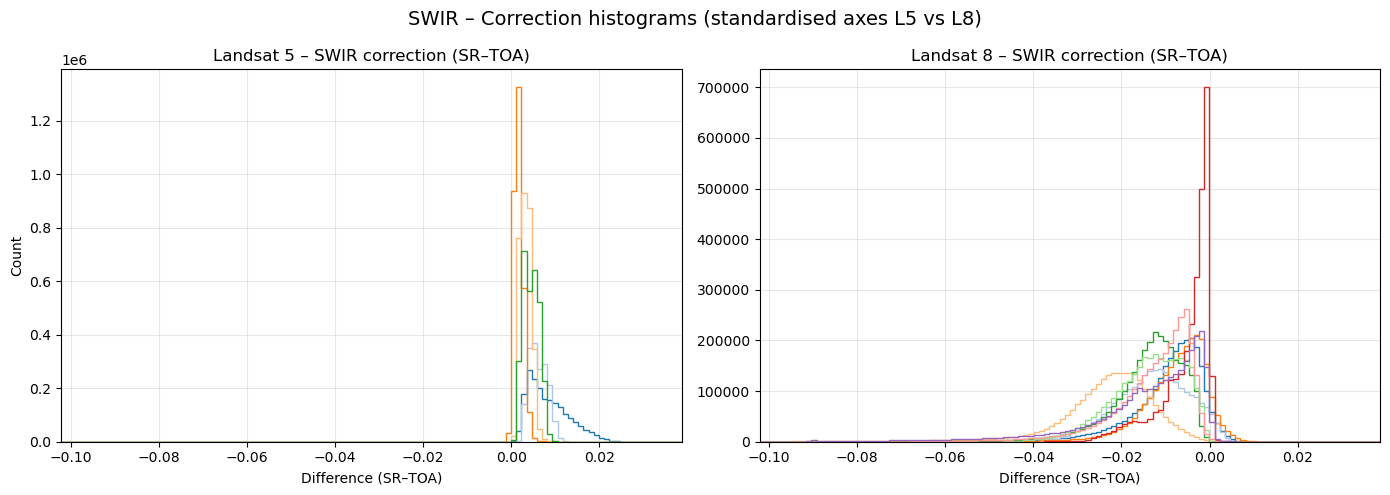

Combined NDSI range before clipping: [-10.00, 10.00]
Combined NDSI diff range before clipping: [-10.86, 9.84]


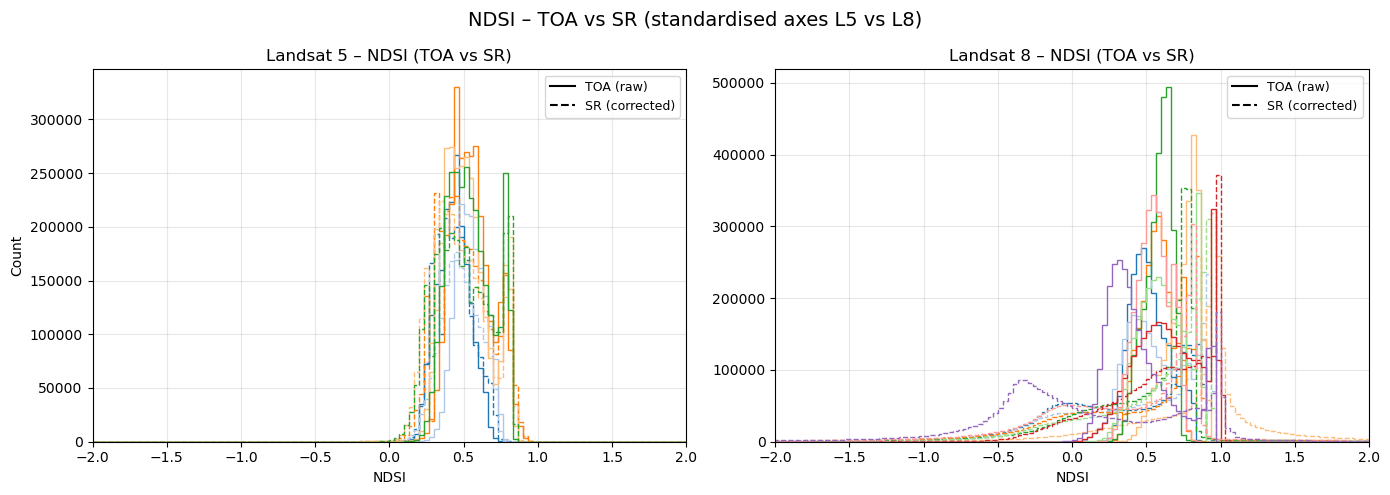

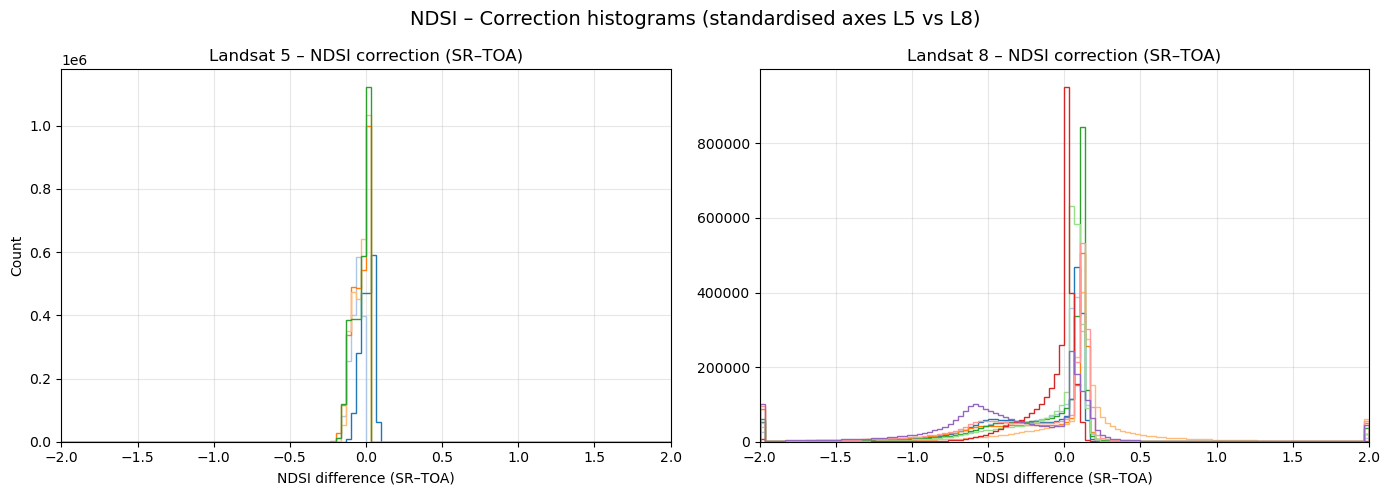

In [2]:
import re
from pathlib import Path
import numpy as np
import rioxarray
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.lines as mlines

# ================= USER SETTINGS =================
BASE_DIR = Path("../scratch/data")

# Landsat 5
L5_RAW_DIR  = BASE_DIR / "landsat_klein_original_L1_GEE" / "TOA"
L5_CORR_DIR = BASE_DIR / "landsat_klein_original_L2_GEE" / "SR"

# Landsat 8
L8_RAW_DIR  = BASE_DIR / "landsat_klein_now_L1_GEE" / "TOA"
L8_CORR_DIR = BASE_DIR / "landsat_klein_now_L2_GEE" / "SR"

# Only consider files that contain this substring
FILENAME_FILTER = "klein100"

# Regex to extract the common ID block, e.g. 037023_19940206_20200913_02
ID_REGEX = re.compile(r"(\d{6}_\d{8}_\d{8}_\d{2})")

# Band mappings (0-based indices in the stack)
# Landsat 5: blue–SWIR are bands 0–4 in this stack
L5_BAND_IDXS = [0, 1, 2, 3, 4]     # Blue, Green, Red, NIR, SWIR

# Landsat 8: we use bands 1–5 (skip coastal)
L8_BAND_IDXS = [1, 2, 3, 4, 5]     # Blue, Green, Red, NIR, SWIR

BAND_LABELS  = ["Blue", "Green", "Red", "NIR", "SWIR"]

# NDSI indices (0-based in the same stack as above)
# NDSI = (Green - SWIR1) / (Green + SWIR1)
L5_NDSI_GREEN_IDX = 1  # Green
L5_NDSI_SWIR_IDX  = 4  # SWIR1

L8_NDSI_GREEN_IDX = 2  # Green (Band 3)
L8_NDSI_SWIR_IDX  = 5  # SWIR1 (Band 6)

N_BINS = 120
MAX_PIX = None   # e.g. 1_000_000 to subsample for speed; or None for all pixels

# Reasonable range for physical NDSI (mostly -1..1)
NDSI_PLOT_MIN = -2.0
NDSI_PLOT_MAX =  2.0
NDSI_OUTLIER_ABS_MAX = 10.0   # drop anything with |NDSI| > this
# ==================================================


def load_stack(path: Path):
    da = rioxarray.open_rasterio(path, masked=True).squeeze()
    if "band" not in da.dims:
        raise ValueError(f"{path} has no 'band' dimension.")
    return da


def find_pairs(raw_dir: Path, corr_dir: Path):
    """Find matching TOA/SR files by common ID block in filenames."""
    def idx(folder: Path):
        m = {}
        for f in folder.glob("*.tif"):
            if FILENAME_FILTER not in f.name:
                continue
            mo = ID_REGEX.search(f.name)
            if mo:
                m[mo.group(1)] = f
        return m

    raw_map  = idx(raw_dir)
    corr_map = idx(corr_dir)
    common   = sorted(set(raw_map) & set(corr_map))

    pairs = [(cid, raw_map[cid], corr_map[cid]) for cid in common]
    print(f"Found {len(pairs)} pairs in {raw_dir.name} vs {corr_dir.name}")
    for cid, r, c in pairs:
        print(f"  {cid}:")
        print(f"    TOA: {r.name}")
        print(f"    SR : {c.name}")
    return pairs


def load_scenes(pair_list):
    scenes = []
    for sid, raw_path, corr_path in pair_list:
        raw  = load_stack(raw_path)
        corr = load_stack(corr_path)
        if raw.shape[1:] != corr.shape[1:]:
            raise ValueError(f"Spatial mismatch for {sid}: {raw.shape[1:]} vs {corr.shape[1:]}")
        scenes.append((sid, raw, corr))
    return scenes


def extract_valid(raw, corr, nodata_raw, nodata_corr, band_idx):
    r = raw.isel(band=band_idx).values.astype("float32")
    c = corr.isel(band=band_idx).values.astype("float32")

    mask = np.isfinite(r) & np.isfinite(c)
    if nodata_raw is not None:
        mask &= (r != nodata_raw)
    if nodata_corr is not None:
        mask &= (c != nodata_corr)

    r = r[mask]
    c = c[mask]

    if MAX_PIX and r.size > MAX_PIX:
        idx = np.linspace(0, r.size - 1, MAX_PIX, dtype=int)
        r = r[idx]
        c = c[idx]

    return r, c


def process_sensor_pairs(scenes, band_indices):
    """
    Returns dict: band_label -> list of {id, raw, corr} (flattened arrays).
    """
    result = {}

    for band_label, bidx in zip(BAND_LABELS, band_indices):
        rows = []
        for sid, raw, corr in scenes:
            rv, cv = extract_valid(raw, corr, raw.rio.nodata, corr.rio.nodata, bidx)
            if rv.size == 0:
                continue
            rows.append({"id": sid, "raw": rv, "corr": cv})
        result[band_label] = rows

    return result


def compute_ndsi_for_scenes(scenes, green_idx, swir_idx):
    """
    Compute NDSI for each scene:
      NDSI = (Green - SWIR) / (Green + SWIR)

    Returns list of dicts:
        { "id": scene_id, "raw": ndsi_raw_flat, "corr": ndsi_corr_flat }
    """
    rows = []
    for sid, raw, corr in scenes:
        g_raw  = raw.isel(band=green_idx).values.astype("float32")
        s_raw  = raw.isel(band=swir_idx).values.astype("float32")
        g_corr = corr.isel(band=green_idx).values.astype("float32")
        s_corr = corr.isel(band=swir_idx).values.astype("float32")

        # Common mask across all four arrays
        mask = (
            np.isfinite(g_raw) & np.isfinite(s_raw) &
            np.isfinite(g_corr) & np.isfinite(s_corr)
        )
        nodata_raw  = raw.rio.nodata
        nodata_corr = corr.rio.nodata
        if nodata_raw is not None:
            mask &= (g_raw != nodata_raw) & (s_raw != nodata_raw)
        if nodata_corr is not None:
            mask &= (g_corr != nodata_corr) & (s_corr != nodata_corr)

        g_raw  = g_raw[mask]
        s_raw  = s_raw[mask]
        g_corr = g_corr[mask]
        s_corr = s_corr[mask]

        if g_raw.size == 0:
            continue

        with np.errstate(divide="ignore", invalid="ignore"):
            ndsi_raw  = (g_raw  - s_raw)  / (g_raw  + s_raw)
            ndsi_corr = (g_corr - s_corr) / (g_corr + s_corr)

        # Filter NaNs / inf
        valid = np.isfinite(ndsi_raw) & np.isfinite(ndsi_corr)
        ndsi_raw  = ndsi_raw[valid]
        ndsi_corr = ndsi_corr[valid]

        # Drop utterly crazy outliers (probably bad pixels / edges)
        keep = (np.abs(ndsi_raw) <= NDSI_OUTLIER_ABS_MAX) & \
               (np.abs(ndsi_corr) <= NDSI_OUTLIER_ABS_MAX)
        ndsi_raw  = ndsi_raw[keep]
        ndsi_corr = ndsi_corr[keep]

        if ndsi_raw.size == 0:
            continue

        if MAX_PIX and ndsi_raw.size > MAX_PIX:
            idx = np.linspace(0, ndsi_raw.size - 1, MAX_PIX, dtype=int)
            ndsi_raw  = ndsi_raw[idx]
            ndsi_corr = ndsi_corr[idx]

        # Print a quick sanity check per scene
        print(
            f"NDSI {sid}: raw [{ndsi_raw.min():.2f}, {ndsi_raw.max():.2f}], "
            f"corr [{ndsi_corr.min():.2f}, {ndsi_corr.max():.2f}]"
        )

        rows.append({"id": sid, "raw": ndsi_raw, "corr": ndsi_corr})

    return rows


def collect_all_vals(scene_rows):
    if not scene_rows:
        return np.array([]), np.array([])
    all_r = np.concatenate([s["raw"] for s in scene_rows])
    all_c = np.concatenate([s["corr"] for s in scene_rows])
    return all_r, all_c


def collect_all_diffs(scene_rows):
    if not scene_rows:
        return np.array([])
    return np.concatenate([s["corr"] - s["raw"] for s in scene_rows])


# ========================================================
#                        MAIN
# ========================================================
def main():
    # ----- find and load pairs -----
    l5_pairs = find_pairs(L5_RAW_DIR, L5_CORR_DIR)
    l8_pairs = find_pairs(L8_RAW_DIR, L8_CORR_DIR)

    print(f"L5 scenes: {len(l5_pairs)}, L8 scenes: {len(l8_pairs)}")

    l5_scenes = load_scenes(l5_pairs)
    l8_scenes = load_scenes(l8_pairs)

    # Per-band reflectance data
    l5_data = process_sensor_pairs(l5_scenes, L5_BAND_IDXS)
    l8_data = process_sensor_pairs(l8_scenes, L8_BAND_IDXS)

    # NDSI data
    l5_ndsi = compute_ndsi_for_scenes(l5_scenes, L5_NDSI_GREEN_IDX, L5_NDSI_SWIR_IDX)
    l8_ndsi = compute_ndsi_for_scenes(l8_scenes, L8_NDSI_GREEN_IDX, L8_NDSI_SWIR_IDX)

    cmap = get_cmap("tab20")

    # ========================================================
    #          PER-BAND SIDE-BY-SIDE PLOTS (L5 vs L8)
    # ========================================================
    for band_label in BAND_LABELS:
        l5_rows = l5_data[band_label]
        l8_rows = l8_data[band_label]

        # ----- joint x-range for TOA/SR -----
        l5_r, l5_c = collect_all_vals(l5_rows)
        l8_r, l8_c = collect_all_vals(l8_rows)

        arrays = [a for a in (l5_r, l5_c, l8_r, l8_c) if a.size]
        if not arrays:
            print(f"No data for band {band_label}, skipping.")
            continue
        combined_vals = np.concatenate(arrays)
        vmin = float(combined_vals.min())
        vmax = float(combined_vals.max())

        # ----- joint x-range for DIFFS -----
        l5_diff = collect_all_diffs(l5_rows)
        l8_diff = collect_all_diffs(l8_rows)
        diff_arrays = [a for a in (l5_diff, l8_diff) if a.size]
        combined_diffs = np.concatenate(diff_arrays)
        dmin = float(combined_diffs.min())
        dmax = float(combined_diffs.max())

        # ========================================================
        #            TOA vs SR PLOTS (WITH SIMPLE LEGEND)
        # ========================================================
        fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)
        ax_l5, ax_l8 = axes

        ax_l5.set_title(f"Landsat 5 – {band_label} (TOA vs SR)")
        ax_l8.set_title(f"Landsat 8 – {band_label} (TOA vs SR)")

        # ---- L5 ----
        for j, s in enumerate(l5_rows):
            colour = cmap(j % 20)
            ax_l5.hist(s["raw"],  bins=N_BINS, range=(vmin, vmax),
                       histtype="step", color=colour)
            ax_l5.hist(s["corr"], bins=N_BINS, range=(vmin, vmax),
                       histtype="step", color=colour, linestyle="--")
        ax_l5.grid(alpha=0.3)
        ax_l5.set_xlabel("Reflectance")
        ax_l5.set_ylabel("Count")
        ax_l5.set_xlim(vmin, vmax)

        # ---- L8 ----
        for j, s in enumerate(l8_rows):
            colour = cmap(j % 20)
            ax_l8.hist(s["raw"],  bins=N_BINS, range=(vmin, vmax),
                       histtype="step", color=colour)
            ax_l8.hist(s["corr"], bins=N_BINS, range=(vmin, vmax),
                       histtype="step", color=colour, linestyle="--")
        ax_l8.grid(alpha=0.3)
        ax_l8.set_xlabel("Reflectance")
        ax_l8.set_xlim(vmin, vmax)

        # Simple legend: solid vs dashed
        line_raw = mlines.Line2D([], [], color='black', linestyle='-',  label='TOA (raw)')
        line_sr  = mlines.Line2D([], [], color='black', linestyle='--', label='SR (corrected)')
        ax_l5.legend(handles=[line_raw, line_sr], fontsize=9, loc='upper right')
        ax_l8.legend(handles=[line_raw, line_sr], fontsize=9, loc='upper right')

        fig.suptitle(f"{band_label} – TOA vs SR (standardised axes L5 vs L8)", fontsize=14)
        plt.tight_layout()
        plt.show()

        # ========================================================
        #                 DIFFERENCE PLOTS (SR–TOA)
        # ========================================================
        fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)
        ax_l5, ax_l8 = axes

        ax_l5.set_title(f"Landsat 5 – {band_label} correction (SR–TOA)")
        for j, s in enumerate(l5_rows):
            colour = cmap(j % 20)
            diff = s["corr"] - s["raw"]
            ax_l5.hist(diff, bins=N_BINS, range=(dmin, dmax),
                       histtype="step", color=colour)
        ax_l5.grid(alpha=0.3)
        ax_l5.set_xlabel("Difference (SR–TOA)")
        ax_l5.set_ylabel("Count")
        ax_l5.set_xlim(dmin, dmax)

        ax_l8.set_title(f"Landsat 8 – {band_label} correction (SR–TOA)")
        for j, s in enumerate(l8_rows):
            colour = cmap(j % 20)
            diff = s["corr"] - s["raw"]
            ax_l8.hist(diff, bins=N_BINS, range=(dmin, dmax),
                       histtype="step", color=colour)
        ax_l8.grid(alpha=0.3)
        ax_l8.set_xlabel("Difference (SR–TOA)")
        ax_l8.set_xlim(dmin, dmax)

        fig.suptitle(f"{band_label} – Correction histograms (standardised axes L5 vs L8)", fontsize=14)
        plt.tight_layout()
        plt.show()

    # ========================================================
    #                     NDSI PLOTS
    # ========================================================
    if l5_ndsi or l8_ndsi:
        band_label = "NDSI"

        # joint NDSI range (then clamp to NDSI_PLOT_MIN/MAX)
        l5_r, l5_c = collect_all_vals(l5_ndsi)
        l8_r, l8_c = collect_all_vals(l8_ndsi)
        arrays = [a for a in (l5_r, l5_c, l8_r, l8_c) if a.size]
        combined_vals = np.concatenate(arrays)

        raw_min = float(combined_vals.min())
        raw_max = float(combined_vals.max())
        print(f"Combined NDSI range before clipping: [{raw_min:.2f}, {raw_max:.2f}]")

        vmin = max(NDSI_PLOT_MIN, raw_min)
        vmax = min(NDSI_PLOT_MAX, raw_max)

        # joint diff range, also clip to something reasonable
        l5_diff = collect_all_diffs(l5_ndsi)
        l8_diff = collect_all_diffs(l8_ndsi)
        diff_arrays = [a for a in (l5_diff, l8_diff) if a.size]
        combined_diffs = np.concatenate(diff_arrays)

        diff_min_raw = float(combined_diffs.min())
        diff_max_raw = float(combined_diffs.max())
        print(f"Combined NDSI diff range before clipping: "
              f"[{diff_min_raw:.2f}, {diff_max_raw:.2f}]")

        # For differences, typical values should be small; clip to e.g. [-2, 2]
        dmin = max(-2.0, diff_min_raw)
        dmax = min( 2.0, diff_max_raw)

        # ----- NDSI TOA vs SR -----
        fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)
        ax_l5, ax_l8 = axes

        ax_l5.set_title("Landsat 5 – NDSI (TOA vs SR)")
        ax_l8.set_title("Landsat 8 – NDSI (TOA vs SR)")

        for j, s in enumerate(l5_ndsi):
            colour = cmap(j % 20)
            ax_l5.hist(s["raw"],  bins=N_BINS, range=(vmin, vmax),
                       histtype="step", color=colour)
            ax_l5.hist(s["corr"], bins=N_BINS, range=(vmin, vmax),
                       histtype="step", color=colour, linestyle="--")
        ax_l5.grid(alpha=0.3)
        ax_l5.set_xlabel("NDSI")
        ax_l5.set_ylabel("Count")
        ax_l5.set_xlim(vmin, vmax)

        for j, s in enumerate(l8_ndsi):
            colour = cmap(j % 20)
            ax_l8.hist(s["raw"],  bins=N_BINS, range=(vmin, vmax),
                       histtype="step", color=colour)
            ax_l8.hist(s["corr"], bins=N_BINS, range=(vmin, vmax),
                       histtype="step", color=colour, linestyle="--")
        ax_l8.grid(alpha=0.3)
        ax_l8.set_xlabel("NDSI")
        ax_l8.set_xlim(vmin, vmax)

        line_raw = mlines.Line2D([], [], color='black', linestyle='-',  label='TOA (raw)')
        line_sr  = mlines.Line2D([], [], color='black', linestyle='--', label='SR (corrected)')
        ax_l5.legend(handles=[line_raw, line_sr], fontsize=9, loc='upper right')
        ax_l8.legend(handles=[line_raw, line_sr], fontsize=9, loc='upper right')

        fig.suptitle("NDSI – TOA vs SR (standardised axes L5 vs L8)", fontsize=14)
        plt.tight_layout()
        plt.show()

        # ----- NDSI correction (SR–TOA) -----
        fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)
        ax_l5, ax_l8 = axes

        ax_l5.set_title("Landsat 5 – NDSI correction (SR–TOA)")
        for j, s in enumerate(l5_ndsi):
            colour = cmap(j % 20)
            diff = s["corr"] - s["raw"]
            # clip for plotting
            diff = np.clip(diff, dmin, dmax)
            ax_l5.hist(diff, bins=N_BINS, range=(dmin, dmax),
                       histtype="step", color=colour)
        ax_l5.grid(alpha=0.3)
        ax_l5.set_xlabel("NDSI difference (SR–TOA)")
        ax_l5.set_ylabel("Count")
        ax_l5.set_xlim(dmin, dmax)

        ax_l8.set_title("Landsat 8 – NDSI correction (SR–TOA)")
        for j, s in enumerate(l8_ndsi):
            colour = cmap(j % 20)
            diff = s["corr"] - s["raw"]
            diff = np.clip(diff, dmin, dmax)
            ax_l8.hist(diff, bins=N_BINS, range=(dmin, dmax),
                       histtype="step", color=colour)
        ax_l8.grid(alpha=0.3)
        ax_l8.set_xlabel("NDSI difference (SR–TOA)")
        ax_l8.set_xlim(dmin, dmax)

        fig.suptitle("NDSI – Correction histograms (standardised axes L5 vs L8)", fontsize=14)
        plt.tight_layout()
        plt.show()



if __name__ == "__main__":
    main()


In [3]:
# RAW_TIF  = "../scratch/data/landsat_klein_original_L1_GEE/TOA/Landsat5_klein100_LT05_L1TP_037023_19950329_20200912_02_T1.tif"
# CORR_TIF = "../scratch/data/landsat_klein_original_L2_GEE/SR/Landsat5_klein100_LT05_L2SP_037023_19950329_20200912_02_T1.tif"

# RAW_TIF  = "../scratch/data/landsat_klein_original_L1_GEE/TOA/Landsat5_klein100_LT05_L1TP_037023_19940206_20200913_02_T1.tif"
# CORR_TIF = "../scratch/data/landsat_klein_original_L2_GEE/SR/Landsat5_klein100_LT05_L2SP_037023_19940206_20200913_02_T1.tif"

#  our site, 8 bins

In [14]:
from scripts.imports import *
from rasterio.enums import Resampling
from shapely.geometry import Polygon, Point
from pyproj import Transformer
import os
import re

# ------------------------------------------------------------------
# SETTINGS
# ------------------------------------------------------------------
# positions for SR bands in your stacks (already reflectance)
L7_SR_IDX = slice(0, 6)   # SR_B1..SR_B5, SR_B7
L8_SR_IDX = slice(0, 7)   # SR_B1..SR_B7

# Folder containing your *reflectance* Landsat stacks (one .tif per scene)
LANDSAT_FOLDER = '../scratch/data/landsat_oursites_L2_GEE/SR/'

# Masking data
LANDSAT_MASKING_FOLDER = '../scratch/data/landsat_masking/'

# ROI options (applied in image CRS, defined in lon/lat + metres)
USE_ROI = False        # set True to crop around a region of interest
ROI_LON = -105.90      # centre longitude (deg)
ROI_LAT = 53.92        # centre latitude (deg)
ROI_HALF_WIDTH_M = 26000   # half-width (x) in metres
ROI_HALF_HEIGHT_M = 26000  # half-height (y) in metres

# ------------------------------------------------------------------
# HELPERS
# ------------------------------------------------------------------
def _sr_slice(landsat_type):
    return L7_SR_IDX if landsat_type == 'Landsat7' else L8_SR_IDX


def extract_core_sr(landsat_da, landsat_type):
    """
    Return (blue, green, red, nir, swir1) as reflectance,
    with consistent meanings across sensors.
    Assumes input is already in reflectance space.
    """
    if landsat_type == 'Landsat7':
        # ('SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B7', ...)
        blue  = landsat_da.isel(band=0)  # SR_B1
        green = landsat_da.isel(band=1)  # SR_B2
        red   = landsat_da.isel(band=2)  # SR_B3
        nir   = landsat_da.isel(band=3)  # SR_B4
        swir1 = landsat_da.isel(band=4)  # SR_B5 (1.6 µm)
    else:
        # ('SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7', ...)
        blue  = landsat_da.isel(band=1)  # SR_B2
        green = landsat_da.isel(band=2)  # SR_B3
        red   = landsat_da.isel(band=3)  # SR_B4
        nir   = landsat_da.isel(band=4)  # SR_B5
        swir1 = landsat_da.isel(band=5)  # SR_B6 (1.6 µm)
    return blue, green, red, nir, swir1


def find_masks(folder, cam):
    corine_filepath = None
    elevation_filepath = None
    for filename in os.listdir(folder):
        if cam in filename and 'LandCover' in filename:
            corine_filepath = os.path.join(folder, filename)
        elif cam in filename and 'ALOS' in filename:
            elevation_filepath = os.path.join(folder, filename)
    if corine_filepath is None or elevation_filepath is None:
        raise FileNotFoundError(f"Could not find both LandCover and ALOS for {cam}")
    return corine_filepath, elevation_filepath


def load_and_reproject_to_landsat(source_path, match_array, band_name, method=Resampling.nearest):
    src = rioxarray.open_rasterio(source_path, masked=True).squeeze()
    src.name = band_name
    return src.rio.reproject_match(match_array, resampling=method)


def subset_roi(da, centre_lon, centre_lat, half_width_m, half_height_m):
    """
    Subset a DataArray to a rectangular ROI around (lon, lat),
    using the dataset's CRS and units (usually metres).
    """
    if da.rio.crs is None:
        raise ValueError("Dataset has no CRS; cannot subset by lon/lat.")

    transformer = Transformer.from_crs("EPSG:4326", da.rio.crs, always_xy=True)
    cx, cy = transformer.transform(centre_lon, centre_lat)

    minx = cx - half_width_m
    maxx = cx + half_width_m
    miny = cy - half_height_m
    maxy = cy + half_height_m

    return da.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)


def combine_tifs(landsat_filepath, corine_filepath, elevation_filepath,
                 landsat_type, use_roi=False):
    """
    Load Landsat reflectance stack + corine + elevation, all on the same grid.
    Optionally crop to an ROI (on the Landsat grid) before merging.
    """
    landsat = rioxarray.open_rasterio(landsat_filepath, masked=True).squeeze()
    landsat.name = "landsat"

    if use_roi:
        print("  Applying ROI crop to Landsat...")
        landsat = subset_roi(
            landsat,
            centre_lon=ROI_LON,
            centre_lat=ROI_LAT,
            half_width_m=ROI_HALF_WIDTH_M,
            half_height_m=ROI_HALF_HEIGHT_M,
        )

    # No scaling/clipping here; we assume SR is already reflectance

    corine = load_and_reproject_to_landsat(corine_filepath, landsat, "corine_landcover")
    elevation = load_and_reproject_to_landsat(elevation_filepath, landsat, "elevation")

    if use_roi:
        # corine/elevation are already reprojected to Landsat, so ROI crop
        # would be redundant here, but harmless – you can omit if you like.
        corine = subset_roi(
            corine,
            centre_lon=ROI_LON,
            centre_lat=ROI_LAT,
            half_width_m=ROI_HALF_WIDTH_M,
            half_height_m=ROI_HALF_HEIGHT_M,
        )
        elevation = subset_roi(
            elevation,
            centre_lon=ROI_LON,
            centre_lat=ROI_LAT,
            half_width_m=ROI_HALF_WIDTH_M,
            half_height_m=ROI_HALF_HEIGHT_M,
        )

    return xr.merge([landsat, corine, elevation])


def apply_valid_mask(ds, e=80):
    elevation = ds['elevation']
    corine = ds['corine_landcover']
    yc, xc = elevation.sizes['y'] // 2, elevation.sizes['x'] // 2
    centre_elev = elevation.isel(y=yc, x=xc).item()
    elev_mask = np.abs(elevation - centre_elev) <= e
    corine_mask = (corine >= 111) & (corine <= 126)
    valid_mask = elev_mask & corine_mask
    ds['valid_mask'] = valid_mask
    return ds


def compute_index(b1, b2):
    denom = b1 + b2
    return xr.where(denom != 0, (b1 - b2) / denom, np.nan)


def compute_dozier(ds, ndsi, nir):
    condition1 = (ndsi > 0.1) & (ndsi < 0.4)
    condition2 = (ndsi >= 0.4) & (nir > 0.11)
    dozier = xr.where(condition1 | condition2, 1, 0)
    return dozier.where(~np.isnan(ndsi))


def compute_klein(ndsi, ndvi, green, nir):
    region_coords = [
        (0.4, 1),
        (0.33, 0.9),
        (0.26, 0.75),
        (0.2, 0.59),
        (0.1, 0.24),  # bottom left
        (0.2, 0.2),
        (0.4, 0.1),   # top right
    ]
    polygon = Polygon(region_coords)
    klein = xr.zeros_like(ndsi)
    klein = xr.where((ndsi >= 0.4) & (nir > 0.11), 1, klein)
    ndsi_vals, ndvi_vals = ndsi.values, ndvi.values
    mask = np.zeros(ndsi.shape, dtype=bool)
    for i in range(ndsi.shape[0]):
        for j in range(ndsi.shape[1]):
            if not np.isnan(ndsi_vals[i, j]) and not np.isnan(ndvi_vals[i, j]):
                if polygon.contains(Point(ndsi_vals[i, j], ndvi_vals[i, j])):
                    mask[i, j] = True
    klein = xr.where(xr.DataArray(mask, dims=ndsi.dims, coords=ndsi.coords), 1, klein)
    klein = xr.where((green <= 0.1), 0, klein)
    return klein.where(~np.isnan(ndsi) & ~np.isnan(ndvi))


def compute_salomonson(ndsi):
    fsc = 0.06 + 1.21 * ndsi
    return fsc.clip(0, 1).where(~np.isnan(ndsi))


def normalize(img):
    img = img.transpose("y", "x", "band")
    p2 = img.quantile(0.02, dim=("x", "y"))
    p98 = img.quantile(0.98, dim=("x", "y"))
    return ((img - p2) / (p98 - p2)).clip(0, 1)


def plot_rgb(ds, landsat_type, cam, filtered=True):
    blue, green, red, _, _ = extract_core_sr(ds['landsat'], landsat_type)
    rgb = xr.concat([red, green, blue], dim='band')

    if filtered and 'valid_mask' in ds:
        rgb = rgb.where(ds['valid_mask'])

    rgb = normalize(rgb)
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb.transpose("y", "x", "band"))
    plt.title(f"RGB Composite for {cam}")
    plt.axis("off")
    plt.show()


# ------------------------------------------------------------------
# PER-SCENE PROCESSING
# ------------------------------------------------------------------
def process_scene(i, apply_filter=True, plot_rgb_image=False, e=80):
    cams = ['bartlett', 'delta_junction', 'glees', 'hyytiala', 'kenttarova',
            'lacclair', 'marcell', 'old_jack_pine', 'oregon', 'queens',
            'sodankyla', 'tammela', 'torgnon', 'underc', 'underhill',
            'varrio', 'willowcreek', 'wslcreek']

    landsat_filepaths = sorted([
        os.path.join(LANDSAT_FOLDER, f) for f in os.listdir(LANDSAT_FOLDER)
        if os.path.isfile(os.path.join(LANDSAT_FOLDER, f)) and f.endswith('.tif')
    ])

    filepath = landsat_filepaths[i]
    cam = [c for c in cams if c in filepath][0]
    landsat_type = [l for l in ['Landsat7', 'Landsat8'] if l in filepath][0]

    # Extract FSC number from filename (e.g. 'bartlett80_')
    match = re.search(rf"{cam}(\d+)_", os.path.basename(filepath))
    fsc_value = int(match.group(1)) if match else None

    corine_fp, elev_fp = find_masks(LANDSAT_MASKING_FOLDER, cam)
    print(f"Processing i={i}: {filepath}")

    ds = combine_tifs(filepath, corine_fp, elev_fp,
                      landsat_type=landsat_type, use_roi=USE_ROI)
    ds = apply_valid_mask(ds, e)

    sr_subset = ds['landsat'].isel(band=_sr_slice(landsat_type))
    print(f"{landsat_type} SR (as-is) mean/min/max:",
          float(np.nanmean(sr_subset.values)),
          float(np.nanmin(sr_subset.values)),
          float(np.nanmax(sr_subset.values)))

    blue, green, red, nir, swir = extract_core_sr(ds['landsat'], landsat_type)
    ndsi = compute_index(green, swir)
    ndvi = compute_index(nir, red)

    dozier = compute_dozier(ds, ndsi, nir)
    klein = compute_klein(ndsi, ndvi, green, nir)
    fsc = compute_salomonson(ndsi)

    if apply_filter:
        dozier = dozier.where(ds['valid_mask'])
        klein = klein.where(ds['valid_mask'])
        fsc = fsc.where(ds['valid_mask'])

    ds['Dozier'] = dozier.assign_attrs(name="Dozier")
    ds['Klein'] = klein.assign_attrs(name="Klein")
    ds['Salomonson'] = fsc.assign_attrs(name="Salomonson")

    if plot_rgb_image:
        plot_rgb(ds, landsat_type, cam, filtered=False)

    return ds, fsc_value, cam, filepath


# ------------------------------------------------------------------
# RECTANGULAR BIN STATS
# ------------------------------------------------------------------
def subcell_stats(ds, var='Salomonson', extent=4, bins=8, only_dominant=False):
    data = ds[var]
    mask = ds['valid_mask']

    ny, nx = data.shape
    yy, xx = np.meshgrid(np.arange(ny), np.arange(nx), indexing="ij")

    flat_y = yy.ravel()
    flat_x = xx.ravel()
    flat_data = data.values.ravel()
    flat_mask = mask.values.ravel()

    y_edges = np.linspace(0, ny, bins + 1)
    x_edges = np.linspace(0, nx, bins + 1)
    y_edges[-1] = np.nextafter(y_edges[-1], np.inf)
    x_edges[-1] = np.nextafter(x_edges[-1], np.inf)

    cell_y = np.digitize(flat_y, y_edges, right=False) - 1
    cell_x = np.digitize(flat_x, x_edges, right=False) - 1
    cell_y = np.clip(cell_y, 0, bins - 1)
    cell_x = np.clip(cell_x, 0, bins - 1)

    center = bins // 2
    eff_extent = min(extent, bins)
    valid_sel = (
        (cell_y >= center - eff_extent) & (cell_y <= center + eff_extent) &
        (cell_x >= center - eff_extent) & (cell_x <= center + eff_extent)
    )

    df = pd.DataFrame({
        'cell_y': cell_y[valid_sel],
        'cell_x': cell_x[valid_sel],
        'data':   flat_data[valid_sel],
        'mask':   flat_mask[valid_sel]
    })

    grouped = df.groupby(['cell_y', 'cell_x'], as_index=False).agg(
        mean=('data', 'mean'),
        filtered_fraction=('mask', lambda v: np.count_nonzero(v == True) /
                           max(1, np.count_nonzero(~np.isnan(v)))),
        pixel_count=('data', 'size')
    )

    if only_dominant:
        grouped = grouped.sort_values(
            ['pixel_count', 'filtered_fraction'],
            ascending=False
        ).head(1)

    grouped['cell_y'] = grouped['cell_y'].astype(int)
    grouped['cell_x'] = grouped['cell_x'].astype(int)
    return grouped


# ------------------------------------------------------------------
# MAIN LOOP
# ------------------------------------------------------------------
landsat_files = [
    f for f in os.listdir(LANDSAT_FOLDER)
    if os.path.isfile(os.path.join(LANDSAT_FOLDER, f)) and f.endswith('.tif')
]
N = len(landsat_files)
print("Number of scenes:", N)

merged_results = []
e = 100

for i in range(N):
    # example debug window; adjust if you like
    if i < -1:
        ds, fsc, cam, filepath = process_scene(
            i=i, apply_filter=True, plot_rgb_image=True, e=e
        )

        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        ds.Klein.plot(ax=axes)
        axes.set_title("Klein")
        plt.tight_layout()
        plt.show()
    else:
        ds, fsc, cam, filepath = process_scene(
            i=i, apply_filter=True, plot_rgb_image=False, e=e
        )

    print(fsc)
    fsc_norm = fsc / 100 if fsc is not None else np.nan

    # Get results for all three metrics (bins & filtered_fraction happen AFTER ROI)
    dozier = subcell_stats(ds, var='Dozier', extent=4, bins=8, only_dominant=False)
    klein  = subcell_stats(ds, var='Klein',  extent=4, bins=8, only_dominant=False)
    salo   = subcell_stats(ds, var='Salomonson', extent=4, bins=8, only_dominant=False)

    # Filter by valid fraction
    dozier = dozier.where(dozier['filtered_fraction'] >= 0.2).dropna()
    klein  = klein.where(klein['filtered_fraction'] >= 0.2).dropna()
    salo   = salo.where(salo['filtered_fraction'] >= 0.2).dropna()

    # Merge on cell_x and cell_y
    merged = (
        dozier[['cell_y', 'cell_x', 'filtered_fraction', 'mean']]
        .rename(columns={'mean': 'Dozier'})
        .merge(
            klein[['cell_y', 'cell_x', 'mean']].rename(columns={'mean': 'Klein'}),
            on=['cell_y', 'cell_x']
        )
        .merge(
            salo[['cell_y', 'cell_x', 'mean']].rename(columns={'mean': 'Salomonson'}),
            on=['cell_y', 'cell_x']
        )
    )

    merged['fsc'] = fsc_norm
    merged['cam'] = cam
    merged['filepath'] = filepath
    merged_results.append(merged)

# Final DataFrame
final_df = pd.concat(merged_results, ignore_index=True)
print(final_df)


Number of scenes: 287
Processing i=0: ../scratch/data/landsat_oursites_L2_GEE/SR/Landsat7_bartlett80_clouds4_LE07_L2SP_013029_20220323_20220419_02_T1.tif
Landsat7 SR (as-is) mean/min/max: 0.088655486702919 -0.011212499812245369 0.5688725113868713
80
Processing i=1: ../scratch/data/landsat_oursites_L2_GEE/SR/Landsat7_hyytiala95_clouds6_LE07_L2SP_189017_20190417_20200827_02_T1.tif
Landsat7 SR (as-is) mean/min/max: 0.11664009839296341 -0.006647500209510326 0.7317000031471252
95
Processing i=2: ../scratch/data/landsat_oursites_L2_GEE/SR/Landsat7_kenttarova98_clouds0_LE07_L2SP_192012_20200526_20200820_02_T1.tif
Landsat7 SR (as-is) mean/min/max: 0.26378360390663147 -0.01030499953776598 0.7865899801254272
98
Processing i=3: ../scratch/data/landsat_oursites_L2_GEE/SR/Landsat7_lacclair90_clouds0_LE07_L2SP_013027_20190502_20200825_02_T1.tif
Landsat7 SR (as-is) mean/min/max: 0.1505589485168457 -0.005107500124722719 0.503724992275238
90
Processing i=4: ../scratch/data/landsat_oursites_L2_GEE/SR/La

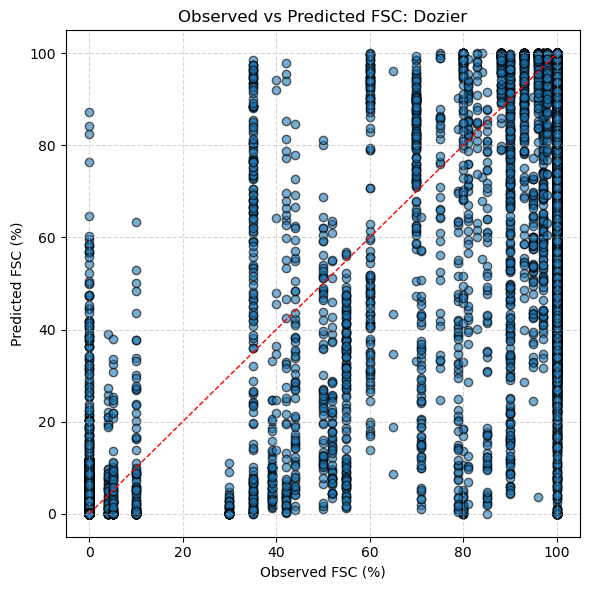

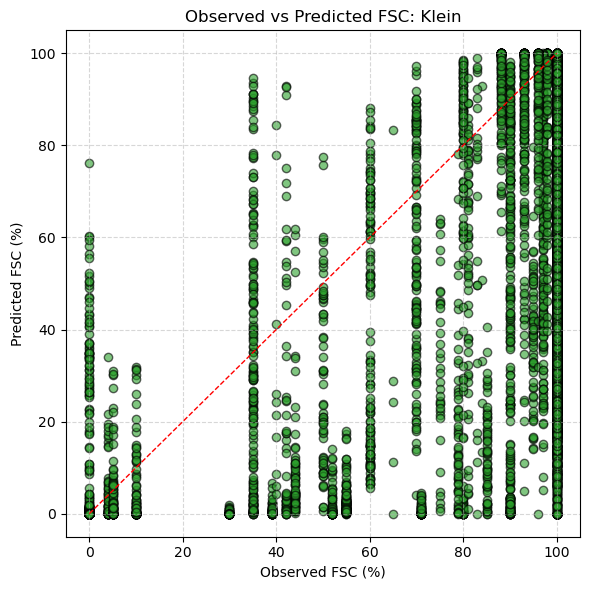

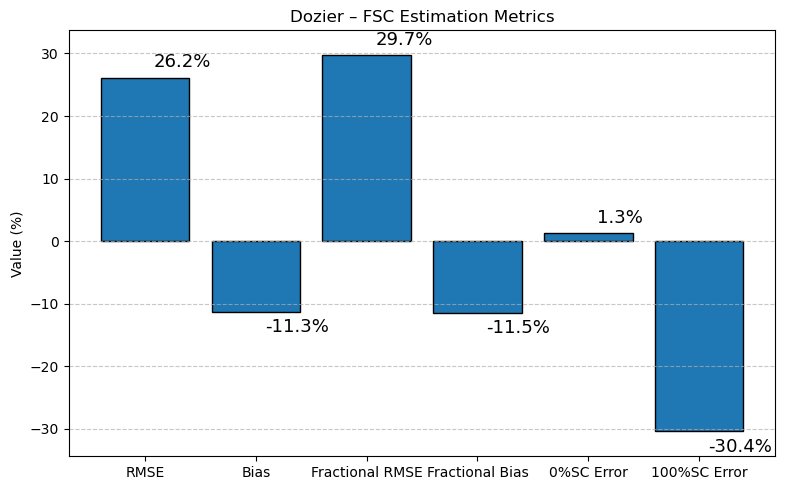

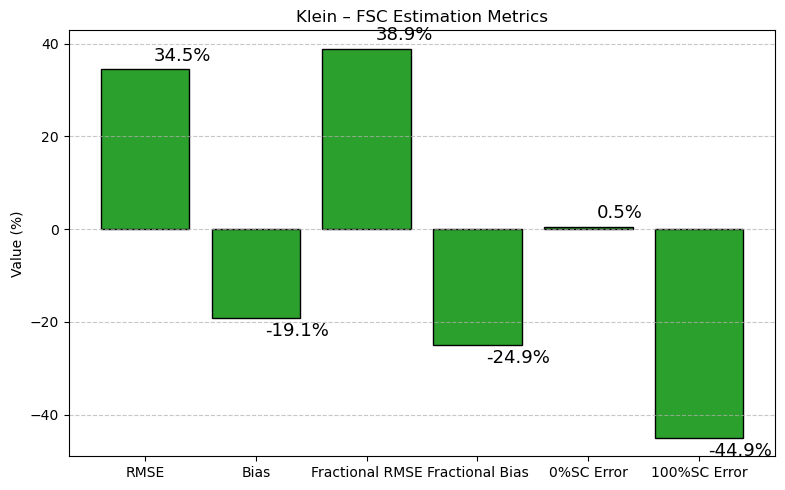

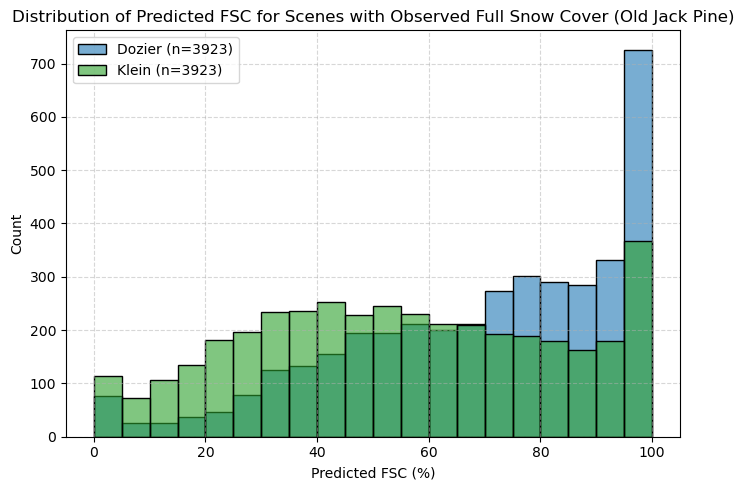

In [11]:
#60m

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# final_df = pd.read_pickle('landsat_df_80m_0.2ff.pkl')
# final_df = final_df[final_df['cam']=='old_jack_pine']

# Melt the dataframe to long format for individual method plots
melted = final_df.melt(
    id_vars=["fsc", "filtered_fraction", "cam"],
    value_vars=["Dozier", "Klein"],  # , "Salomonson"
    var_name="method",
    value_name="predicted"
)

# Convert to percentages for plotting (0–100)
melted["fsc"] = melted["fsc"] * 100.0
melted["predicted"] = melted["predicted"] * 100.0

# Define color map (blue for Dozier, green for Klein)
method_colors = {
    "Dozier": "#1f77b4",
    "Klein": "#2ca02c",
    # "Salomonson": "#d62728"
}

# ---------- Scatter: Observed vs Predicted, one figure per method ----------
for method in ["Dozier", "Klein"]:  # , "Salomonson"
    subset = melted[melted["method"] == method]

    plt.figure(figsize=(6, 6))
    plt.scatter(
        subset["fsc"],
        subset["predicted"],
        alpha=0.6,
        edgecolor='k',
        c=method_colors[method],
        label=method
    )
    plt.plot([0, 100], [0, 100], 'r--', lw=1)
    plt.xlabel("Observed FSC (%)")
    plt.ylabel("Predicted FSC (%)")
    plt.title(f"Observed vs Predicted FSC: {method}")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    # plt.savefig(f'poster_landsat_{method}_actual_predicted.svg')
    plt.show()

# ---------- Metric helpers ----------
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    return np.sqrt(np.nanmean(diff**2)) if np.isfinite(diff).any() else np.nan

def bias(y_true, y_pred):
    diff = y_pred - y_true
    return np.nanmean(diff) if np.isfinite(diff).any() else np.nan

def compute_all_metrics(df_method):
    """df_method: melted subset for a single method, with fsc/predicted in 0–100 units."""
    y = df_method["fsc"].to_numpy()
    yhat = df_method["predicted"].to_numpy()

    # Overall
    overall_rmse  = rmse(y, yhat)
    overall_bias  = bias(y, yhat)

    # Fractional (strictly between 0 and 100)
    frac_mask = (y > 0) & (y < 100)
    frac_rmse  = rmse(y[frac_mask], yhat[frac_mask])
    frac_bias  = bias(y[frac_mask], yhat[frac_mask])

    # Errors at the extremes
    zero_mask = (y == 0)
    full_mask = (y == 100)

    zero_bias = bias(y[zero_mask], yhat[zero_mask])   # "0%SC Error"
    full_bias = bias(y[full_mask], yhat[full_mask])   # "100%SC Error"

    metrics_order = ["RMSE", "Bias", "Fractional RMSE", "Fractional Bias", "0%SC Error", "100%SC Error"]
    values = np.array([
        overall_rmse,
        overall_bias,
        frac_rmse,
        frac_bias,
        zero_bias,
        full_bias
    ], dtype=float)

    return metrics_order, values

# ---------- Bar chart per method with six metrics ----------
for method in ["Dozier", "Klein"]:
    subset = melted[melted["method"] == method]
    metrics_labels, values = compute_all_metrics(subset)

    plt.figure(figsize=(8, 5))
    x = np.arange(len(metrics_labels))
    bars = plt.bar(x, values, edgecolor='black', color=method_colors[method])

    # Labels on bars (handle NaNs gracefully)
    for bar, val in zip(bars, values):
        height = 0 if np.isnan(val) else float(val)
        txt = "NaN" if np.isnan(val) else f"{height:.1f}%"
        x_offset = bar.get_x() + bar.get_width() * 0.6
        y_offset = 1 * np.sign(height if height != 0 else 1)
        plt.text(
            x_offset,
            height + y_offset,
            txt,
            ha='left',
            va='bottom' if height >= 0 else 'top',
            fontsize=13
        )

    plt.xticks(x, metrics_labels, rotation=0)
    plt.ylabel("Value (%)")
    plt.title(f"{method} – FSC Estimation Metrics")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Y-lims with padding, robust to NaNs
    finite_vals = values[np.isfinite(values)]
    if finite_vals.size == 0:
        ymin, ymax = -1, 1
    else:
        ymin = min(0.0, float(finite_vals.min())) - 4
        ymax = (float(finite_vals.max()) + 4) if float(finite_vals.max()) > 0 else 1
    plt.ylim(ymin, ymax)

    plt.tight_layout()
    # plt.savefig(f'poster_landsat_{method}_metrics.svg')
    plt.show()

# ---------- Histogram: Predicted FSC where observed FSC = 100% ----------

# Filter scenes where observed FSC is 100%
full_snow = melted[melted["fsc"] == 100].copy()

# Set up plot
plt.figure(figsize=(7, 5))
bins = np.linspace(0, 100, 21)  # 0–100 in 5% increments

for method in ["Dozier", "Klein"]:
# for method in ["Klein"]:
    subset = full_snow[full_snow["method"] == method]
    sns.histplot(
        subset["predicted"],
        bins=bins,
        kde=False,
        color=method_colors[method],
        label=f"{method} (n={len(subset)})",
        alpha=0.6,
        edgecolor="black"
    )

# Reference line at 100% (perfect prediction)
# plt.axvline(100, color="red", linestyle="--", linewidth=1, label="Observed = 100%")

plt.xlabel("Predicted FSC (%)")
plt.ylabel("Count")
plt.title("Distribution of Predicted FSC for Scenes with Observed Full Snow Cover (Old Jack Pine)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
# plt.savefig("poster_landsat_full_snow_hist.svg")
plt.show()

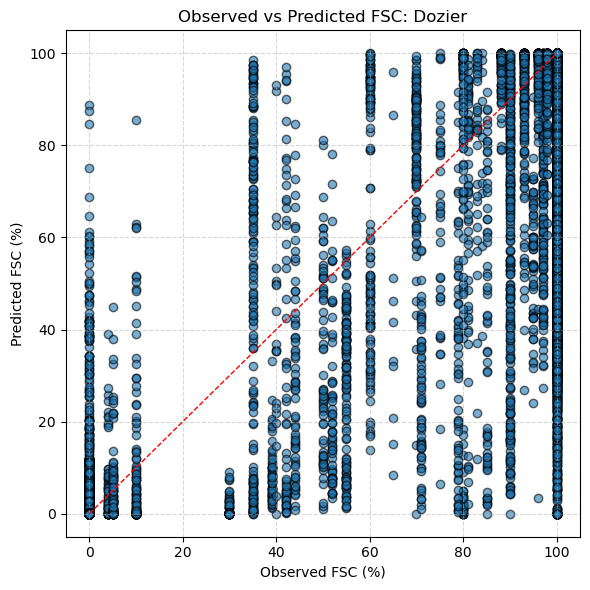

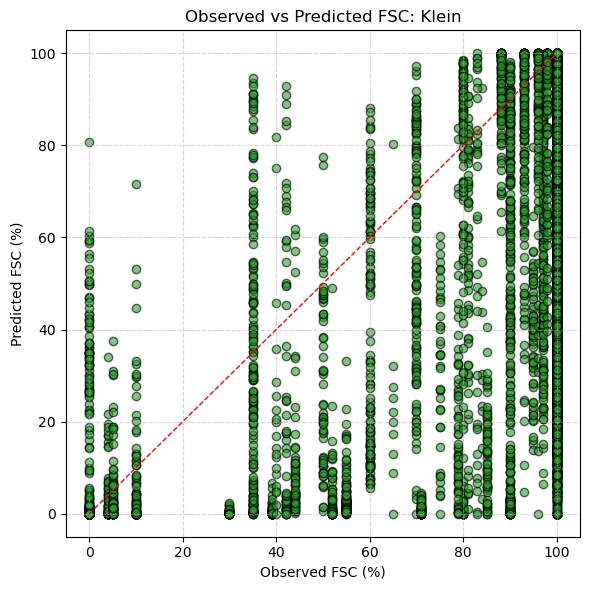

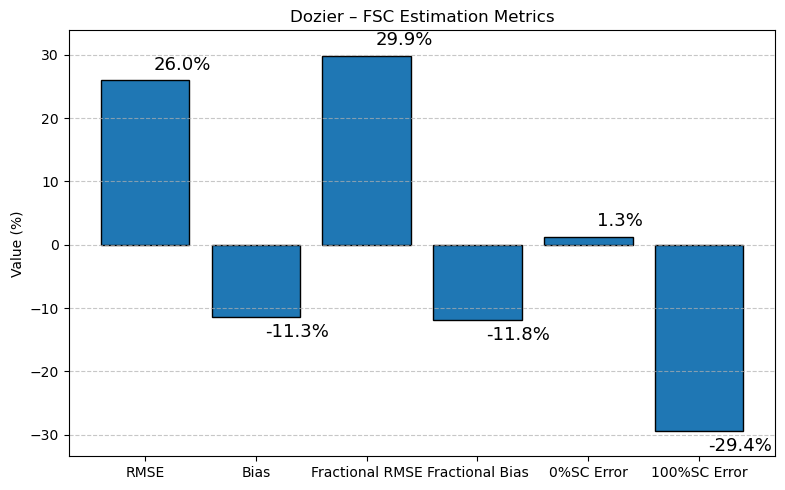

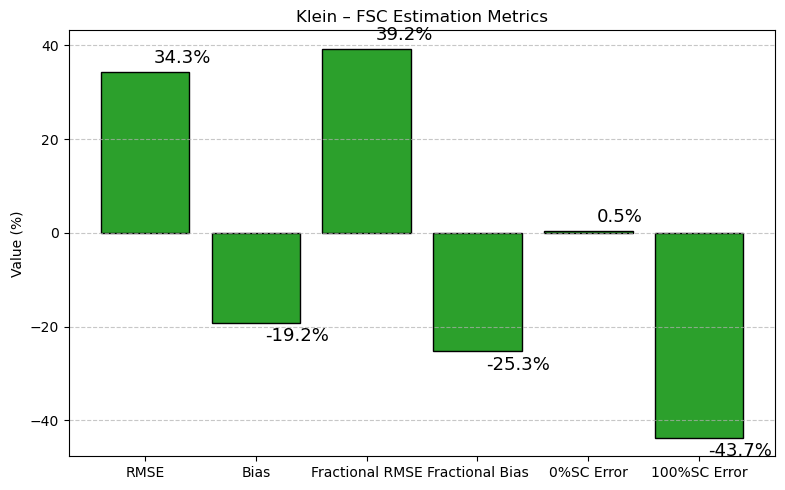

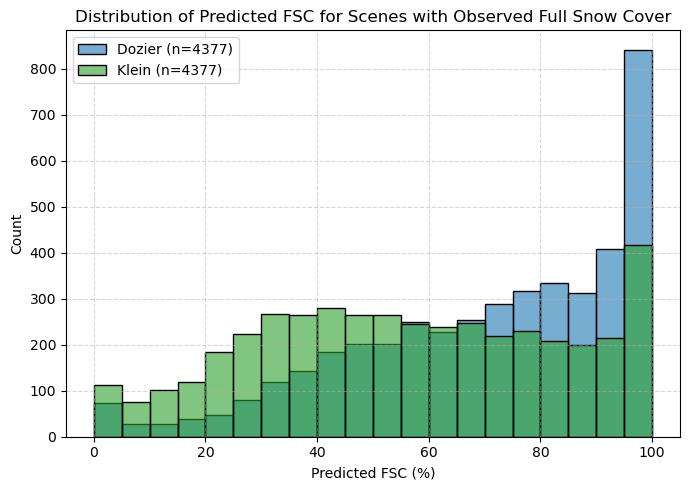

In [13]:
#80m

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# final_df = pd.read_pickle('landsat_df_80m_0.2ff.pkl')
# final_df = final_df[final_df['cam']=='old_jack_pine']

# Melt the dataframe to long format for individual method plots
melted = final_df.melt(
    id_vars=["fsc", "filtered_fraction", "cam"],
    value_vars=["Dozier", "Klein"],  # , "Salomonson"
    var_name="method",
    value_name="predicted"
)

# Convert to percentages for plotting (0–100)
melted["fsc"] = melted["fsc"] * 100.0
melted["predicted"] = melted["predicted"] * 100.0

# Define color map (blue for Dozier, green for Klein)
method_colors = {
    "Dozier": "#1f77b4",
    "Klein": "#2ca02c",
    # "Salomonson": "#d62728"
}

# ---------- Scatter: Observed vs Predicted, one figure per method ----------
for method in ["Dozier", "Klein"]:  # , "Salomonson"
    subset = melted[melted["method"] == method]

    plt.figure(figsize=(6, 6))
    plt.scatter(
        subset["fsc"],
        subset["predicted"],
        alpha=0.6,
        edgecolor='k',
        c=method_colors[method],
        label=method
    )
    plt.plot([0, 100], [0, 100], 'r--', lw=1)
    plt.xlabel("Observed FSC (%)")
    plt.ylabel("Predicted FSC (%)")
    plt.title(f"Observed vs Predicted FSC: {method}")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    # plt.savefig(f'poster_landsat_{method}_actual_predicted.svg')
    plt.show()

# ---------- Metric helpers ----------
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    return np.sqrt(np.nanmean(diff**2)) if np.isfinite(diff).any() else np.nan

def bias(y_true, y_pred):
    diff = y_pred - y_true
    return np.nanmean(diff) if np.isfinite(diff).any() else np.nan

def compute_all_metrics(df_method):
    """df_method: melted subset for a single method, with fsc/predicted in 0–100 units."""
    y = df_method["fsc"].to_numpy()
    yhat = df_method["predicted"].to_numpy()

    # Overall
    overall_rmse  = rmse(y, yhat)
    overall_bias  = bias(y, yhat)

    # Fractional (strictly between 0 and 100)
    frac_mask = (y > 0) & (y < 100)
    frac_rmse  = rmse(y[frac_mask], yhat[frac_mask])
    frac_bias  = bias(y[frac_mask], yhat[frac_mask])

    # Errors at the extremes
    zero_mask = (y == 0)
    full_mask = (y == 100)

    zero_bias = bias(y[zero_mask], yhat[zero_mask])   # "0%SC Error"
    full_bias = bias(y[full_mask], yhat[full_mask])   # "100%SC Error"

    metrics_order = ["RMSE", "Bias", "Fractional RMSE", "Fractional Bias", "0%SC Error", "100%SC Error"]
    values = np.array([
        overall_rmse,
        overall_bias,
        frac_rmse,
        frac_bias,
        zero_bias,
        full_bias
    ], dtype=float)

    return metrics_order, values

# ---------- Bar chart per method with six metrics ----------
for method in ["Dozier", "Klein"]:
    subset = melted[melted["method"] == method]
    metrics_labels, values = compute_all_metrics(subset)

    plt.figure(figsize=(8, 5))
    x = np.arange(len(metrics_labels))
    bars = plt.bar(x, values, edgecolor='black', color=method_colors[method])

    # Labels on bars (handle NaNs gracefully)
    for bar, val in zip(bars, values):
        height = 0 if np.isnan(val) else float(val)
        txt = "NaN" if np.isnan(val) else f"{height:.1f}%"
        x_offset = bar.get_x() + bar.get_width() * 0.6
        y_offset = 1 * np.sign(height if height != 0 else 1)
        plt.text(
            x_offset,
            height + y_offset,
            txt,
            ha='left',
            va='bottom' if height >= 0 else 'top',
            fontsize=13
        )

    plt.xticks(x, metrics_labels, rotation=0)
    plt.ylabel("Value (%)")
    plt.title(f"{method} – FSC Estimation Metrics")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Y-lims with padding, robust to NaNs
    finite_vals = values[np.isfinite(values)]
    if finite_vals.size == 0:
        ymin, ymax = -1, 1
    else:
        ymin = min(0.0, float(finite_vals.min())) - 4
        ymax = (float(finite_vals.max()) + 4) if float(finite_vals.max()) > 0 else 1
    plt.ylim(ymin, ymax)

    plt.tight_layout()
    # plt.savefig(f'poster_landsat_{method}_metrics.svg')
    plt.show()

# ---------- Histogram: Predicted FSC where observed FSC = 100% ----------

# Filter scenes where observed FSC is 100%
full_snow = melted[melted["fsc"] == 100].copy()

# Set up plot
plt.figure(figsize=(7, 5))
bins = np.linspace(0, 100, 21)  # 0–100 in 5% increments

for method in ["Dozier", "Klein"]:
# for method in ["Klein"]:
    subset = full_snow[full_snow["method"] == method]
    sns.histplot(
        subset["predicted"],
        bins=bins,
        kde=False,
        color=method_colors[method],
        label=f"{method} (n={len(subset)})",
        alpha=0.6,
        edgecolor="black"
    )

# Reference line at 100% (perfect prediction)
# plt.axvline(100, color="red", linestyle="--", linewidth=1, label="Observed = 100%")

plt.xlabel("Predicted FSC (%)")
plt.ylabel("Count")
plt.title("Distribution of Predicted FSC for Scenes with Observed Full Snow Cover")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
# plt.savefig("poster_landsat_full_snow_hist.svg")
plt.show()

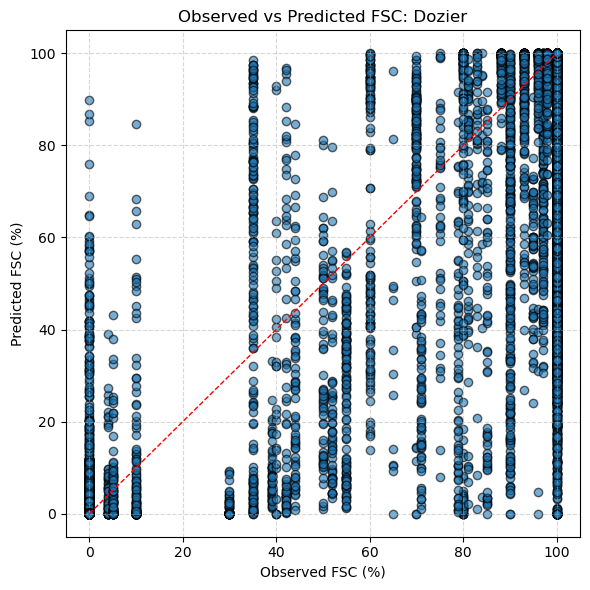

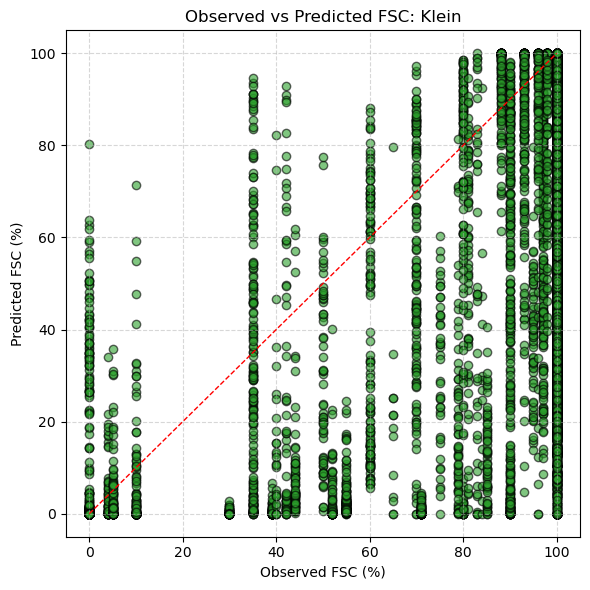

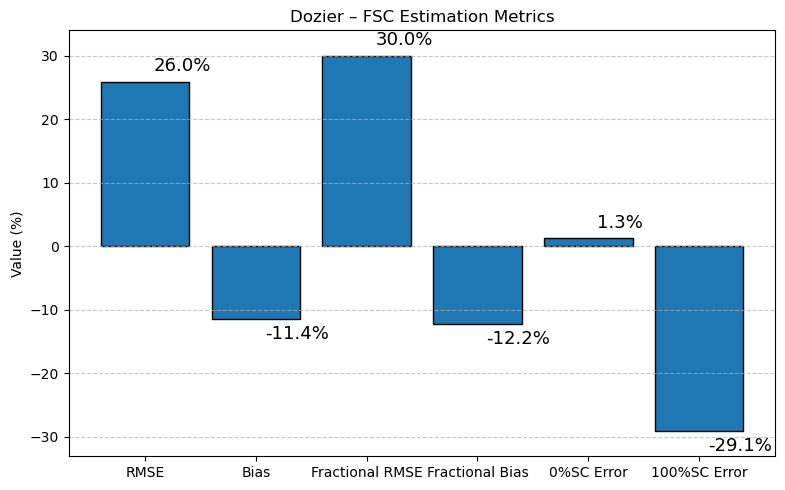

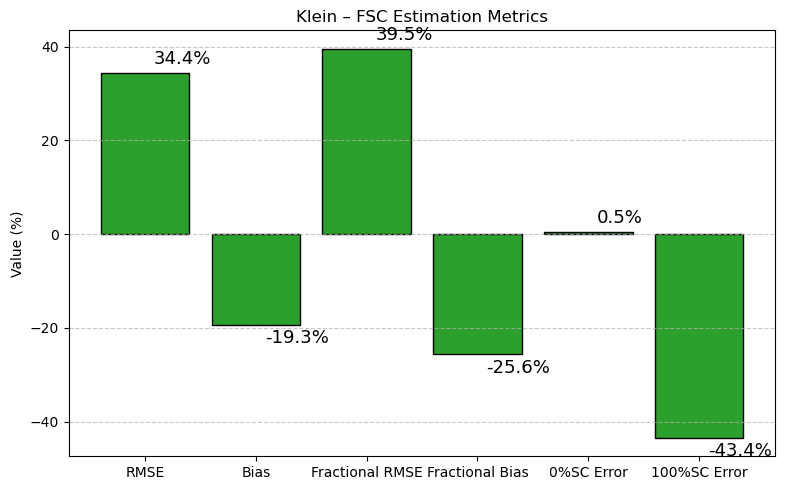

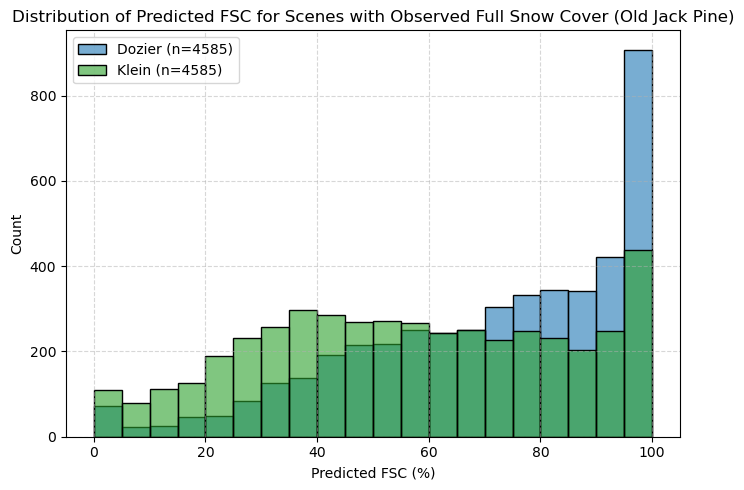

In [17]:
#100m

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# final_df = pd.read_pickle('landsat_df_80m_0.2ff.pkl')
# final_df = final_df[final_df['cam']=='old_jack_pine']

# Melt the dataframe to long format for individual method plots
melted = final_df.melt(
    id_vars=["fsc", "filtered_fraction", "cam"],
    value_vars=["Dozier", "Klein"],  # , "Salomonson"
    var_name="method",
    value_name="predicted"
)

# Convert to percentages for plotting (0–100)
melted["fsc"] = melted["fsc"] * 100.0
melted["predicted"] = melted["predicted"] * 100.0

# Define color map (blue for Dozier, green for Klein)
method_colors = {
    "Dozier": "#1f77b4",
    "Klein": "#2ca02c",
    # "Salomonson": "#d62728"
}

# ---------- Scatter: Observed vs Predicted, one figure per method ----------
for method in ["Dozier", "Klein"]:  # , "Salomonson"
    subset = melted[melted["method"] == method]

    plt.figure(figsize=(6, 6))
    plt.scatter(
        subset["fsc"],
        subset["predicted"],
        alpha=0.6,
        edgecolor='k',
        c=method_colors[method],
        label=method
    )
    plt.plot([0, 100], [0, 100], 'r--', lw=1)
    plt.xlabel("Observed FSC (%)")
    plt.ylabel("Predicted FSC (%)")
    plt.title(f"Observed vs Predicted FSC: {method}")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    # plt.savefig(f'poster_landsat_{method}_actual_predicted.svg')
    plt.show()

# ---------- Metric helpers ----------
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    return np.sqrt(np.nanmean(diff**2)) if np.isfinite(diff).any() else np.nan

def bias(y_true, y_pred):
    diff = y_pred - y_true
    return np.nanmean(diff) if np.isfinite(diff).any() else np.nan

def compute_all_metrics(df_method):
    """df_method: melted subset for a single method, with fsc/predicted in 0–100 units."""
    y = df_method["fsc"].to_numpy()
    yhat = df_method["predicted"].to_numpy()

    # Overall
    overall_rmse  = rmse(y, yhat)
    overall_bias  = bias(y, yhat)

    # Fractional (strictly between 0 and 100)
    frac_mask = (y > 0) & (y < 100)
    frac_rmse  = rmse(y[frac_mask], yhat[frac_mask])
    frac_bias  = bias(y[frac_mask], yhat[frac_mask])

    # Errors at the extremes
    zero_mask = (y == 0)
    full_mask = (y == 100)

    zero_bias = bias(y[zero_mask], yhat[zero_mask])   # "0%SC Error"
    full_bias = bias(y[full_mask], yhat[full_mask])   # "100%SC Error"

    metrics_order = ["RMSE", "Bias", "Fractional RMSE", "Fractional Bias", "0%SC Error", "100%SC Error"]
    values = np.array([
        overall_rmse,
        overall_bias,
        frac_rmse,
        frac_bias,
        zero_bias,
        full_bias
    ], dtype=float)

    return metrics_order, values

# ---------- Bar chart per method with six metrics ----------
for method in ["Dozier", "Klein"]:
    subset = melted[melted["method"] == method]
    metrics_labels, values = compute_all_metrics(subset)

    plt.figure(figsize=(8, 5))
    x = np.arange(len(metrics_labels))
    bars = plt.bar(x, values, edgecolor='black', color=method_colors[method])

    # Labels on bars (handle NaNs gracefully)
    for bar, val in zip(bars, values):
        height = 0 if np.isnan(val) else float(val)
        txt = "NaN" if np.isnan(val) else f"{height:.1f}%"
        x_offset = bar.get_x() + bar.get_width() * 0.6
        y_offset = 1 * np.sign(height if height != 0 else 1)
        plt.text(
            x_offset,
            height + y_offset,
            txt,
            ha='left',
            va='bottom' if height >= 0 else 'top',
            fontsize=13
        )

    plt.xticks(x, metrics_labels, rotation=0)
    plt.ylabel("Value (%)")
    plt.title(f"{method} – FSC Estimation Metrics")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Y-lims with padding, robust to NaNs
    finite_vals = values[np.isfinite(values)]
    if finite_vals.size == 0:
        ymin, ymax = -1, 1
    else:
        ymin = min(0.0, float(finite_vals.min())) - 4
        ymax = (float(finite_vals.max()) + 4) if float(finite_vals.max()) > 0 else 1
    plt.ylim(ymin, ymax)

    plt.tight_layout()
    # plt.savefig(f'poster_landsat_{method}_metrics.svg')
    plt.show()

# ---------- Histogram: Predicted FSC where observed FSC = 100% ----------

# Filter scenes where observed FSC is 100%
full_snow = melted[melted["fsc"] == 100].copy()

# Set up plot
plt.figure(figsize=(7, 5))
bins = np.linspace(0, 100, 21)  # 0–100 in 5% increments

for method in ["Dozier", "Klein"]:
# for method in ["Klein"]:
    subset = full_snow[full_snow["method"] == method]
    sns.histplot(
        subset["predicted"],
        bins=bins,
        kde=False,
        color=method_colors[method],
        label=f"{method} (n={len(subset)})",
        alpha=0.6,
        edgecolor="black"
    )

# Reference line at 100% (perfect prediction)
# plt.axvline(100, color="red", linestyle="--", linewidth=1, label="Observed = 100%")

plt.xlabel("Predicted FSC (%)")
plt.ylabel("Count")
plt.title("Distribution of Predicted FSC for Scenes with Observed Full Snow Cover (Old Jack Pine)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
# plt.savefig("poster_landsat_full_snow_hist.svg")
plt.show()

# our sites, 1 bin

In [5]:
from scripts.imports import *
from rasterio.enums import Resampling
from shapely.geometry import Polygon, Point
from pyproj import Transformer
import os
import re

# ------------------------------------------------------------------
# SETTINGS
# ------------------------------------------------------------------
# positions for SR bands in your stacks (already reflectance)
L7_SR_IDX = slice(0, 6)   # SR_B1..SR_B5, SR_B7
L8_SR_IDX = slice(0, 7)   # SR_B1..SR_B7

# Folder containing your *reflectance* Landsat stacks (one .tif per scene)
LANDSAT_FOLDER = '../scratch/data/landsat_oursites_L2_GEE/SR/'

# Masking data
LANDSAT_MASKING_FOLDER = '../scratch/data/landsat_masking/'

# ROI options (applied in image CRS, defined in lon/lat + metres)
USE_ROI = False        # set True to crop around a region of interest
ROI_LON = -105.90      # centre longitude (deg)
ROI_LAT = 53.92        # centre latitude (deg)
ROI_HALF_WIDTH_M = 26000   # half-width (x) in metres
ROI_HALF_HEIGHT_M = 26000  # half-height (y) in metres

# ------------------------------------------------------------------
# HELPERS
# ------------------------------------------------------------------
def _sr_slice(landsat_type):
    return L7_SR_IDX if landsat_type == 'Landsat7' else L8_SR_IDX


def extract_core_sr(landsat_da, landsat_type):
    """
    Return (blue, green, red, nir, swir1) as reflectance,
    with consistent meanings across sensors.
    Assumes input is already in reflectance space.
    """
    if landsat_type == 'Landsat7':
        # ('SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B7', ...)
        blue  = landsat_da.isel(band=0)  # SR_B1
        green = landsat_da.isel(band=1)  # SR_B2
        red   = landsat_da.isel(band=2)  # SR_B3
        nir   = landsat_da.isel(band=3)  # SR_B4
        swir1 = landsat_da.isel(band=4)  # SR_B5 (1.6 µm)
    else:
        # ('SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7', ...)
        blue  = landsat_da.isel(band=1)  # SR_B2
        green = landsat_da.isel(band=2)  # SR_B3
        red   = landsat_da.isel(band=3)  # SR_B4
        nir   = landsat_da.isel(band=4)  # SR_B5
        swir1 = landsat_da.isel(band=5)  # SR_B6 (1.6 µm)
    return blue, green, red, nir, swir1


def find_masks(folder, cam):
    corine_filepath = None
    elevation_filepath = None
    for filename in os.listdir(folder):
        if cam in filename and 'LandCover' in filename:
            corine_filepath = os.path.join(folder, filename)
        elif cam in filename and 'ALOS' in filename:
            elevation_filepath = os.path.join(folder, filename)
    if corine_filepath is None or elevation_filepath is None:
        raise FileNotFoundError(f"Could not find both LandCover and ALOS for {cam}")
    return corine_filepath, elevation_filepath


def load_and_reproject_to_landsat(source_path, match_array, band_name, method=Resampling.nearest):
    src = rioxarray.open_rasterio(source_path, masked=True).squeeze()
    src.name = band_name
    return src.rio.reproject_match(match_array, resampling=method)


def subset_roi(da, centre_lon, centre_lat, half_width_m, half_height_m):
    """
    Subset a DataArray to a rectangular ROI around (lon, lat),
    using the dataset's CRS and units (usually metres).
    """
    if da.rio.crs is None:
        raise ValueError("Dataset has no CRS; cannot subset by lon/lat.")

    transformer = Transformer.from_crs("EPSG:4326", da.rio.crs, always_xy=True)
    cx, cy = transformer.transform(centre_lon, centre_lat)

    minx = cx - half_width_m
    maxx = cx + half_width_m
    miny = cy - half_height_m
    maxy = cy + half_height_m

    return da.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)


def combine_tifs(landsat_filepath, corine_filepath, elevation_filepath,
                 landsat_type, use_roi=False):
    """
    Load Landsat reflectance stack + corine + elevation, all on the same grid.
    Optionally crop to an ROI (on the Landsat grid) before merging.
    """
    landsat = rioxarray.open_rasterio(landsat_filepath, masked=True).squeeze()
    landsat.name = "landsat"

    if use_roi:
        print("  Applying ROI crop to Landsat...")
        landsat = subset_roi(
            landsat,
            centre_lon=ROI_LON,
            centre_lat=ROI_LAT,
            half_width_m=ROI_HALF_WIDTH_M,
            half_height_m=ROI_HALF_HEIGHT_M,
        )

    # No scaling/clipping here; we assume SR is already reflectance

    corine = load_and_reproject_to_landsat(corine_filepath, landsat, "corine_landcover")
    elevation = load_and_reproject_to_landsat(elevation_filepath, landsat, "elevation")

    if use_roi:
        # corine/elevation are already reprojected to Landsat, so ROI crop
        # would be redundant here, but harmless – you can omit if you like.
        corine = subset_roi(
            corine,
            centre_lon=ROI_LON,
            centre_lat=ROI_LAT,
            half_width_m=ROI_HALF_WIDTH_M,
            half_height_m=ROI_HALF_HEIGHT_M,
        )
        elevation = subset_roi(
            elevation,
            centre_lon=ROI_LON,
            centre_lat=ROI_LAT,
            half_width_m=ROI_HALF_WIDTH_M,
            half_height_m=ROI_HALF_HEIGHT_M,
        )

    return xr.merge([landsat, corine, elevation])


def apply_valid_mask(ds, e=80):
    elevation = ds['elevation']
    corine = ds['corine_landcover']
    yc, xc = elevation.sizes['y'] // 2, elevation.sizes['x'] // 2
    centre_elev = elevation.isel(y=yc, x=xc).item()
    elev_mask = np.abs(elevation - centre_elev) <= e
    corine_mask = (corine >= 111) & (corine <= 126)
    valid_mask = elev_mask & corine_mask
    ds['valid_mask'] = valid_mask
    return ds


def compute_index(b1, b2):
    denom = b1 + b2
    return xr.where(denom != 0, (b1 - b2) / denom, np.nan)


def compute_dozier(ds, ndsi, nir):
    condition1 = (ndsi > 0.1) & (ndsi < 0.4)
    condition2 = (ndsi >= 0.4) & (nir > 0.11)
    dozier = xr.where(condition1 | condition2, 1, 0)
    return dozier.where(~np.isnan(ndsi))


def compute_klein(ndsi, ndvi, green, nir):
    region_coords = [
        (0.4, 1),
        (0.33, 0.9),
        (0.26, 0.75),
        (0.2, 0.59),
        (0.1, 0.24),  # bottom left
        (0.2, 0.2),
        (0.4, 0.1),   # top right
    ]
    polygon = Polygon(region_coords)
    klein = xr.zeros_like(ndsi)
    klein = xr.where((ndsi >= 0.4) & (nir > 0.11), 1, klein)
    ndsi_vals, ndvi_vals = ndsi.values, ndvi.values
    mask = np.zeros(ndsi.shape, dtype=bool)
    for i in range(ndsi.shape[0]):
        for j in range(ndsi.shape[1]):
            if not np.isnan(ndsi_vals[i, j]) and not np.isnan(ndvi_vals[i, j]):
                if polygon.contains(Point(ndsi_vals[i, j], ndvi_vals[i, j])):
                    mask[i, j] = True
    klein = xr.where(xr.DataArray(mask, dims=ndsi.dims, coords=ndsi.coords), 1, klein)
    klein = xr.where((green <= 0.1), 0, klein)
    return klein.where(~np.isnan(ndsi) & ~np.isnan(ndvi))


def compute_salomonson(ndsi):
    fsc = 0.06 + 1.21 * ndsi
    return fsc.clip(0, 1).where(~np.isnan(ndsi))


def normalize(img):
    img = img.transpose("y", "x", "band")
    p2 = img.quantile(0.02, dim=("x", "y"))
    p98 = img.quantile(0.98, dim=("x", "y"))
    return ((img - p2) / (p98 - p2)).clip(0, 1)


def plot_rgb(ds, landsat_type, cam, filtered=True):
    blue, green, red, _, _ = extract_core_sr(ds['landsat'], landsat_type)
    rgb = xr.concat([red, green, blue], dim='band')

    if filtered and 'valid_mask' in ds:
        rgb = rgb.where(ds['valid_mask'])

    rgb = normalize(rgb)
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb.transpose("y", "x", "band"))
    plt.title(f"RGB Composite for {cam}")
    plt.axis("off")
    plt.show()


# ------------------------------------------------------------------
# PER-SCENE PROCESSING
# ------------------------------------------------------------------
def process_scene(i, apply_filter=True, plot_rgb_image=False, e=80):
    cams = ['bartlett', 'delta_junction', 'glees', 'hyytiala', 'kenttarova',
            'lacclair', 'marcell', 'old_jack_pine', 'oregon', 'queens',
            'sodankyla', 'tammela', 'torgnon', 'underc', 'underhill',
            'varrio', 'willowcreek', 'wslcreek']

    landsat_filepaths = sorted([
        os.path.join(LANDSAT_FOLDER, f) for f in os.listdir(LANDSAT_FOLDER)
        if os.path.isfile(os.path.join(LANDSAT_FOLDER, f)) and f.endswith('.tif')
    ])

    filepath = landsat_filepaths[i]
    cam = [c for c in cams if c in filepath][0]
    landsat_type = [l for l in ['Landsat7', 'Landsat8'] if l in filepath][0]

    # Extract FSC number from filename (e.g. 'bartlett80_')
    match = re.search(rf"{cam}(\d+)_", os.path.basename(filepath))
    fsc_value = int(match.group(1)) if match else None

    corine_fp, elev_fp = find_masks(LANDSAT_MASKING_FOLDER, cam)
    print(f"Processing i={i}: {filepath}")

    ds = combine_tifs(filepath, corine_fp, elev_fp,
                      landsat_type=landsat_type, use_roi=USE_ROI)
    ds = apply_valid_mask(ds, e)

    sr_subset = ds['landsat'].isel(band=_sr_slice(landsat_type))
    print(f"{landsat_type} SR (as-is) mean/min/max:",
          float(np.nanmean(sr_subset.values)),
          float(np.nanmin(sr_subset.values)),
          float(np.nanmax(sr_subset.values)))

    blue, green, red, nir, swir = extract_core_sr(ds['landsat'], landsat_type)
    ndsi = compute_index(green, swir)
    ndvi = compute_index(nir, red)

    dozier = compute_dozier(ds, ndsi, nir)
    klein = compute_klein(ndsi, ndvi, green, nir)
    fsc = compute_salomonson(ndsi)

    if apply_filter:
        dozier = dozier.where(ds['valid_mask'])
        klein = klein.where(ds['valid_mask'])
        fsc = fsc.where(ds['valid_mask'])

    ds['Dozier'] = dozier.assign_attrs(name="Dozier")
    ds['Klein'] = klein.assign_attrs(name="Klein")
    ds['Salomonson'] = fsc.assign_attrs(name="Salomonson")

    if plot_rgb_image:
        plot_rgb(ds, landsat_type, cam, filtered=False)

    return ds, fsc_value, cam, filepath


# ------------------------------------------------------------------
# RECTANGULAR BIN STATS
# ------------------------------------------------------------------
def subcell_stats(ds, var='Salomonson', extent=4, bins=8, only_dominant=False):
    data = ds[var]
    mask = ds['valid_mask']

    ny, nx = data.shape
    yy, xx = np.meshgrid(np.arange(ny), np.arange(nx), indexing="ij")

    flat_y = yy.ravel()
    flat_x = xx.ravel()
    flat_data = data.values.ravel()
    flat_mask = mask.values.ravel()

    y_edges = np.linspace(0, ny, bins + 1)
    x_edges = np.linspace(0, nx, bins + 1)
    y_edges[-1] = np.nextafter(y_edges[-1], np.inf)
    x_edges[-1] = np.nextafter(x_edges[-1], np.inf)

    cell_y = np.digitize(flat_y, y_edges, right=False) - 1
    cell_x = np.digitize(flat_x, x_edges, right=False) - 1
    cell_y = np.clip(cell_y, 0, bins - 1)
    cell_x = np.clip(cell_x, 0, bins - 1)

    center = bins // 2
    eff_extent = min(extent, bins)
    valid_sel = (
        (cell_y >= center - eff_extent) & (cell_y <= center + eff_extent) &
        (cell_x >= center - eff_extent) & (cell_x <= center + eff_extent)
    )

    df = pd.DataFrame({
        'cell_y': cell_y[valid_sel],
        'cell_x': cell_x[valid_sel],
        'data':   flat_data[valid_sel],
        'mask':   flat_mask[valid_sel]
    })

    grouped = df.groupby(['cell_y', 'cell_x'], as_index=False).agg(
        mean=('data', 'mean'),
        filtered_fraction=('mask', lambda v: np.count_nonzero(v == True) /
                           max(1, np.count_nonzero(~np.isnan(v)))),
        pixel_count=('data', 'size')
    )

    if only_dominant:
        grouped = grouped.sort_values(
            ['pixel_count', 'filtered_fraction'],
            ascending=False
        ).head(1)

    grouped['cell_y'] = grouped['cell_y'].astype(int)
    grouped['cell_x'] = grouped['cell_x'].astype(int)
    return grouped


# ------------------------------------------------------------------
# MAIN LOOP
# ------------------------------------------------------------------
landsat_files = [
    f for f in os.listdir(LANDSAT_FOLDER)
    if os.path.isfile(os.path.join(LANDSAT_FOLDER, f)) and f.endswith('.tif')
]
N = len(landsat_files)
print("Number of scenes:", N)

merged_results = []
e = 80

for i in range(N):
    # example debug window; adjust if you like
    if i < -1:
        ds, fsc, cam, filepath = process_scene(
            i=i, apply_filter=True, plot_rgb_image=True, e=e
        )

        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        ds.Klein.plot(ax=axes)
        axes.set_title("Klein")
        plt.tight_layout()
        plt.show()
    else:
        ds, fsc, cam, filepath = process_scene(
            i=i, apply_filter=True, plot_rgb_image=False, e=e
        )

    print(fsc)
    fsc_norm = fsc / 100 if fsc is not None else np.nan

    # Get results for all three metrics (bins & filtered_fraction happen AFTER ROI)
    dozier = subcell_stats(ds, var='Dozier', extent=4, bins=1, only_dominant=True)
    klein  = subcell_stats(ds, var='Klein',  extent=4, bins=1, only_dominant=True)
    salo   = subcell_stats(ds, var='Salomonson', extent=4, bins=1, only_dominant=True)

    # Filter by valid fraction
    dozier = dozier.where(dozier['filtered_fraction'] >= 0.2).dropna()
    klein  = klein.where(klein['filtered_fraction'] >= 0.2).dropna()
    salo   = salo.where(salo['filtered_fraction'] >= 0.2).dropna()

    # Merge on cell_x and cell_y
    merged = (
        dozier[['cell_y', 'cell_x', 'filtered_fraction', 'mean']]
        .rename(columns={'mean': 'Dozier'})
        .merge(
            klein[['cell_y', 'cell_x', 'mean']].rename(columns={'mean': 'Klein'}),
            on=['cell_y', 'cell_x']
        )
        .merge(
            salo[['cell_y', 'cell_x', 'mean']].rename(columns={'mean': 'Salomonson'}),
            on=['cell_y', 'cell_x']
        )
    )

    merged['fsc'] = fsc_norm
    merged['cam'] = cam
    merged['filepath'] = filepath
    merged_results.append(merged)

# Final DataFrame
final_df = pd.concat(merged_results, ignore_index=True)
print(final_df)


Number of scenes: 287
Processing i=0: ../scratch/data/landsat_oursites_L2_GEE/SR/Landsat7_bartlett80_clouds4_LE07_L2SP_013029_20220323_20220419_02_T1.tif
Landsat7 SR (as-is) mean/min/max: 0.088655486702919 -0.011212499812245369 0.5688725113868713
80
Processing i=1: ../scratch/data/landsat_oursites_L2_GEE/SR/Landsat7_hyytiala95_clouds6_LE07_L2SP_189017_20190417_20200827_02_T1.tif
Landsat7 SR (as-is) mean/min/max: 0.11664009839296341 -0.006647500209510326 0.7317000031471252
95
Processing i=2: ../scratch/data/landsat_oursites_L2_GEE/SR/Landsat7_kenttarova98_clouds0_LE07_L2SP_192012_20200526_20200820_02_T1.tif
Landsat7 SR (as-is) mean/min/max: 0.26378360390663147 -0.01030499953776598 0.7865899801254272
98
Processing i=3: ../scratch/data/landsat_oursites_L2_GEE/SR/Landsat7_lacclair90_clouds0_LE07_L2SP_013027_20190502_20200825_02_T1.tif
Landsat7 SR (as-is) mean/min/max: 0.1505589485168457 -0.005107500124722719 0.503724992275238
90
Processing i=4: ../scratch/data/landsat_oursites_L2_GEE/SR/La

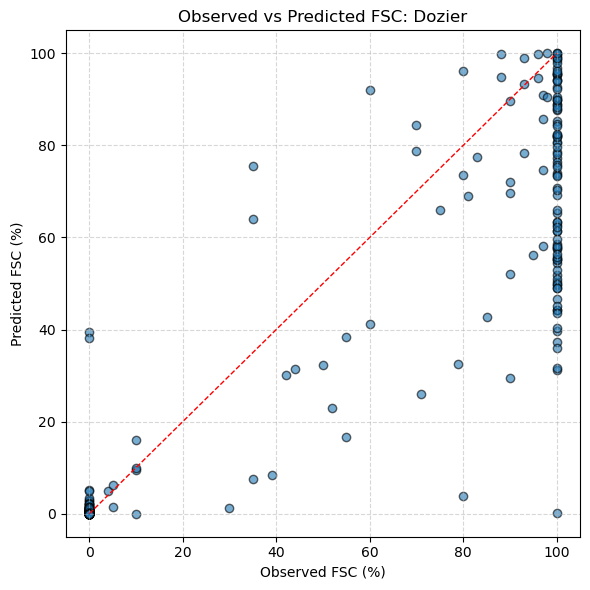

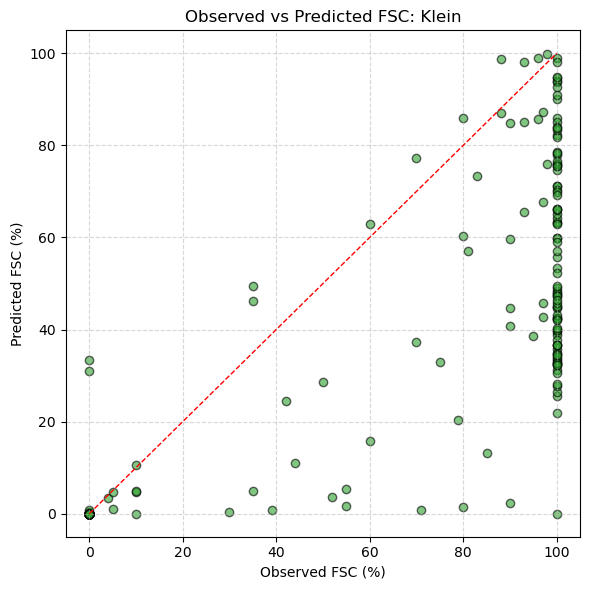

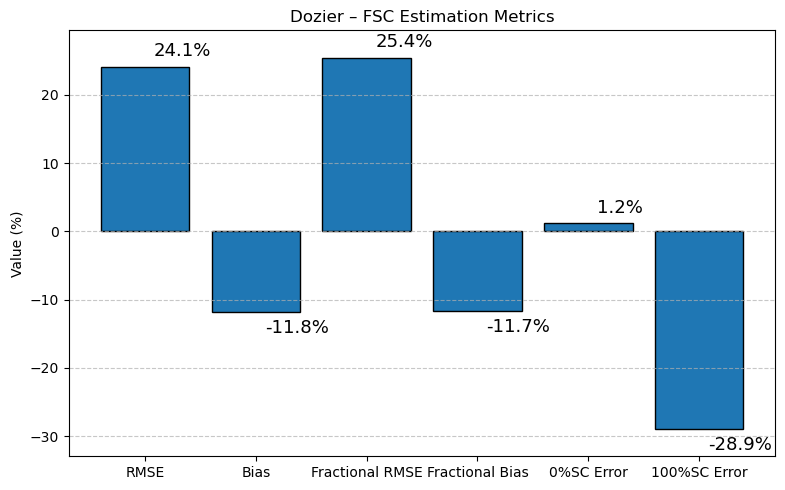

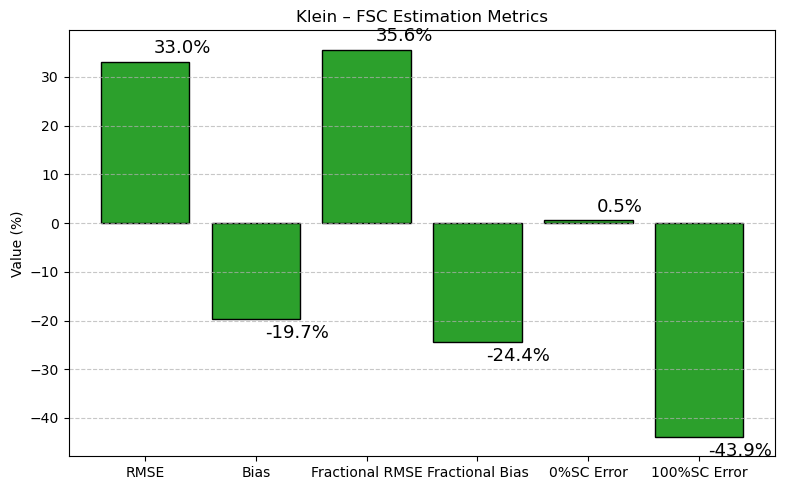

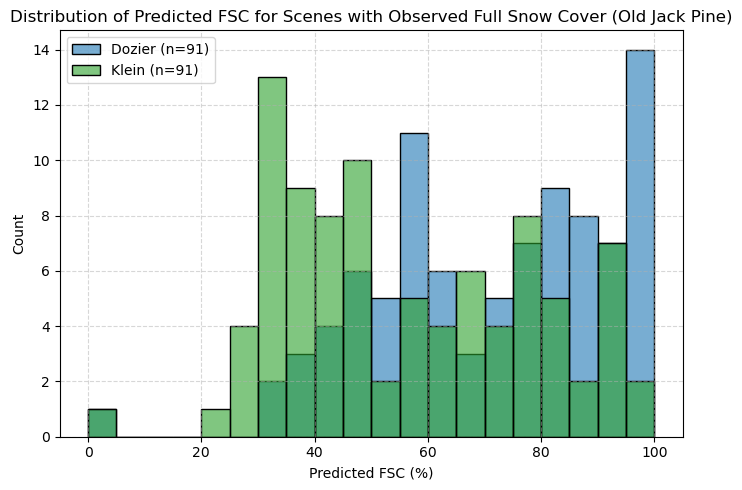

In [13]:
#80m

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# final_df = pd.read_pickle('landsat_df_80m_0.2ff.pkl')
# final_df_ = final_df[final_df['cam']=='old_jack_pine'].copy()
final_df_ = final_df.copy()

# Melt the dataframe to long format for individual method plots
melted = final_df_.melt(
    id_vars=["fsc", "filtered_fraction", "cam", "filepath"],
    value_vars=["Dozier", "Klein"],  # , "Salomonson"
    var_name="method",
    value_name="predicted"
)

# Convert to percentages for plotting (0–100)
melted["fsc"] = melted["fsc"] * 100.0
melted["predicted"] = melted["predicted"] * 100.0

# Define color map (blue for Dozier, green for Klein)
method_colors = {
    "Dozier": "#1f77b4",
    "Klein": "#2ca02c",
    # "Salomonson": "#d62728"
}

# ---------- Scatter: Observed vs Predicted, one figure per method ----------
for method in ["Dozier", "Klein"]:  # , "Salomonson"
    subset = melted[melted["method"] == method]

    plt.figure(figsize=(6, 6))
    plt.scatter(
        subset["fsc"],
        subset["predicted"],
        alpha=0.6,
        edgecolor='k',
        c=method_colors[method],
        label=method
    )
    plt.plot([0, 100], [0, 100], 'r--', lw=1)
    plt.xlabel("Observed FSC (%)")
    plt.ylabel("Predicted FSC (%)")
    plt.title(f"Observed vs Predicted FSC: {method}")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    # plt.savefig(f'poster_landsat_{method}_actual_predicted.svg')
    plt.show()

# ---------- Metric helpers ----------
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    return np.sqrt(np.nanmean(diff**2)) if np.isfinite(diff).any() else np.nan

def bias(y_true, y_pred):
    diff = y_pred - y_true
    return np.nanmean(diff) if np.isfinite(diff).any() else np.nan

def compute_all_metrics(df_method):
    """df_method: melted subset for a single method, with fsc/predicted in 0–100 units."""
    y = df_method["fsc"].to_numpy()
    yhat = df_method["predicted"].to_numpy()

    # Overall
    overall_rmse  = rmse(y, yhat)
    overall_bias  = bias(y, yhat)

    # Fractional (strictly between 0 and 100)
    frac_mask = (y > 0) & (y < 100)
    frac_rmse  = rmse(y[frac_mask], yhat[frac_mask])
    frac_bias  = bias(y[frac_mask], yhat[frac_mask])

    # Errors at the extremes
    zero_mask = (y == 0)
    full_mask = (y == 100)

    zero_bias = bias(y[zero_mask], yhat[zero_mask])   # "0%SC Error"
    full_bias = bias(y[full_mask], yhat[full_mask])   # "100%SC Error"

    metrics_order = ["RMSE", "Bias", "Fractional RMSE", "Fractional Bias", "0%SC Error", "100%SC Error"]
    values = np.array([
        overall_rmse,
        overall_bias,
        frac_rmse,
        frac_bias,
        zero_bias,
        full_bias
    ], dtype=float)

    return metrics_order, values

# ---------- Bar chart per method with six metrics ----------
for method in ["Dozier", "Klein"]:
    subset = melted[melted["method"] == method]
    metrics_labels, values = compute_all_metrics(subset)

    plt.figure(figsize=(8, 5))
    x = np.arange(len(metrics_labels))
    bars = plt.bar(x, values, edgecolor='black', color=method_colors[method])

    # Labels on bars (handle NaNs gracefully)
    for bar, val in zip(bars, values):
        height = 0 if np.isnan(val) else float(val)
        txt = "NaN" if np.isnan(val) else f"{height:.1f}%"
        x_offset = bar.get_x() + bar.get_width() * 0.6
        y_offset = 1 * np.sign(height if height != 0 else 1)
        plt.text(
            x_offset,
            height + y_offset,
            txt,
            ha='left',
            va='bottom' if height >= 0 else 'top',
            fontsize=13
        )

    plt.xticks(x, metrics_labels, rotation=0)
    plt.ylabel("Value (%)")
    plt.title(f"{method} – FSC Estimation Metrics")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Y-lims with padding, robust to NaNs
    finite_vals = values[np.isfinite(values)]
    if finite_vals.size == 0:
        ymin, ymax = -1, 1
    else:
        ymin = min(0.0, float(finite_vals.min())) - 4
        ymax = (float(finite_vals.max()) + 4) if float(finite_vals.max()) > 0 else 1
    plt.ylim(ymin, ymax)

    plt.tight_layout()
    # plt.savefig(f'poster_landsat_{method}_metrics.svg')
    plt.show()

# ---------- Histogram: Predicted FSC where observed FSC = 100% ----------

# Filter scenes where observed FSC is 100%
full_snow = melted[melted["fsc"] == 100].copy()

# Set up plot
plt.figure(figsize=(7, 5))
bins = np.linspace(0, 100, 21)  # 0–100 in 5% increments

for method in ["Dozier", "Klein"]:
# for method in ["Klein"]:
    subset = full_snow[full_snow["method"] == method]
    sns.histplot(
        subset["predicted"],
        bins=bins,
        kde=False,
        color=method_colors[method],
        label=f"{method} (n={len(subset)})",
        alpha=0.6,
        edgecolor="black"
    )

# Reference line at 100% (perfect prediction)
# plt.axvline(100, color="red", linestyle="--", linewidth=1, label="Observed = 100%")

plt.xlabel("Predicted FSC (%)")
plt.ylabel("Count")
plt.title("Distribution of Predicted FSC for Scenes with Observed Full Snow Cover (Old Jack Pine)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
# plt.savefig("poster_landsat_full_snow_hist.svg")
plt.show()

In [14]:
import pandas as pd

pd.set_option('display.max_colwidth', None)  # show full strings in cells

final_df_

cell_y  cell_x  filtered_fraction    Dozier     Klein  Salomonson   fsc  \
0       0.0     0.0           0.375740  0.038230  0.014329    0.018570  0.80   
1       0.0     0.0           0.966182  0.561190  0.386174    0.290950  0.95   
2       0.0     0.0           0.723425  0.999799  0.998064    0.874499  0.98   
3       0.0     0.0           0.656808  0.719909  0.446721    0.346464  0.90   
4       0.0     0.0           0.887426  0.994031  0.947037    0.736797  1.00   
..      ...     ...                ...       ...       ...         ...   ...   
256     0.0     0.0           0.216371  0.490641  0.345556    0.487365  1.00   
257     0.0     0.0           0.216371  0.596464  0.421826    0.512895  1.00   
258     0.0     0.0           0.216371  0.960689  0.691600    0.780355  1.00   
259     0.0     0.0           0.216371  0.898841  0.463960    0.707177  1.00   
260     0.0     0.0           0.216371  1.000000  0.837446    0.620925  1.00   

            cam  \
0      bartlett   
1      hyytiala   
2    kenttarova   
3      lacclair   
4       marcell   
..          ...   
256    wslcreek   
257    wslcreek   
258    wslcreek   
259    wslcreek   
260    wslcreek   

                                                                                                         filepath  
0      ../scratch/data/landsat_L2_GEE/SR/Landsat7_bartlett80_clouds4_LE07_L2SP_013029_20220323_20220419_02_T1.tif  
1      ../scratch/data/landsat_L2_GEE/SR/Landsat7_hyytiala95_clouds6_LE07_L2SP_189017_20190417_20200827_02_T1.tif  
2    ../scratch/data/landsat_L2_GEE/SR/Landsat7_kenttarova98_clouds0_LE07_L2SP_192012_20200526_20200820_02_T1.tif  
3      ../scratch/data/landsat_L2_GEE/SR/Landsat7_lacclair90_clouds0_LE07_L2SP_013027_20190502_20200825_02_T1.tif  
4     ../scratch/data/landsat_L2_GEE/SR/Landsat7_marcell100_clouds12_LE07_L2SP_028027_20200326_20200822_02_T1.tif  
..                                                                                                            ...  
256           ../scratch/data/landsat_L2_GEE/SR/Landsat8_wslcreek100_LC08_L2SP_034032_20220113_20220123_02_T1.tif  
257           ../scratch/data/landsat_L2_GEE/SR/Landsat8_wslcreek100_LC08_L2SP_034032_20220214_20220222_02_T1.tif  
258           ../scratch/data/landsat_L2_GEE/SR/Landsat8_wslcreek100_LC08_L2SP_034032_20220318_20220322_02_T1.tif  
259           ../scratch/data/landsat_L2_GEE/SR/Landsat8_wslcreek100_LC08_L2SP_034032_20221028_20221108_02_T1.tif  
260           ../scratch/data/landsat_L2_GEE/SR/Landsat8_wslcreek100_LC08_L2SP_034032_20221215_20221227_02_T1.tif  

[261 rows x 9 columns]

# BOREAS Project

array('d', [-106.28861458171227, -106.30308424604118, -105.50696610256772, -105.50133504618528, -106.28861458171227]) array('d', [53.68274701635213, 54.150005645250026, 54.15598944786511, 53.688629766774795, 53.68274701635213])


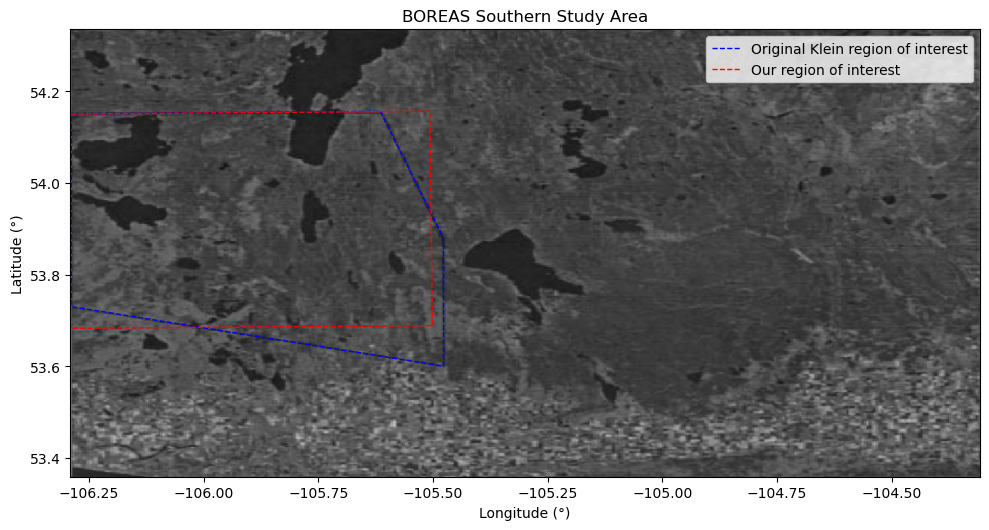

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

from shapely.geometry import Polygon
from pyproj import CRS, Transformer

# ------------------------------------------------------------
# PATH TO IMAGE
# ------------------------------------------------------------
# Adjust if needed; this matches your description.
IMG_PATH = Path.home() / "scratch" / "data" / "klein_site.png"
# If you're running where the file is /mnt/data/klein_site.png, use:
# IMG_PATH = Path("/mnt/data/klein_site.png")

# ------------------------------------------------------------
# GEOREFERENCING OF THE IMAGE (from your two corner coords)
# ------------------------------------------------------------
# Top-left corner: 54°20'4.59"N, 106°17'27.36"W
TOP_LAT  = 54.334608333333335
LEFT_LON = -106.29093333333333

# Bottom-right corner: 53°21'33.01"N, 104°18'26.23"W
BOTTOM_LAT = 53.35916944444445
RIGHT_LON  = -104.30728611111111

# Extent to pass to imshow: [lon_min, lon_max, lat_min, lat_max]
IMG_EXTENT = [LEFT_LON, RIGHT_LON, BOTTOM_LAT, TOP_LAT]

# ------------------------------------------------------------
# PROJECTIONS / TRANSFORMERS
# ------------------------------------------------------------
# Geographic (lat/lon) and projected (UTM zone 13N)
CRS_GEOG = CRS.from_epsg(4326)    # WGS84 lat/lon
CRS_UTM  = CRS.from_epsg(32613)   # UTM zone 13N (covers ~105°W)

ll_to_utm = Transformer.from_crs(CRS_GEOG, CRS_UTM, always_xy=True)
utm_to_ll = Transformer.from_crs(CRS_UTM, CRS_GEOG, always_xy=True)

# ------------------------------------------------------------
# FUNCTIONS
# ------------------------------------------------------------
def plot_background(ax=None):
    """Plot the Klein background image georeferenced in lon/lat."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))

    img = mpimg.imread(IMG_PATH)

    # origin='upper' assumes the first row in the PNG is the *top* of the map.
    ax.imshow(
        img,
        extent=IMG_EXTENT,
        origin="upper",
        cmap="gray",
        interpolation="nearest",
    )
    ax.set_xlabel("Longitude (°)")
    ax.set_ylabel("Latitude (°)")
    ax.set_title("BOREAS Southern Study Area")
    return ax


def square_region_latlon(center_lon, center_lat, side_km=52.0):
    """
    Build a side_km × side_km square centred on (lon, lat).
    Returns a Shapely Polygon in lon/lat coordinates.
    """
    # Centre in UTM (meters)
    x0, y0 = ll_to_utm.transform(center_lon, center_lat)

    half_side_m = (side_km * 1000.0) / 2.0

    # Square in UTM coordinates
    x_min = x0 - half_side_m
    x_max = x0 + half_side_m
    y_min = y0 - half_side_m
    y_max = y0 + half_side_m

    # Convert corners back to lon/lat so we can plot on the image axes
    corners_utm = [
        (x_min, y_min),
        (x_min, y_max),
        (x_max, y_max),
        (x_max, y_min),
        (x_min, y_min),  # close the polygon
    ]
    corners_ll = [utm_to_ll.transform(x, y) for x, y in corners_utm]
    # utm_to_ll gives (lon, lat) pairs
    return Polygon(corners_ll)


def main():
    # Your requested centre: 105.90 W, 53.92 N
    center_lon = -105.90
    center_lat = 53.92

    fig, ax = plt.subplots(figsize=(10, 10))

    # 1) Background image in lon/lat
    plot_background(ax=ax)

    # 2) 52 km × 52 km square region
    region_poly = square_region_latlon(center_lon, center_lat, side_km=52.0)
    xs, ys = region_poly.exterior.xy
    print(xs, ys)
    xk = [-106.28861458171227, -105.615, -105.477, -105.477, -106.28861458171227, -106.28861458171227]
    yk = [54.150005645250026, 54.15598944786511, 53.88, 53.6, 53.73, 54.150005645250026]

    # print(xs, ys)
    ax.plot(xk, yk, color="blue", linewidth=1, ls='--', label="Original Klein region of interest")
    ax.plot(xs, ys, color="red", linewidth=1, ls='--', label="Our region of interest")
    

    # Optional: make sure we’re looking at the same area as the image
    ax.set_xlim(LEFT_LON, RIGHT_LON)
    ax.set_ylim(BOTTOM_LAT, TOP_LAT)

    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()
